# F1 algorithm to predict the drivers in the podium and their positions

My name is Gabriela, and I follow F1 since I was around 10 years old. I am looking for an algorithm that helps me predict who will win the race several laps before it ends. This is a project in continuous progress as I am testing different algorithms to find the one that is closer to help me make my predictions

It is difficult, I know! :O
There are a lot of factors that influence who wins a race in F1. Some of them can be predicted easily but some of them cannot.

If you have a suggestion or an idea, please feel free to let me know ;)

In [ ]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://media.giphy.com/media/TgHQOqCqf9GH6/giphy.gif")

##  I. Installing packages and importing the data

In [ ]:
import pandas as pd
import numpy as np
import sklearn

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score #measures used to evaluate the models
from sklearn.metrics import confusion_matrix, classification_report #confusion matrix to evaluate results

from sklearn.model_selection import train_test_split #separte train and test data

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV #Hyperparameter optimization
from sklearn.model_selection import KFold #set kfold configuration
from sklearn.model_selection import cross_val_score #cross validation
from sklearn.metrics import make_scorer #set scores desired to train models

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler #to standardize values
from sklearn.decomposition import PCA #Principal Component Analysis

from sklearn.feature_selection import SelectKBest #Feature Selection
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif


path = 'C:/Users/gabri/Dropbox/Gaby/Proyectos/My_Portafolio/F1/Data/' #local
path = "/content/" #google collab

np.random.seed(1994) #random seed

In [ ]:
#The data stored in this path is obtained from the API of https://ergast.com/mrd/. It is continuously updated.
#To update this data please run the file "API_Requests_Results_Qualifying_Laps_PitStops.py"

ResultsDF=pd.read_csv(path+"ResultsDF.csv")
QualifyingDF=pd.read_csv(path+"QualifyingDF.csv")
LapsDF=pd.read_csv(path+"LapsDF.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Counting the number of features per dataframe

In [ ]:
ResultsDF=ResultsDF[ResultsDF["season"]>=2012].reset_index()
ResultsDF=ResultsDF.drop(columns=["index","Unnamed: 0"])
# ResultsDF.info() ##33

QualifyingDF=QualifyingDF[QualifyingDF["season"]>=2012].reset_index()
QualifyingDF=QualifyingDF.drop(columns=["index","Unnamed: 0"])
# QualifyingDF.info() #24

LapsDF=LapsDF[LapsDF["season"]>=2012].reset_index()
LapsDF=LapsDF.drop(columns=["index","Unnamed: 0"])
# LapsDF.info() #16

## II. Data Preprocessing

### Creating and transforming some features:

In [ ]:
#Creating Season-Round feature:
ResultsDF["Season-Round"]=ResultsDF["season"].astype(str)+"-"+ResultsDF["round"].astype(str)
LapsDF["Season-Round"]=LapsDF["season"].astype(str)+"-"+LapsDF["round"].astype(str)
QualifyingDF["Season-Round"]=QualifyingDF["season"].astype(str)+"-"+QualifyingDF["round"].astype(str)

#Creating Season-Round-Driver feature:
ResultsDF["Season-Round-DriverID"]=ResultsDF["season"].astype(str)+"-"+ResultsDF["round"].astype(str)+"-"+ResultsDF['Driver.driverId'].astype(str)
LapsDF["Season-Round-DriverID"]=LapsDF["season"].astype(str)+"-"+LapsDF["round"].astype(str)+"-"+LapsDF['driverId'].astype(str)
QualifyingDF["Season-Round-DriverID"]=QualifyingDF["season"].astype(str)+"-"+QualifyingDF["round"].astype(str)+"-"+QualifyingDF['Driver.driverId'].astype(str)

#Creating Season-Round-Lap feature:
LapsDF["Season-Round-DriverID-Lap"]=LapsDF["season"].astype(str)+"-"+LapsDF["round"].astype(str)+"-"+LapsDF['driverId'].astype(str)+"-"+LapsDF['LapNumber'].astype(str)

In [ ]:
#functions to create columns:

##label_race: Race completed or not
def label_race(row):
    if row["status"]=='Finished':
        return "Completed"
    elif row["status"]=='+1 Lap':
        return "Completed"
    elif row["status"]=='+2 Laps':
        return "Completed"
    elif row["status"]=='+3 Laps':
        return "Completed"
    elif row["status"]=='+4 Laps':
        return "Completed"
    elif row["status"]=='+5 Laps':
        return "Completed"
    elif row["status"]=='+6 Laps':
        return "Completed"
    elif row["status"]=='+7 Laps':
        return "Completed"
    elif row["status"]=='+8 Laps':
        return "Completed"
    elif row["status"]=='+9 Laps':
        return "Completed"
    elif row["status"]=='+10 Laps':
        return "Completed"
    elif row["status"]=='+11 Laps':
        return "Completed"
    elif row["status"]=='+12 Laps':
        return "Completed"
    elif row["status"]=='+13 Laps':
        return "Completed"
    else:
        return "Not Completed"

#podium: if the last position was a podium
def podium(row):
    if row["position"]==1:
        return "Podium"
    elif row["position"]==2:
        return "Podium"
    elif row["position"]==3:
        return "Podium"
    else:
        return "No Podium"

In [ ]:
#Adding the feature Completed
ResultsDF["Completed"]=ResultsDF.apply (lambda row: label_race(row), axis=1)

#Used previously to check the values
#ResultsDF.groupby(["Completed"])["status"].count().head(40)
1084+1+231+37+6+2+1+2+2103

3467

In [ ]:
#Adding the feature Podium
ResultsDF["Podium"]=ResultsDF.apply (lambda row: podium(row), axis=1)

In [ ]:
#Turning fastestlap into seconds:
ResultsDF[['FastestLap.Time.timeMIN', 'FastestLap.Time.timeSEC']]=ResultsDF['FastestLap.Time.time'].str.split(":", expand=True)
ResultsDF['FastestLap.Time.time_in_seconds']=ResultsDF['FastestLap.Time.timeMIN'].astype(float)*60+ResultsDF['FastestLap.Time.timeSEC'].astype(float)
ResultsDF=ResultsDF.drop(columns=['FastestLap.Time.timeMIN', 'FastestLap.Time.timeSEC'])

#Transforming lap_duration into seconds:
LapsDF[['lap_durationMIN', 'lap_durationSEC','nothing']]=LapsDF['LapDuration'].str.split(":", expand=True)
LapsDF['lap_duration_in_seconds']=LapsDF['lap_durationMIN'].astype(float)*60+LapsDF['lap_durationSEC'].astype(float)
LapsDF=LapsDF.drop(columns=['lap_durationMIN', 'lap_durationSEC','nothing'])

#Transforming Q1 into seconds:
QualifyingDF[["Q1Min","Q1Sec"]]=QualifyingDF["Q1"].str.split(":", expand=True)
QualifyingDF['Q1_in_seconds']=QualifyingDF['Q1Min'].astype(float)*60+QualifyingDF['Q1Sec'].astype(float)
QualifyingDF=QualifyingDF.drop(columns=["Q1Min","Q1Sec"])

#Transforming Q2 into seconds:
QualifyingDF[["Q2Min","Q2Sec"]]=QualifyingDF["Q2"].str.split(":", expand=True)
QualifyingDF['Q2_in_seconds']=QualifyingDF['Q2Min'].astype(float)*60+QualifyingDF['Q2Sec'].astype(float)
QualifyingDF=QualifyingDF.drop(columns=["Q2Min","Q2Sec"])

#Transforming Q3 into seconds:
QualifyingDF[["Q3Min","Q3Sec"]]=QualifyingDF["Q3"].str.split(":", expand=True)
QualifyingDF['Q3_in_seconds']=QualifyingDF['Q3Min'].astype(float)*60+QualifyingDF['Q3Sec'].astype(float)
QualifyingDF=QualifyingDF.drop(columns=["Q3Min","Q3Sec"])

In [ ]:
#Circuit, drivers and constructors are encoded

from sklearn.preprocessing import LabelEncoder

circuit_encoder = LabelEncoder()
circuit_encoder.fit(ResultsDF['Circuit.circuitId'])
circuit_values=circuit_encoder.transform(ResultsDF['Circuit.circuitId'])
ResultsDF['Circuit.circuitId_encoded']=circuit_values

constructor_encoder = LabelEncoder()
constructor_encoder.fit(ResultsDF['Constructor.constructorId'])
constructor_values=constructor_encoder.transform(ResultsDF['Constructor.constructorId'])
ResultsDF['Constructor.constructorId_encoded']=constructor_values

driver_encoder = LabelEncoder()
driver_encoder.fit(ResultsDF['Driver.driverId'])
driver_values=driver_encoder.transform(ResultsDF['Driver.driverId'])
ResultsDF['driverId_encoded']=driver_values

### Handling outliers

In [ ]:
#Feautures with outliers in the different dfs
WithOutliersR=["Time.millis","FastestLap.Time.time_in_seconds","FastestLap.AverageSpeed.speed"]
WithOutliersQ=['Q1_in_seconds', 'Q2_in_seconds', 'Q3_in_seconds']
WithOutliersL=['lap_duration_in_seconds']

#### 2021 Round 12 - Belgium Grand Prix

In [ ]:
#Getting rid of rows that have less than 30 laps, this means that the race was irregular
Races=LapsDF["Season-Round"].unique()

for i in Races:
    if len(LapsDF[LapsDF["Season-Round"]==i])<30:
        print(i," - ",len(LapsDF[LapsDF["Season-Round"]==i]))

#it is only a problem in one race

2021-12  -  20


In [ ]:
#Dropping this race from the 3 df
ResultsDF=ResultsDF[ResultsDF["Season-Round"] != "2021-12"].reset_index()
ResultsDF=ResultsDF.drop(columns=["index"])

LapsDF=LapsDF[LapsDF["Season-Round"] != "2021-12"].reset_index()
LapsDF=LapsDF.drop(columns=["index"])

QualifyingDF=QualifyingDF[QualifyingDF["Season-Round"] != "2021-12"].reset_index()
QualifyingDF=QualifyingDF.drop(columns=["index"])


#### In Results DF

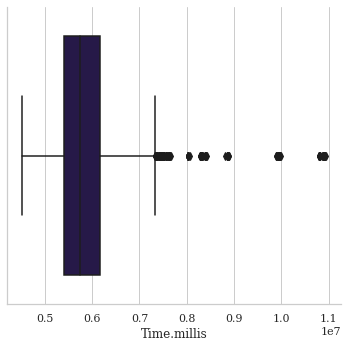

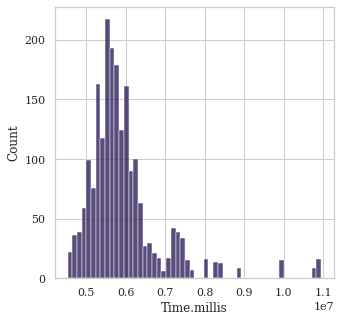

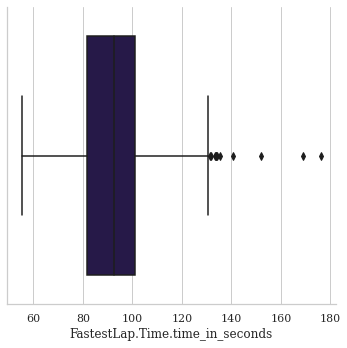

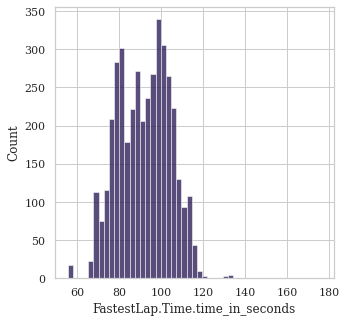

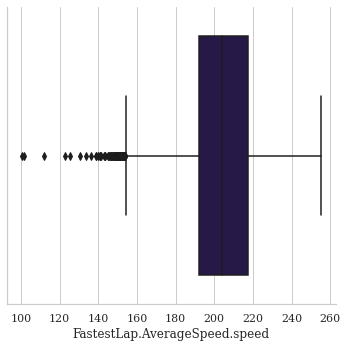

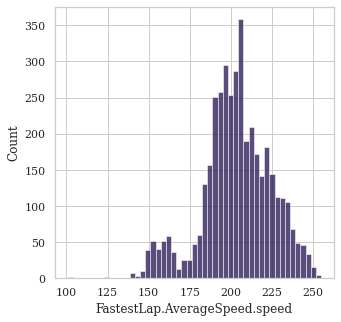

In [ ]:
#BoxPlot visualizations:
for i in WithOutliersR:
    #Barplots
    sns.set_theme(style="whitegrid", palette="magma",font_scale=1,font="serif")
    g=sns.catplot(x=i,data=ResultsDF,kind="box")
    g.set(xlabel=str(i))
    plt.show()
    
    #Histograms
    sns.set_theme(style="whitegrid", palette="magma",font_scale=1,font="serif")
    fig, ax = plt.subplots(figsize=(5,5))
    sns.histplot(x=i,data=ResultsDF)
    plt.ylabel=str(i)
    plt.show()

In [ ]:
#Replacing the outliers

for i in WithOutliersR[:2]:
    #Quantile measures
    q1=ResultsDF[i].quantile(0.01)
    q99=ResultsDF[i].quantile(0.99)
 
    #TREATMENT FOR OUTLIERS: PERCENTILE BASED METHOD

    #Caps
    upper_extreme=q99
    lower_extreme=q1
 
    #Indexes that are above the limit
    Upper=ResultsDF[ResultsDF[i]>upper_extreme][i]
    Lower=ResultsDF[ResultsDF[i]<lower_extreme][i]
    print(str(i)," : ",str(len(Upper))," outliers.")

    # #Replacing outliers
    for n in Upper:
        ResultsDF[i]=ResultsDF[i].replace(n,upper_extreme)
    
    # for n in Lower:
    #     ResultsDF[i]=ResultsDF[i].replace(n,lower_extreme)
            
print("all done")

ii=WithOutliersR[-1]
#Quantile measures
q1=ResultsDF[ii].quantile(0.01)
q99=ResultsDF[ii].quantile(0.99)

#TREATMENT FOR OUTLIERS: PERCENTILE BASED METHOD

#Caps
upper_extreme=q99
lower_extreme=q1

#Indexes that are above the limit
Upper=ResultsDF[ResultsDF[ii]>upper_extreme][ii]
Lower=ResultsDF[ResultsDF[ii]<lower_extreme][ii]
print(str(ii)," : ",str(len(Lower))," outliers.")

# #Replacing outliers
for n in Lower:
    ResultsDF[i]=ResultsDF[i].replace(n,lower_extreme)

print("all done")

Time.millis  :  21  outliers.
FastestLap.Time.time_in_seconds  :  41  outliers.
all done
FastestLap.AverageSpeed.speed  :  41  outliers.
all done


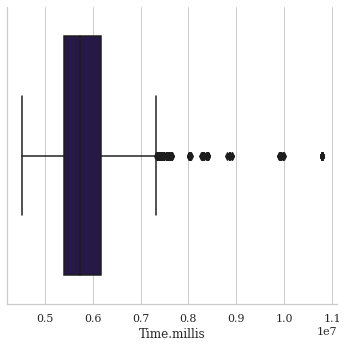

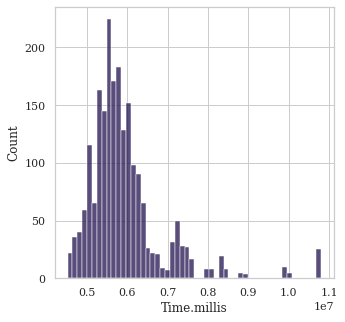

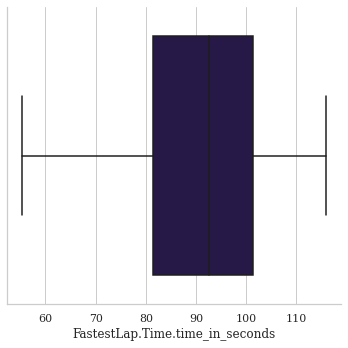

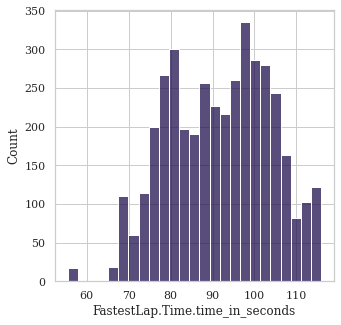

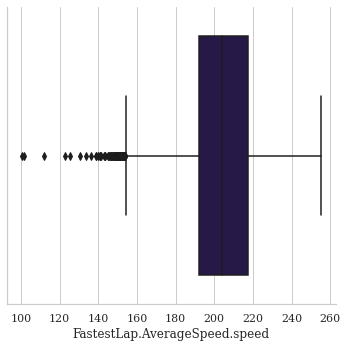

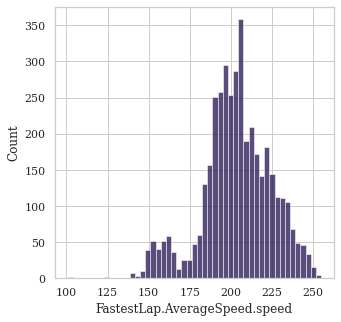

In [ ]:
#Box plots post outlier sustitution
for i in WithOutliersR:
    #Barplots
    sns.set_theme(style="whitegrid", palette="magma",font_scale=1,font="serif")
    g=sns.catplot(x=i,data=ResultsDF,kind="box")
    g.set(xlabel=str(i))
    plt.show()
    
    #Histograms
    sns.set_theme(style="whitegrid", palette="magma",font_scale=1,font="serif")
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.histplot(x=i,data=ResultsDF)
    plt.ylabel=str(i)
    plt.show()

#### In Qualifying DF

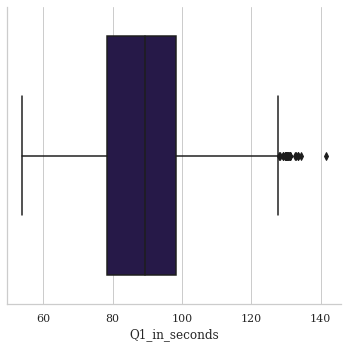

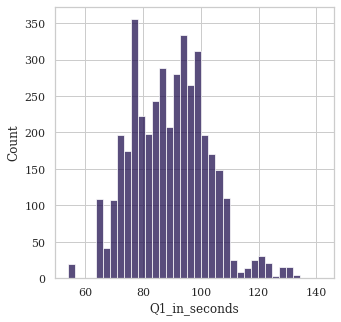

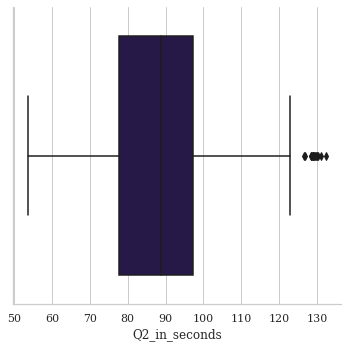

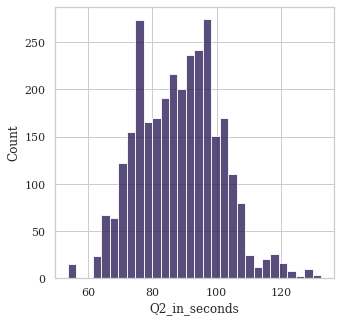

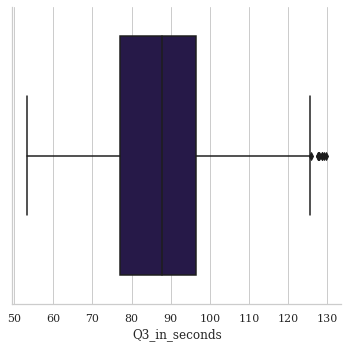

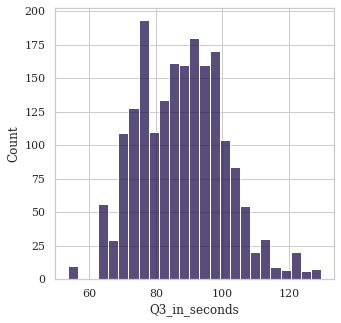

In [ ]:
#Boxplots before treating outliers
for i in WithOutliersQ:
    #Barplots
    sns.set_theme(style="whitegrid", palette="magma",font_scale=1,font="serif")
    g=sns.catplot(x=i,data=QualifyingDF,kind="box")
    g.set(xlabel=str(i))
    plt.show()
    
    #Histograms
    sns.set_theme(style="whitegrid", palette="magma",font_scale=1,font="serif")
    fig, ax = plt.subplots(figsize=(5,5))
    sns.histplot(x=i,data=QualifyingDF)
    plt.ylabel=str(i)
    plt.show()

In [ ]:
#Replacing the values of the outliers

for i in WithOutliersQ:
    #Quantile measures
    q1=QualifyingDF[i].quantile(0.01)
    q99=QualifyingDF[i].quantile(0.99)
 
    #TREATMENT FOR OUTLIERS: PERCENTILE BASED METHOD

    #Caps
    upper_extreme=q99
    lower_extreme=q1
 
    #Indexes that are above the limit
    Upper=QualifyingDF[QualifyingDF[i]>upper_extreme][i]
    Lower=QualifyingDF[QualifyingDF[i]<lower_extreme][i]
    print(str(i)," : ",str(len(Upper)+len(Lower))," outliers.")

    # #Replacing outliers
    for n in Upper:
        QualifyingDF[i]=QualifyingDF[i].replace(n,upper_extreme)
    
    # for n in Lower:
    #     QualifyingDF[i]=QualifyingDF[i].replace(n,lower_extreme)
            
print("all done")

Q1_in_seconds  :  84  outliers.
Q2_in_seconds  :  62  outliers.
Q3_in_seconds  :  40  outliers.
all done


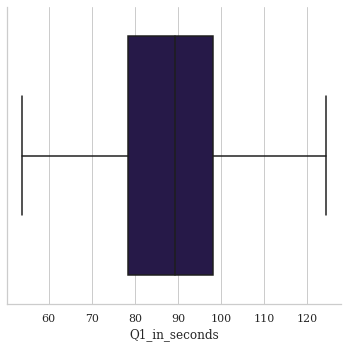

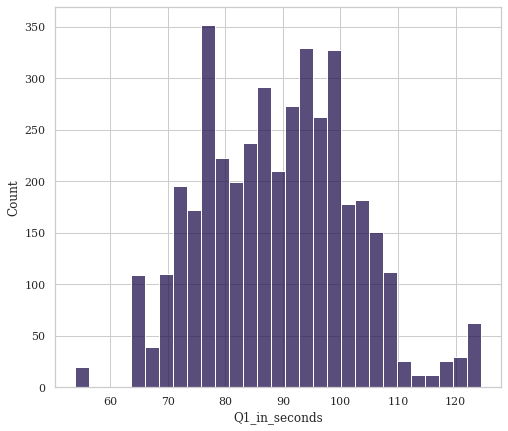

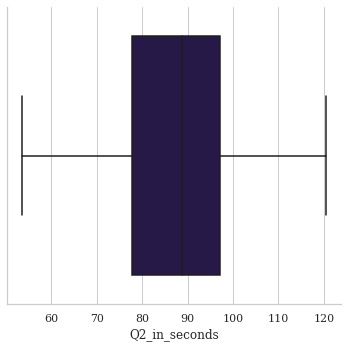

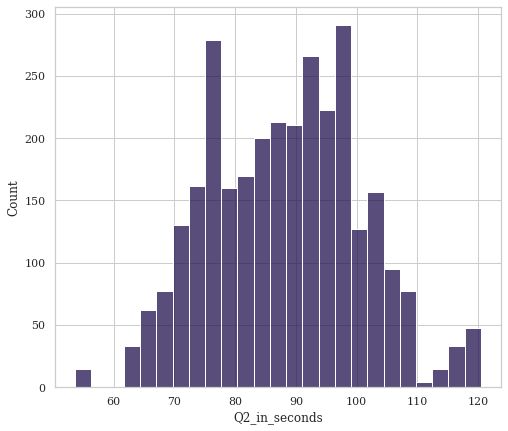

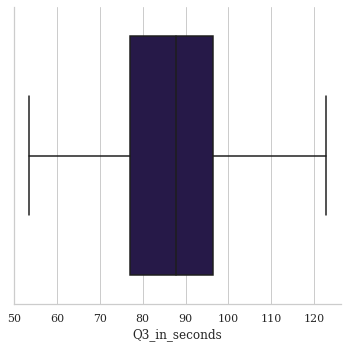

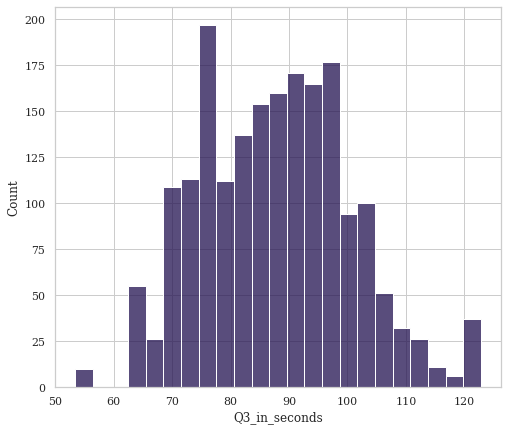

In [ ]:
#Pox blots post outlier handling
for i in WithOutliersQ:
    #Barplots
    sns.set_theme(style="whitegrid", palette="magma",font_scale=1,font="serif")
    g=sns.catplot(x=i,data=QualifyingDF,kind="box")
    g.set(xlabel=str(i))
    plt.show()
    
    #Histograms
    sns.set_theme(style="whitegrid", palette="magma",font_scale=1,font="serif")
    fig, ax = plt.subplots(figsize=(8, 7))
    sns.histplot(x=i,data=QualifyingDF)
    plt.ylabel=str(i)
    plt.show()

#### In Laps DF

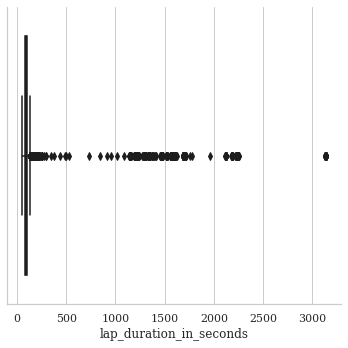

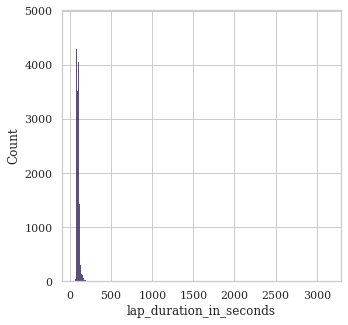

In [ ]:
#Boxplots before treating the outliers
for i in WithOutliersL:
    #Barplots
    sns.set_theme(style="whitegrid", palette="magma",font_scale=1,font="serif")
    g=sns.catplot(x=i,data=LapsDF,kind="box")
    g.set(xlabel=str(i))
    plt.show()
    
    #Histograms
    sns.set_theme(style="whitegrid", palette="magma",font_scale=1,font="serif")
    fig, ax = plt.subplots(figsize=(5,5))
    sns.histplot(x=i,data=LapsDF)
    plt.ylabel=str(i)
    plt.show()

In [ ]:
#Replacing the outliers
for i in WithOutliersL:
    #Quantile measures
    q1=LapsDF[i].quantile(0.01)
    q99=LapsDF[i].quantile(0.99)
 
    #TREATMENT FOR OUTLIERS: PERCENTILE BASED METHOD

    #Caps
    upper_extreme=q99
    lower_extreme=q1
 
    #Indexes that are above the limit
    Upper=LapsDF[LapsDF[i]>upper_extreme][i]
    Lower=LapsDF[LapsDF[i]<lower_extreme][i]
    print(str(i)," : ",str(len(Upper)+len(Lower))," outliers.")

    # #Replacing outliers
    for n in Upper:
        LapsDF[i]=LapsDF[i].replace(n,upper_extreme)
    
    # for n in Lower:
    #     LapsDF[i]=LapsDF[i].replace(n,lower_extreme)
            
print("all done")

lap_duration_in_seconds  :  4495  outliers.
all done


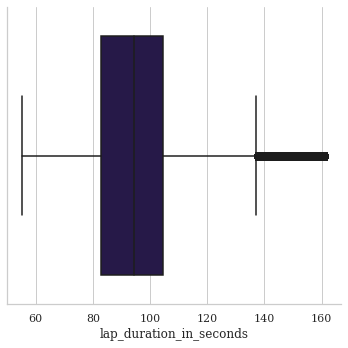

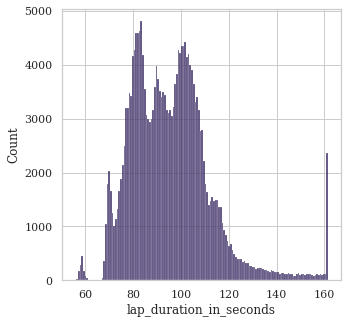

In [ ]:
#Boxplots after trating the outliers
for i in WithOutliersL:
    #Barplots
    sns.set_theme(style="whitegrid", palette="magma",font_scale=1,font="serif")
    g=sns.catplot(x=i,data=LapsDF,kind="box")
    g.set(xlabel=str(i))
    plt.show()
    
    #Histograms
    sns.set_theme(style="whitegrid", palette="magma",font_scale=1,font="serif")
    fig, ax = plt.subplots(figsize=(5,5))
    sns.histplot(x=i,data=LapsDF)
    plt.ylabel=str(i)
    plt.show()

### Handling Missing values

In [ ]:
#This was used to verify what type of imputs had the missing valeus in each feature
#ResultsDF[(ResultsDF['Constructor.constructorId_encoded'].isna())&(ResultsDF["Completed"]=="Completed")]


In [ ]:
#Filling the na's

#Total time race (max value)
#Filling rows that dont have the prev race time to the max value posible, this becasue it is the longest we have seen that a car has finished a race.
#All the instances that have this value missing is becasue they did not end the race
ResultsDF['Time.millis'].fillna(ResultsDF['Time.millis'].max(),inplace=True)

#Fastest Lap Rank (max value)
# #Filling the rows with no prev rank with the max value posible, this becasue it is the lowest they can go. This happens when a pilot debuts, or they crashed in the first laps, if we put 0, the values can get messed up
# max because it is the worst they can do
ResultsDF['FastestLap.rank'].fillna(ResultsDF['FastestLap.rank'].max(),inplace=True)
ResultsDF['FastestLap.rank']=ResultsDF['FastestLap.rank'].replace(0,ResultsDF['FastestLap.rank'].max())
ResultsDF['FastestLap.rank'].unique()

#Fastest Lap Lap (0)
# #Filling the rows with 0 of the fastest lap. 0 Becasue it can give indicative that  if it it already passed the chance of being the fastest now it will be difficult
ResultsDF["FastestLap.lap"].fillna(0,inplace=True)

#Fastest Lap time (max value)
#Filling the value of the fastest lap with the max number available, this because if it did not have info, It possibly means that the race they did not had a fastest lap becasue they did not end the race 
ResultsDF["FastestLap.Time.time_in_seconds"].fillna(ResultsDF["FastestLap.Time.time_in_seconds"].max(),inplace=True)

#Fastest Lap Average Speed (min value)
#Filling the prev speed with the lowest speed possible
ResultsDF['FastestLap.AverageSpeed.speed'].fillna(ResultsDF['FastestLap.AverageSpeed.speed'].min(),inplace=True)


#Qualifying times (Q1,Q2,Q3) (max value)
# #Filling Q1 with max value posible+1 second
QualifyingDF["Q1_in_seconds"].fillna(QualifyingDF["Q1_in_seconds"].max(),inplace=True)

# #Filling Q2 with max value posible+1 second
QualifyingDF["Q2_in_seconds"].fillna(QualifyingDF["Q2_in_seconds"].max(),inplace=True)

# #Filling Q3 with max value posible+1 second
QualifyingDF["Q3_in_seconds"].fillna(QualifyingDF["Q3_in_seconds"].max(),inplace=True)


### Reducing the number of features present in ResultsDF

In [ ]:
SelectedResults=ResultsDF[['Season-Round', 'Season-Round-DriverID',"Podium",'position','points', 'grid','laps', 'status', 'Driver.driverId','Driver.nationality',"Circuit.circuitId",
'Constructor.constructorId','Constructor.nationality','season', 'round',"Completed",'Time.millis','FastestLap.rank', 'FastestLap.lap', 'FastestLap.Time.time_in_seconds',
    'FastestLap.AverageSpeed.speed','driverId_encoded','Constructor.constructorId_encoded','Circuit.circuitId_encoded']]

#Renaming certain columns in SelectedResults
SelectedResults=SelectedResults.rename(columns={"position":'position_final_race',"laps":"laps_total_race","Driver.driverId":"driverId",'FastestLap.AverageSpeed.speed':'FastestLap.AverageSpeed.speedKph'})


### Joining Results + some summary information from Laps and Qualifying

#### Adding information from the past of ResultsDF

In [ ]:
#Modifying the structure of SelectedResults so that we can add some features with lags

WhereItWillBeChanged=SelectedResults["Season-Round"].unique()[1:] #Season where the info is included
TheLags=SelectedResults["Season-Round"].unique()[:-1] #Season where the info is extracted from

#Function to create the column with the lags. It generates a separate dataframe
def getThePrevious(name):
    #Just the information related to the final position of the race:
    SubsetSelectedResults=SelectedResults[['Season-Round-DriverID',"Season-Round","driverId",name]]
    NewName="Prev_"+name
    SubsetSelectedResults[NewName]=199408  #this is a random number that will not get confused with any other number to replace

    for i,race in enumerate(WhereItWillBeChanged):
        theDrivers=SelectedResults[SelectedResults["Season-Round"]==WhereItWillBeChanged[i]]["driverId"].unique()
        for d,driver in enumerate(theDrivers):
            Moving=SubsetSelectedResults[(SubsetSelectedResults["Season-Round"]==TheLags[i]) & (SubsetSelectedResults["driverId"]==theDrivers[d])][name].unique()
            if Moving.size==0: #In the case that we cannot find the value of the previous race for the driver for any reason
                continue
            else:
                theMove=SubsetSelectedResults[(SubsetSelectedResults["Season-Round"]==WhereItWillBeChanged[i]) & (SubsetSelectedResults["driverId"]==theDrivers[d])].replace(199408,Moving[0])
                SubsetSelectedResults[(SubsetSelectedResults["Season-Round"]==WhereItWillBeChanged[i]) & (SubsetSelectedResults["driverId"]==theDrivers[d])]=theMove
    UpdatedSubsetSelectedResults=SubsetSelectedResults.replace(199408,0) #In the cases of the extremes we need to make this adjustment

    return UpdatedSubsetSelectedResults

In [ ]:
#Creating the feautures that have previous information

PrevFinalPositions=getThePrevious("position_final_race")
print("Ready: position_final_race")

PrevGrid=getThePrevious("grid")
print("Ready: Grid")

PrevTimeMillis=getThePrevious('Time.millis')
print("Ready: TimeMillis")

PrevFastestLapRank=getThePrevious('FastestLap.rank')
print("Ready: FastestLap.rank")

PrevFastestLapLap=getThePrevious('FastestLap.lap')
print("Ready: FastestLap.lap")

PrevFastestLaptime_in_seconds=getThePrevious('FastestLap.Time.time_in_seconds')
print("Ready: FastestLap.Time.time_in_seconds")

PrevFastestLapAverageSpeedspeedKph=getThePrevious('FastestLap.AverageSpeed.speedKph')
print("Ready: FastestLap.AverageSpeed.speedKph")

PrevStatus=getThePrevious('status')
print("Ready: Status")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1851: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

Ready: position_final_race
Ready: Grid
Ready: TimeMillis
Ready: FastestLap.rank
Ready: FastestLap.lap
Ready: FastestLap.Time.time_in_seconds
Ready: FastestLap.AverageSpeed.speedKph


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Ready: Status


In [ ]:
#The features extracted previously are added in SelectedResults:

PreSelectedResults=SelectedResults.copy(deep=True) #Making a dopy of the original df

SelectedResults=pd.merge(SelectedResults,PrevFinalPositions[["Season-Round-DriverID","Prev_position_final_race"]],on="Season-Round-DriverID",how="left")
SelectedResults=pd.merge(SelectedResults,PrevGrid[["Season-Round-DriverID","Prev_grid"]],on="Season-Round-DriverID",how="left")
SelectedResults=pd.merge(SelectedResults,PrevTimeMillis[["Season-Round-DriverID","Prev_Time.millis"]],on="Season-Round-DriverID",how="left")
SelectedResults=pd.merge(SelectedResults,PrevFastestLapRank[["Season-Round-DriverID","Prev_FastestLap.rank"]],on="Season-Round-DriverID",how="left")
SelectedResults=pd.merge(SelectedResults,PrevFastestLapLap[["Season-Round-DriverID","Prev_FastestLap.lap"]],on="Season-Round-DriverID",how="left")
SelectedResults=pd.merge(SelectedResults,PrevFastestLaptime_in_seconds[["Season-Round-DriverID","Prev_FastestLap.Time.time_in_seconds"]],on="Season-Round-DriverID",how="left")
SelectedResults=pd.merge(SelectedResults,PrevFastestLapAverageSpeedspeedKph[["Season-Round-DriverID","Prev_FastestLap.AverageSpeed.speedKph"]],on="Season-Round-DriverID",how="left")
SelectedResults=pd.merge(SelectedResults,PrevStatus[["Season-Round-DriverID","Prev_status"]],on="Season-Round-DriverID",how="left")


SelectedResults=SelectedResults.drop_duplicates()
SelectedResults=SelectedResults.reset_index()
SelectedResults=SelectedResults.drop(columns=["index"])

In [ ]:
#Used for comprobation (commented)
# PreSelectedResults.info() #4245 entries, 0 to 4244
# SelectedResults[SelectedResults["driverId"]=="vettel"][['Season-Round-DriverID','position_final_race','Prev_position_final_race','grid', 'Prev_grid','Time.millis', 'Prev_Time.millis',
#        'FastestLap.rank','Prev_FastestLap.rank', 'FastestLap.lap','Prev_FastestLap.lap',
#        'FastestLap.Time.time_in_seconds','Prev_FastestLap.Time.time_in_seconds',
#        'FastestLap.AverageSpeed.speedKph','Prev_FastestLap.AverageSpeed.speedKph']].tail(6)


#### Adding information from QualifyingDF

In [ ]:
SelectedResults=pd.merge(SelectedResults,QualifyingDF[['Season-Round-DriverID','Q1_in_seconds', 'Q2_in_seconds', 'Q3_in_seconds']],on='Season-Round-DriverID',how="left")
len(SelectedResults)

4205

In [ ]:
# #Filling Q1 with max value posible
SelectedResults["Q1_in_seconds"].fillna(SelectedResults["Q1_in_seconds"].max(),inplace=True)

# #Filling Q2 with max value posible
SelectedResults["Q2_in_seconds"].fillna(SelectedResults["Q2_in_seconds"].max(),inplace=True)

# #Filling Q3 with max value posible
SelectedResults["Q3_in_seconds"].fillna(SelectedResults["Q3_in_seconds"].max(),inplace=True)


#### Adding information from the laps DF (function)

In [ ]:
#Function to create dataframe ResultsExpanded according to percentile chosen:

#it has basic information from the ResultsDF + information about specific laps from LapsDF

def createResultsExpanded(percentile,previous_laps_considered):
    #Copy of laps dataframe
    MLaps=LapsDF[LapsDF["season"]>=2012].copy(deep=True)

    #Selecting the maximum number of laps per race and season that we want to have available before making a prediction
    a=SelectedResults[SelectedResults["Completed"]=="Completed"][["season","round","laps_total_race"]].copy(deep=True)
    a["laps_considered"]=a["laps_total_race"]*percentile
    a["laps_considered"]=a["laps_considered"].astype(int)
    a=pd.DataFrame({'laps_considered' : a.groupby(["season","round",])["laps_considered"].max()}).reset_index()
    a

    #Selecting the laps that get inside this range
    MLaps=pd.merge(MLaps,a,on=["season","round"],how="left")
    SelectedLaps=MLaps[MLaps['LapNumber'] <= MLaps['laps_considered']] #only the ones equal or before

    #Fastest per driver and per race until that moment
    fastestperdriver=pd.DataFrame({'Fastest_per_driver' : SelectedLaps.groupby(["season","round","driverId"])["lap_duration_in_seconds"].min()}).reset_index()
    fastestperrace=pd.DataFrame({'Fastest_per_race' : SelectedLaps.groupby(["season","round"])["lap_duration_in_seconds"].min()}).reset_index()
    new=pd.merge(fastestperdriver,fastestperrace,on=["season","round"],how="left")
    new=pd.merge(new,a,on=["season","round"],how="left") #adding lap until it is being considered

    #Adding the previous laps and positions we want
    for i in range(1,previous_laps_considered+1):
        lapname='lap_'+str(i)+'_duration_secs'
        positionname='position_'+str(i)
        Lap_m=MLaps[["season","round","driverId","lap_duration_in_seconds","position"]][MLaps['LapNumber'] == (MLaps['laps_considered']-i)]
        new=pd.merge(new,Lap_m,on=["season","round","driverId"],how="left") #adding lap and position
        new=new.rename(columns={"lap_duration_in_seconds":lapname,"position":positionname})

    ResultsExpanded=pd.merge(SelectedResults,new,on=["season","round","driverId"],how="left")
    #ResultsExpanded = ResultsExpanded.dropna() #droping rows with na's

    ResultsExpanded=ResultsExpanded[ResultsExpanded["Completed"]=="Completed"].reset_index() #only the finished
    ResultsExpanded=ResultsExpanded.drop(columns=["index"])

    return ResultsExpanded

In [ ]:
#used to check the number of imputs (commented)
#SelectedResults.info() #4205 entries, 0 to 4224
#SelectedResults[SelectedResults["Completed"]=="Completed"].reset_index().info() #RangeIndex: 3430 entries, 0 to 3429

## III. Premliminar EDA

#### A. How fast are the cars now?

##### The fastest lap per round (race) from season 2012 to 2022 per driver

In this graph we can see the fastest lap, per race, per driver, and per season. As from 2012 until the present, there have been a lot of drivers racing in F1, the legend show as the nationality of the driver. The label at the bottom of each point from each year also show us the name of the driver who did had the fastest lap of the season.

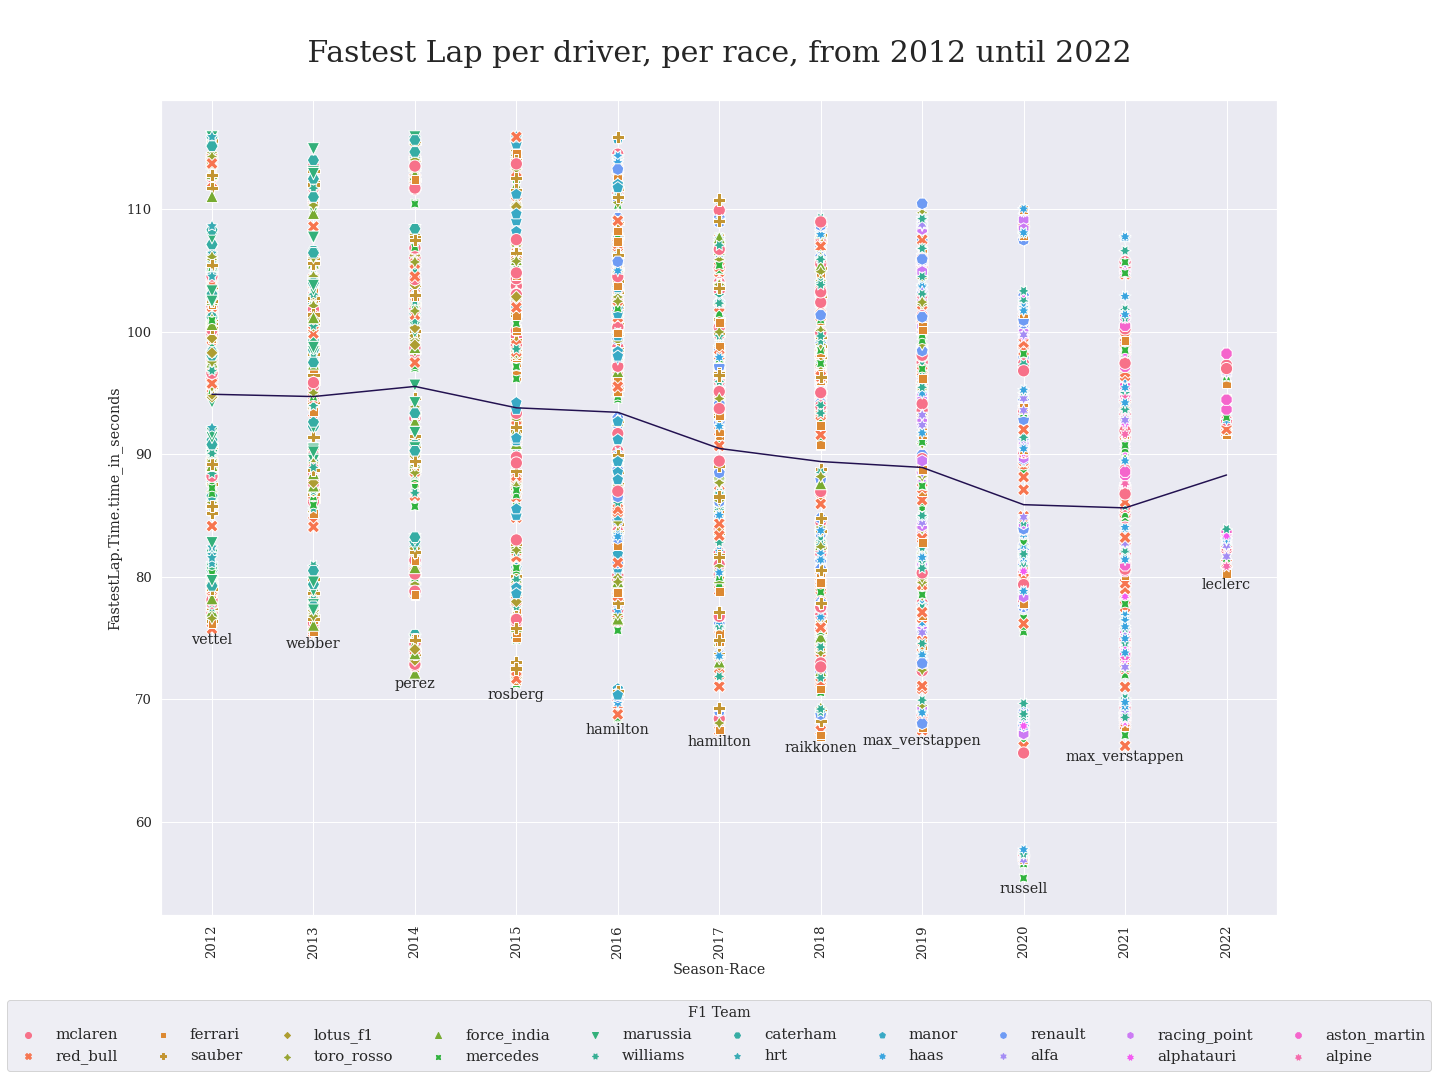

In [ ]:
sns.set_theme(style="darkgrid", palette="magma",font_scale=1.2,font="serif")
Years=ResultsDF["season"].unique().tolist() #or seasons for plot

#Fastest lap per driver per season
LABELS=pd.DataFrame(columns=["Driver.driverId","FastestLap.Time.time_in_seconds","season"])
for i in ResultsDF[ResultsDF["season"]>=2012]["season"].unique().tolist():
    A=pd.DataFrame(ResultsDF[ResultsDF["season"]==i].groupby(["Driver.driverId"])["FastestLap.Time.time_in_seconds"].min())
    A["season"]=i
    Selected=A[A["FastestLap.Time.time_in_seconds"]==min(A["FastestLap.Time.time_in_seconds"])].reset_index()
    LABELS=pd.concat([LABELS,Selected])

#Plot
fig, ax = plt.subplots(figsize=(20, 15))
sns.scatterplot(x="season", y="FastestLap.Time.time_in_seconds",s=150,style='Constructor.constructorId',hue='Constructor.constructorId',ci=None,estimator="min",
           data=ResultsDF[ResultsDF["Completed"]=="Completed"])
sns.lineplot(x="season", y="FastestLap.Time.time_in_seconds",estimator="mean",ci=None,
           data=ResultsDF[ResultsDF["Completed"]=="Completed"])

plt.locator_params(axis="x", nbins = len(Years))
plt.title("\n Fastest Lap per driver, per race, from 2012 until 2022 \n",fontsize=30)
plt.xlabel("Season-Race")
# plt.ylabel("Fastest Lap in Seconds")
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(0.5, -0.2),loc='lower center', title="F1 Team", ncol=10,prop={'size': 15})


#Individual labels of the fastest lap of the season:
for label,y,x in LABELS.to_numpy():
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center


plt.show()



##### Top speed per round from 2012 until 2022 per driver

This plot shows the top speed per race, per driver, per season. It also contains the team of each driver. Hamilton has been the fastest for 7 seasons with Mercedes! It is important to mention that the speed in which cars go depend on the mechanical regulations that the FIA has for each year. We would think that overtime, cars should get faster. Well, that doesn't happen because teams are obliged to satisfy safety and racing mechanical regulations per year.

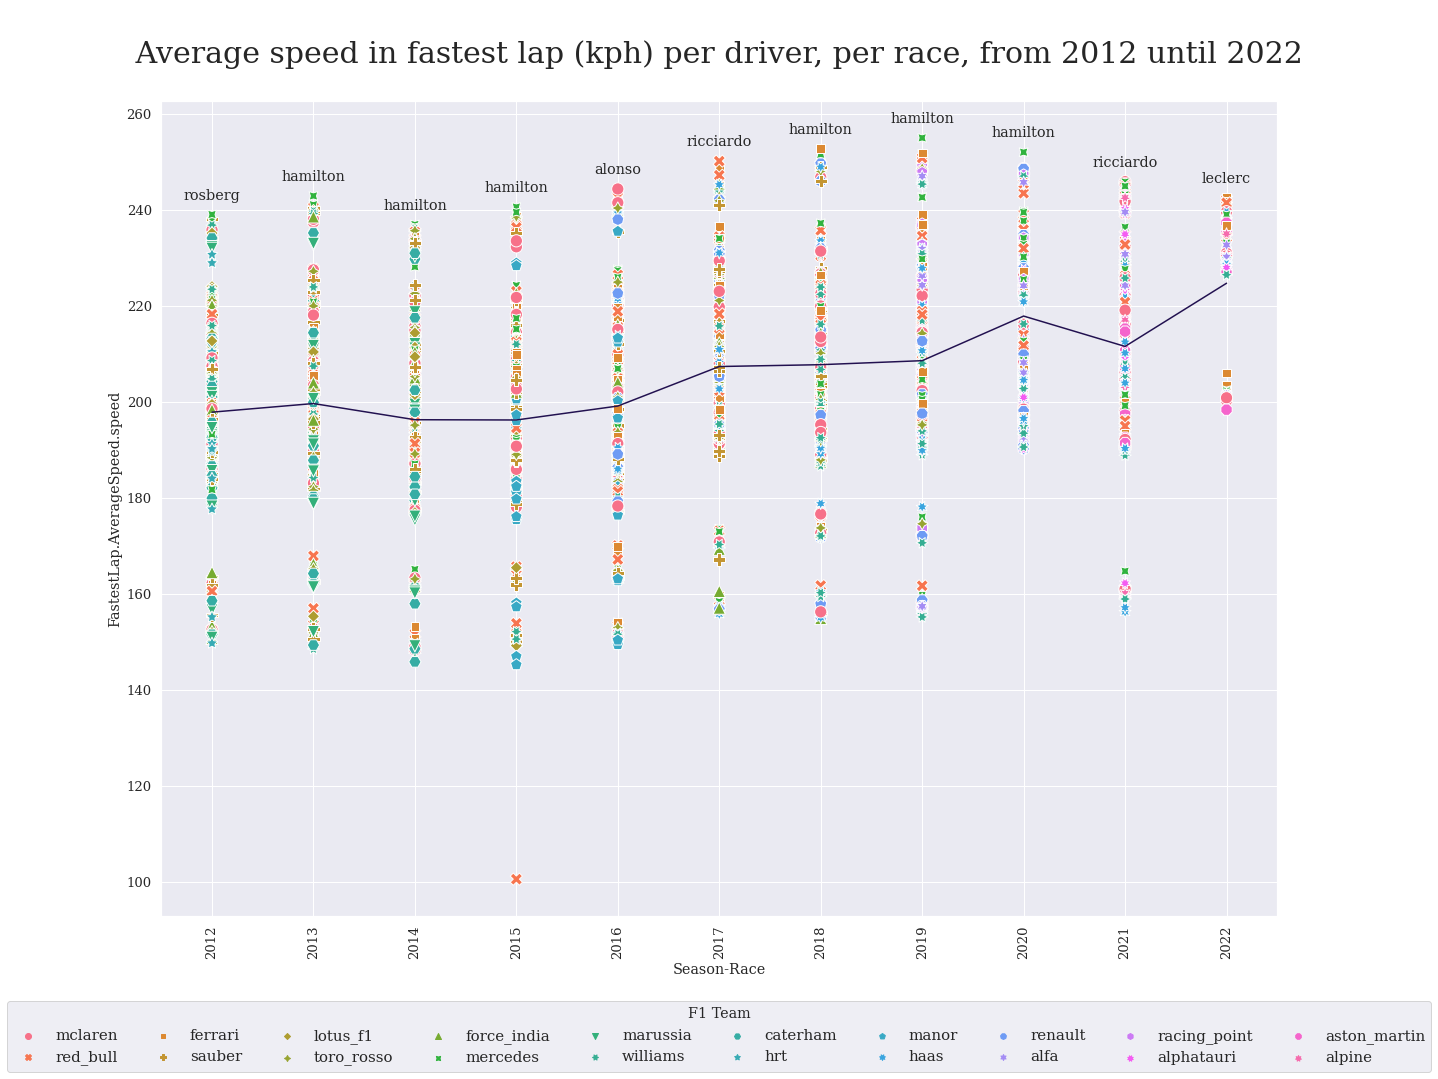

In [ ]:
sns.set_theme(style="darkgrid", palette="magma",font_scale=1.2,font="serif")
Years=ResultsDF["season"].unique().tolist() #or seasons for plot

#Top speed per driver per season
LABELS=pd.DataFrame(columns=["Driver.driverId",'FastestLap.AverageSpeed.speed',"season"])
for i in ResultsDF[ResultsDF["season"]>=2012]["season"].unique().tolist():
    A=pd.DataFrame(ResultsDF[ResultsDF["season"]==i].groupby(["Driver.driverId"])['FastestLap.AverageSpeed.speed'].max())
    A["season"]=i
    Selected=A[A['FastestLap.AverageSpeed.speed']==max(A['FastestLap.AverageSpeed.speed'])].reset_index()
    LABELS=pd.concat([LABELS,Selected])

#Plot
fig, ax = plt.subplots(figsize=(20,15))
sns.scatterplot(x="season", y='FastestLap.AverageSpeed.speed',s=150,style='Constructor.constructorId',hue='Constructor.constructorId',ci=None,estimator="max",
           data=ResultsDF[ResultsDF["Completed"]=="Completed"])
sns.lineplot(x="season", y='FastestLap.AverageSpeed.speed',estimator="mean",ci=None,
           data=ResultsDF[ResultsDF["Completed"]=="Completed"])

plt.locator_params(axis="x", nbins = len(Years))
plt.title("\n Average speed in fastest lap (kph) per driver, per race, from 2012 until 2022 \n",fontsize=30)
plt.xlabel("Season-Race")
# plt.ylabel("Top speed (kph)")
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(0.5, -0.2),loc='lower center', title="F1 Team", ncol=10,prop={'size': 15})


#Individual labels of the fastest lap of the season:
for label,y,x in LABELS.to_numpy():
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center


plt.show()


##### Top speed (kph) comparison per team in the last 10 years

In the last 10 years, the F1 has been dominated by Mercedes and Red Bull. This can be seen in the top speed of their cars. In seasons 2011, 2012, and 2013, Red Bull had the highest average top speeds during the season. However, from 2014 and later, this place was taken by Mercedes (except 2017 where Ferrari took the lead).

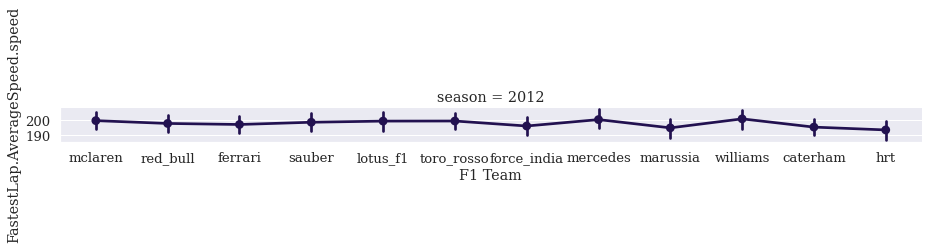

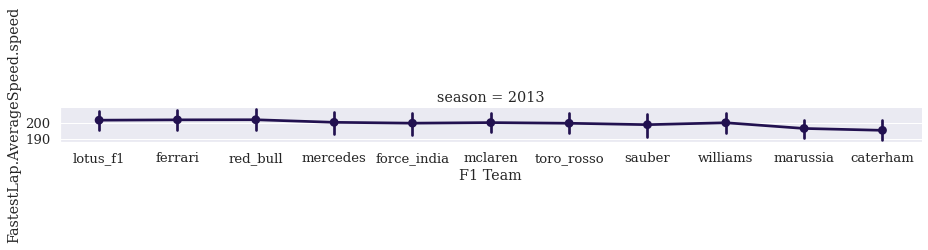

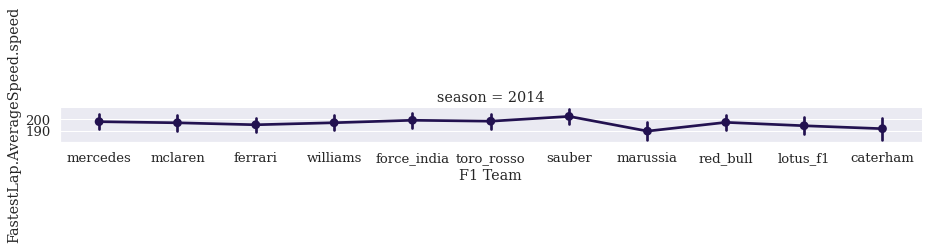

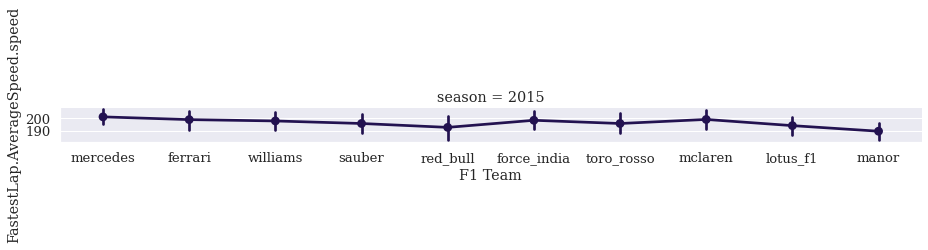

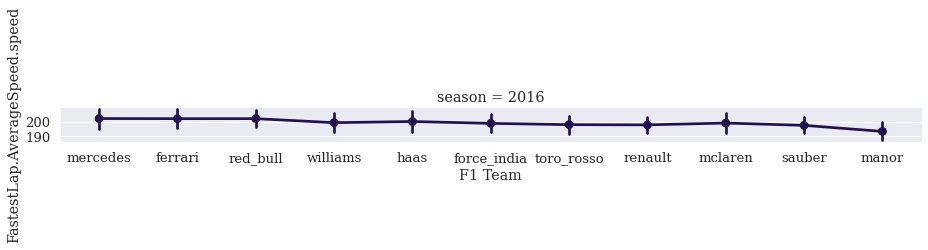

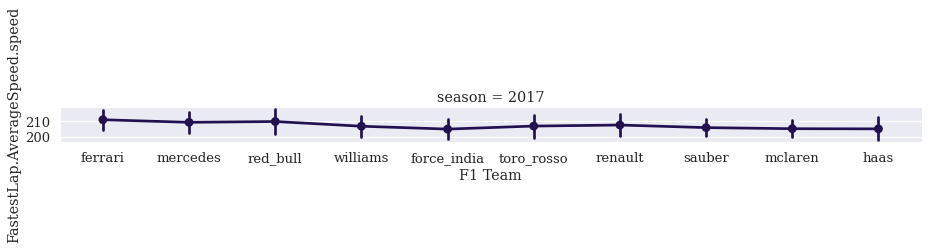

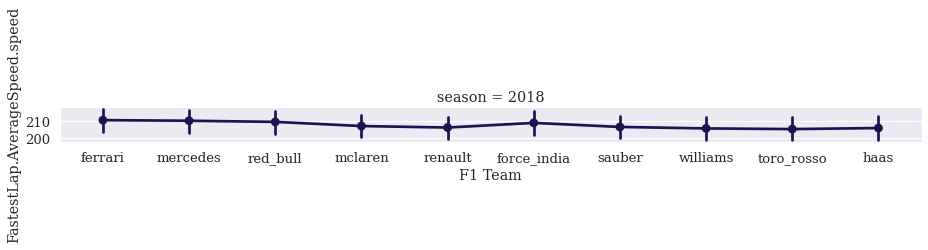

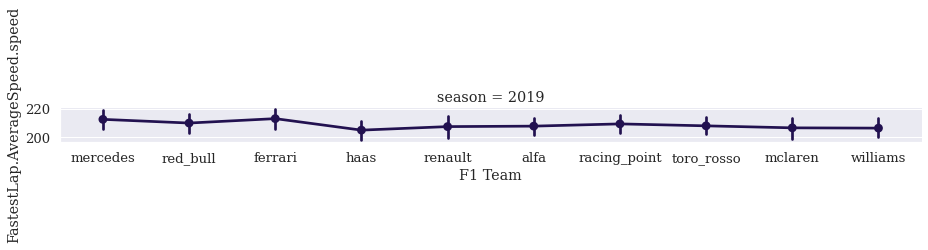

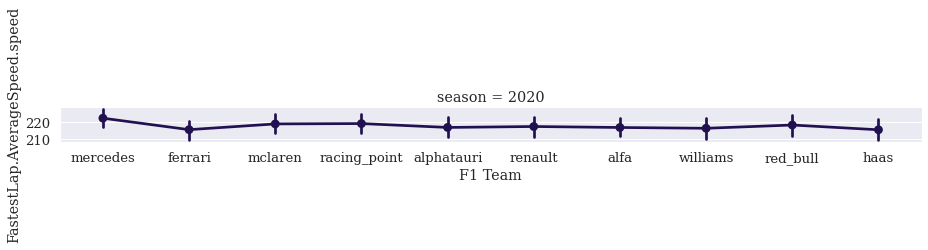

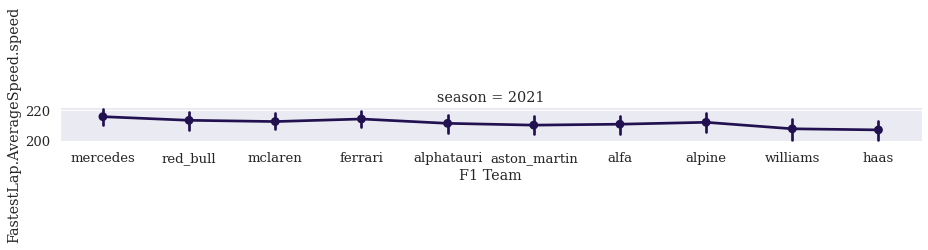

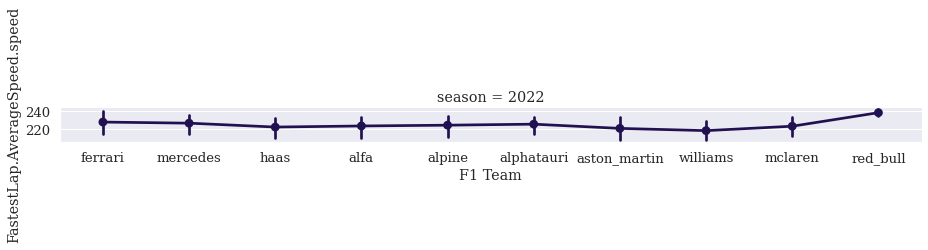

In [ ]:
sns.set_theme(style="darkgrid", palette="magma",font_scale=1.2,font="serif")


#Plot
for i in Years:
    if i<=2010:
        continue
    else:
        g = sns.catplot(x='Constructor.constructorId', y='FastestLap.AverageSpeed.speed',
        col="season",kind="point",col_wrap=3,height=2.5,aspect=5,
                data=ResultsDF[(ResultsDF["season"]==i)&(ResultsDF["Completed"]=="Completed")])
        plt.xlabel("F1 Team")
        # plt.ylabel("Top Speed (kmh)")

plt.show()


##### Fastest lap comparison between circuits (2021)

This analysis was done using last 2021 as reference. The fastest circuit in 2021 was the Red Bull Ring and the slowest, Baku.

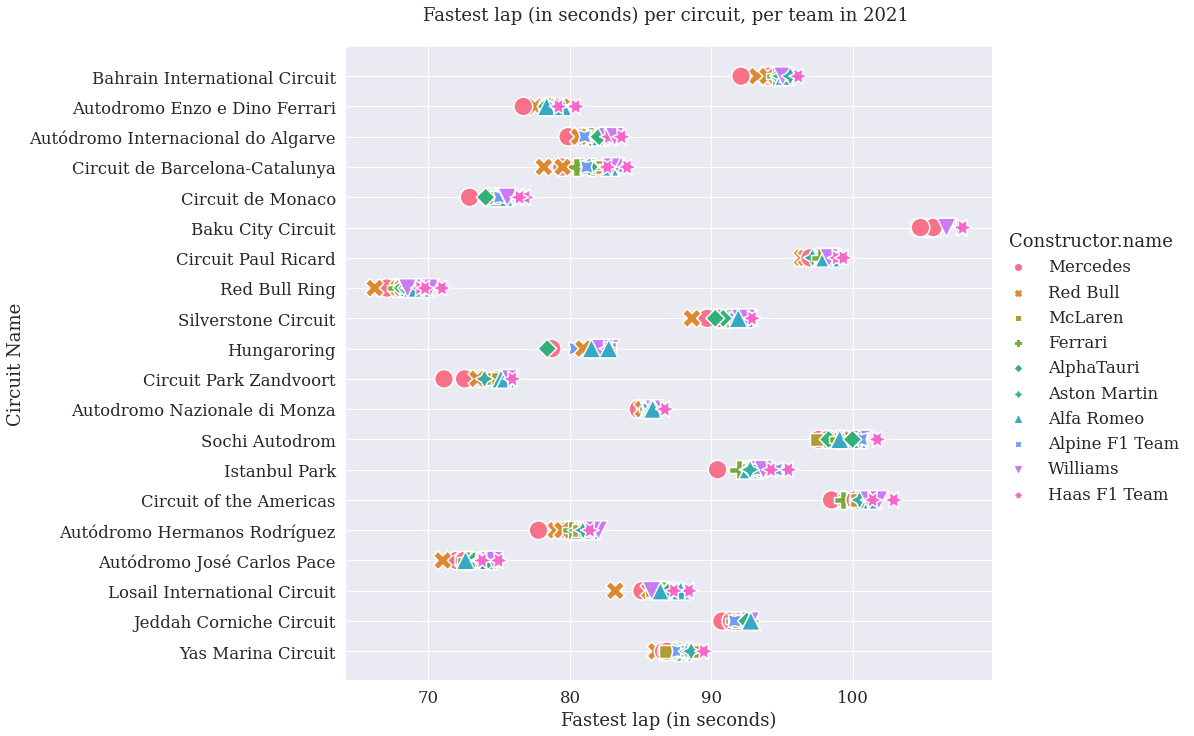

In [ ]:
sns.set_theme(style="darkgrid", palette="magma",font_scale=1.5,font="serif")

g = sns.relplot(x="FastestLap.Time.time_in_seconds", y='Circuit.circuitName',hue='Constructor.name',height=10,aspect=1.5,
        style='Constructor.name',s=350,data=ResultsDF[(ResultsDF["season"]==2021) & (ResultsDF["Completed"]=="Completed")])
(g.set_titles("Fastest lap (in seconds) per circuit, per team in 2021 \n").set_axis_labels("Fastest lap (in seconds)","Circuit Name"))
plt.title("Fastest lap (in seconds) per circuit, per team in 2021 \n")
# plt.xlabel("F1 Team")
# plt.ylabel("Fastest lap in seconds")


plt.show()


##### Time of entire race comparisson

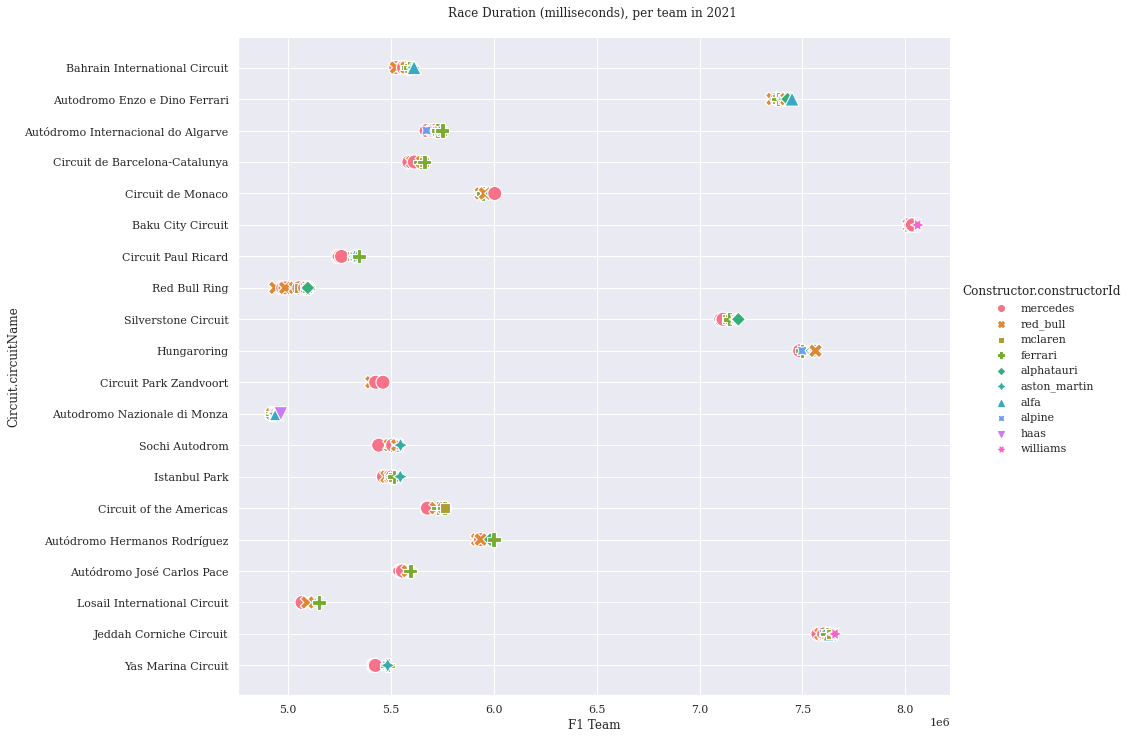

In [ ]:
sns.set_theme(style="darkgrid", palette="magma",font_scale=1,font="serif")

g = sns.relplot(x="Time.millis", y='Circuit.circuitName',hue='Constructor.constructorId',height=10,aspect=1.4,
        style='Constructor.constructorId',s=200,data=ResultsDF[(ResultsDF["season"]==2021) & (ResultsDF["status"]=="Finished")])
plt.title("Race Duration (milliseconds), per team in 2021 \n")
plt.xlabel("F1 Team")
# plt.ylabel("Fastest lap in seconds")


plt.show()

#### B. Number of wins and points and other statistics for drivers and teams

In [ ]:
#Datasets created for the analysis
PositionsPerDriver=pd.DataFrame({'Times' : ResultsDF[ResultsDF['position']<=3].groupby(['position','Driver.familyName',"season"])['position'].count()}).reset_index()
PositionsPerTeam=pd.DataFrame({'Times' : ResultsDF[ResultsDF['position']<=3].groupby(['position','Constructor.constructorId',"season"])['position'].count()}).reset_index()
GridPerDriver=pd.DataFrame({'Times' : ResultsDF[(ResultsDF['grid']==1) | (ResultsDF['grid']==2)].groupby(['grid','Driver.familyName',"season"])['position'].count()}).reset_index()
GridPerTeam=pd.DataFrame({'Times' : ResultsDF[(ResultsDF['grid']==1) | (ResultsDF['grid']==2)].groupby(['grid','Constructor.constructorId',"season"])['position'].count()}).reset_index()


##### Final positions in the podium per driver (2017-2021)

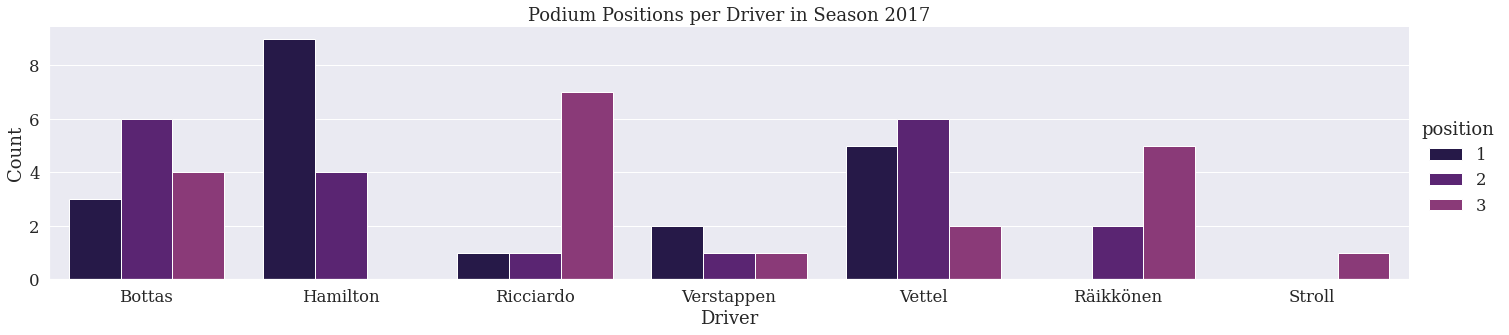

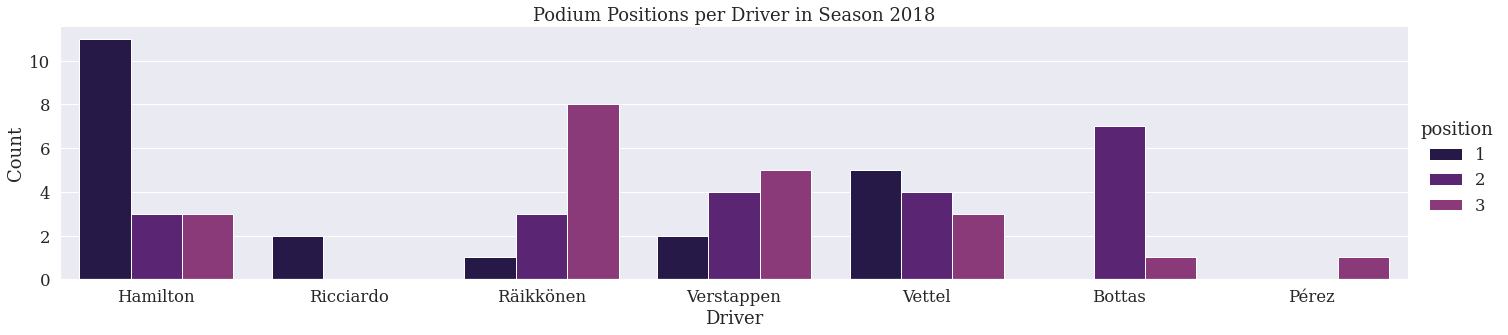

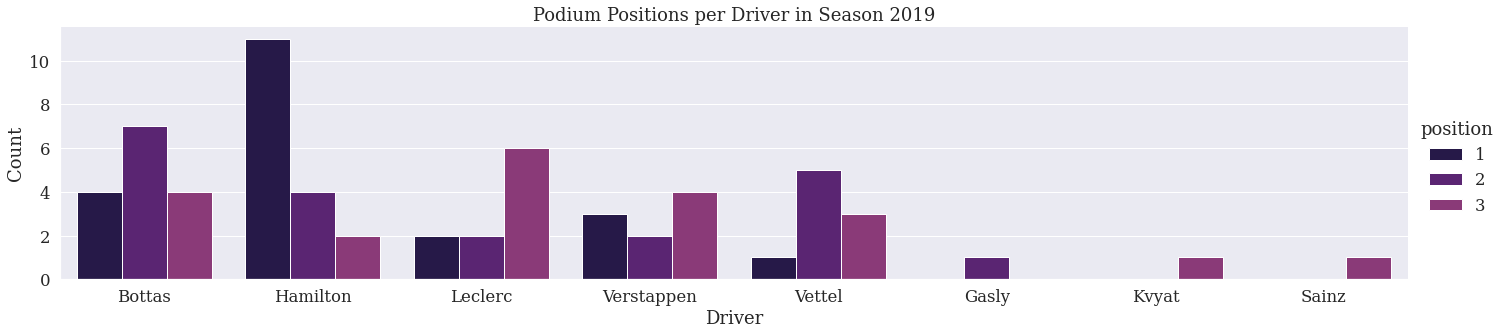

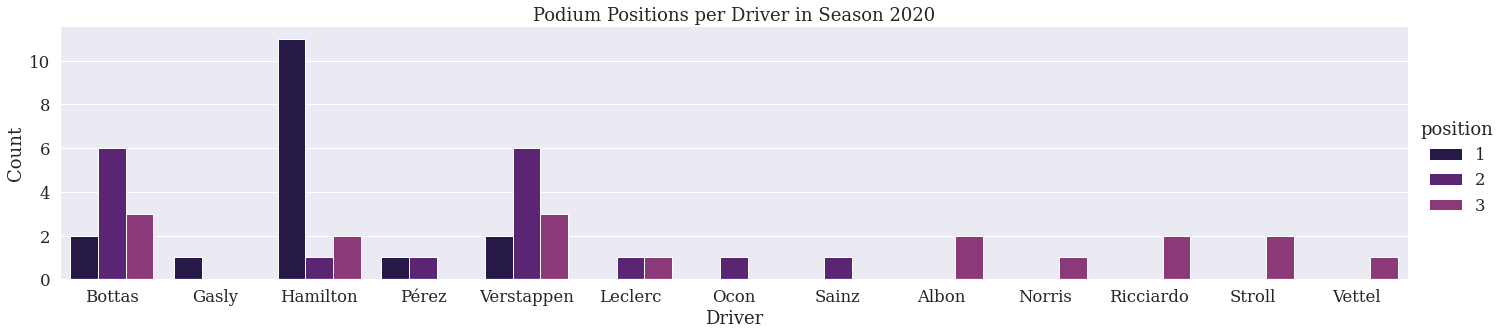

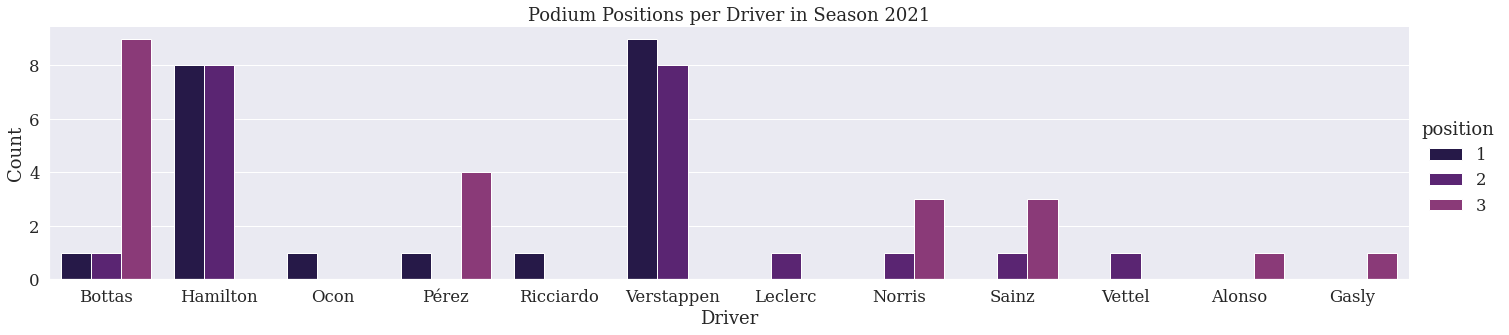

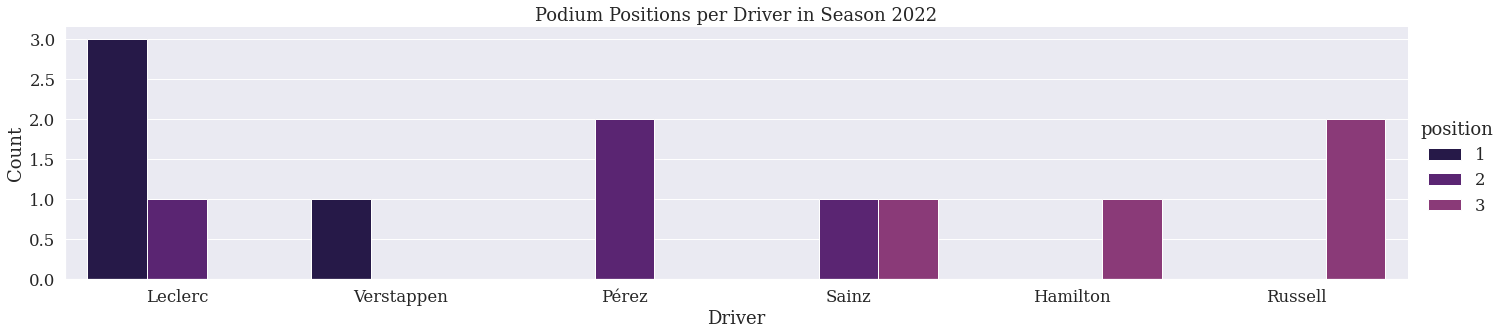

In [ ]:
#Ending in top 3 and counting how many times in each position per driver
sns.set_theme(style="darkgrid", palette="magma",font_scale=1.5,font="serif")

#Plot
for i in Years:
    if i<=2016:
        continue
    else:
        g = sns.catplot(x='Driver.familyName',y="Times", col="season",kind="bar",height=5,aspect=4,hue="position",
            data=PositionsPerDriver[PositionsPerDriver["season"]==i])
        g.set_titles(col_template="Podium Positions per Driver in Season {col_name}")
        g.set_axis_labels("Driver","Count")

plt.show()

##### Final positions in the podium per team (2017-2021)

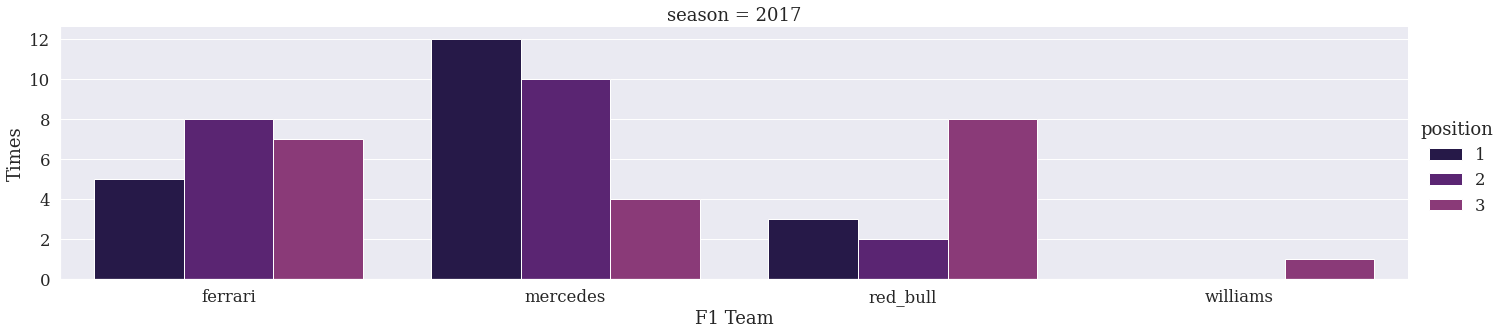

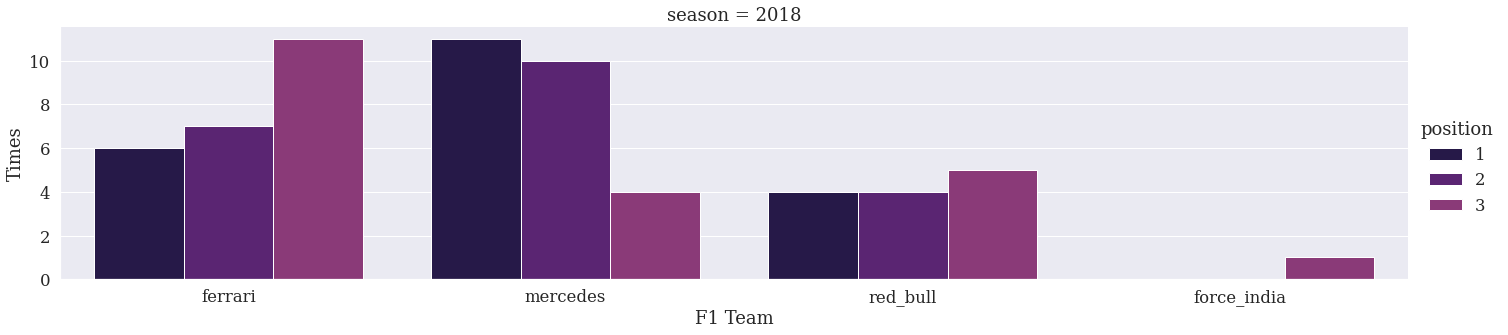

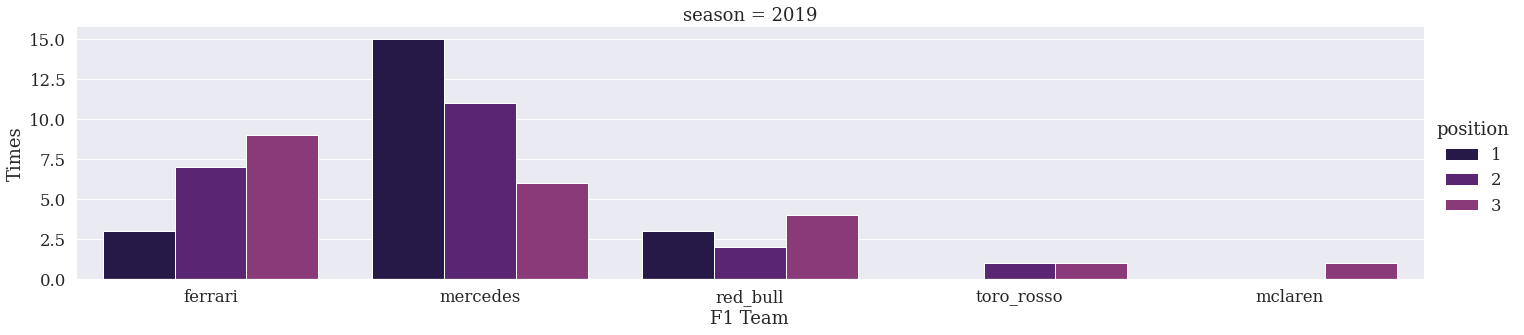

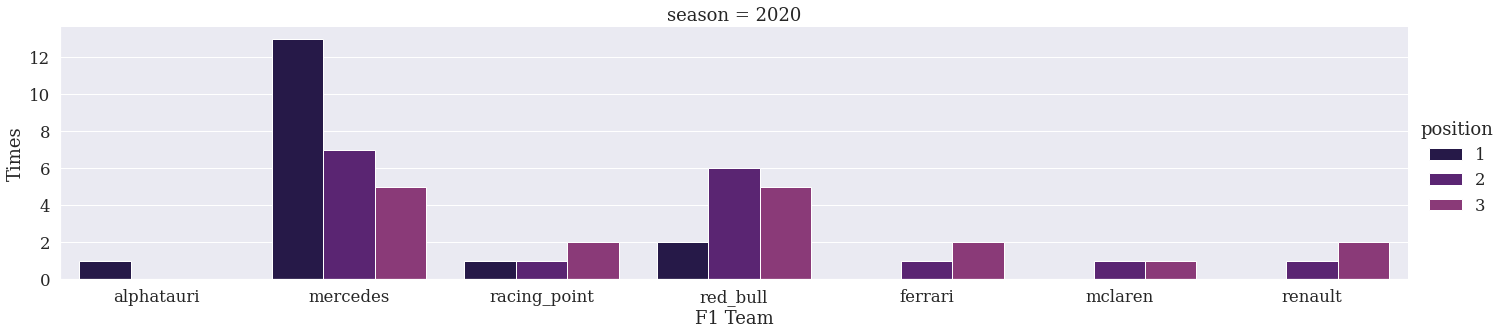

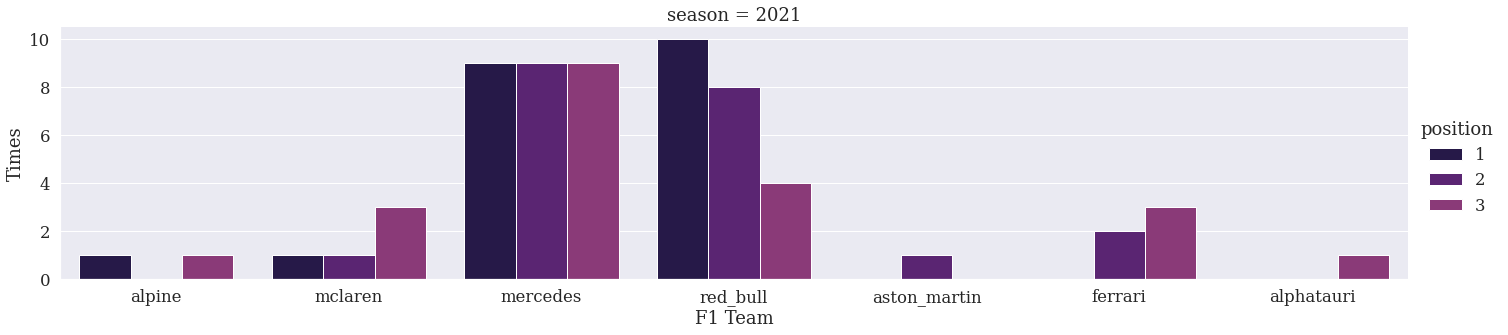

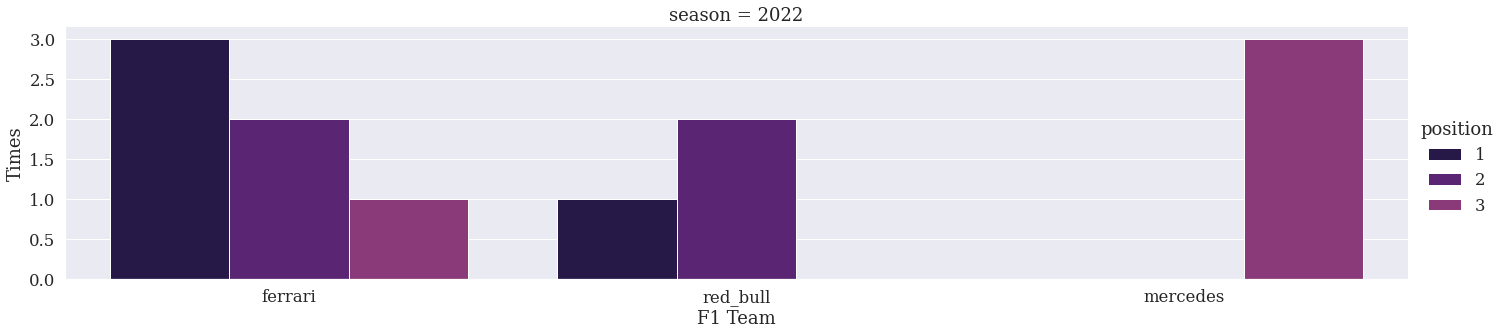

In [ ]:
#Ending in top 3 and counting how many times in each position per driver
sns.set_theme(style="darkgrid", palette="magma",font_scale=1.5,font="serif")

#Plot
for i in Years:
    if i<=2016:
        continue
    else:
        g = sns.catplot(x='Constructor.constructorId',y="Times", col="season",kind="bar",height=5,aspect=4,hue="position",
            data=PositionsPerTeam[PositionsPerTeam["season"]==i])
        plt.xlabel("F1 Team")
        # plt.ylabel("Times")


plt.show()

##### Starting the race in front row per driver (2017-2021)

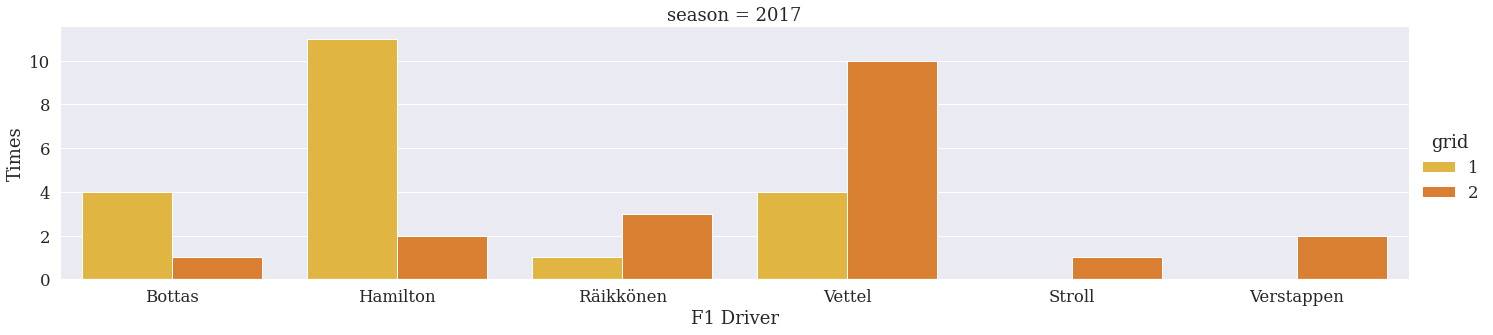

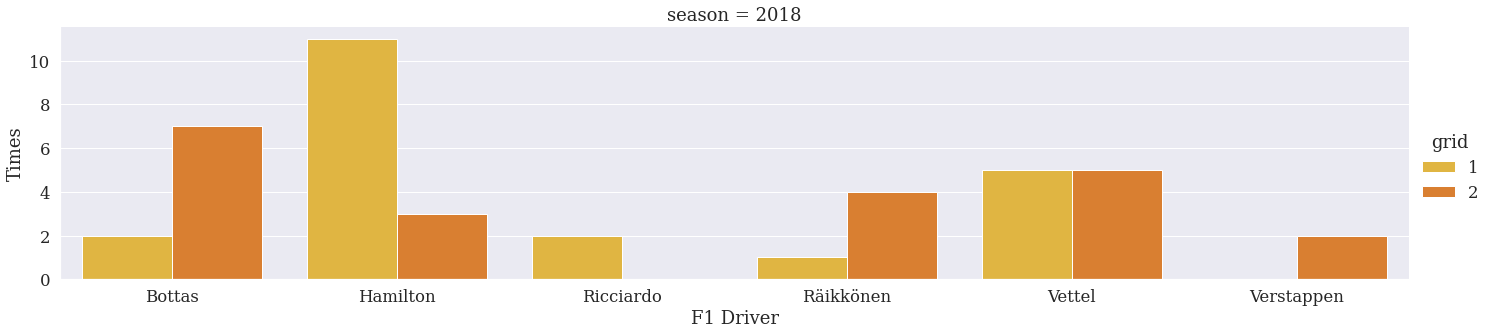

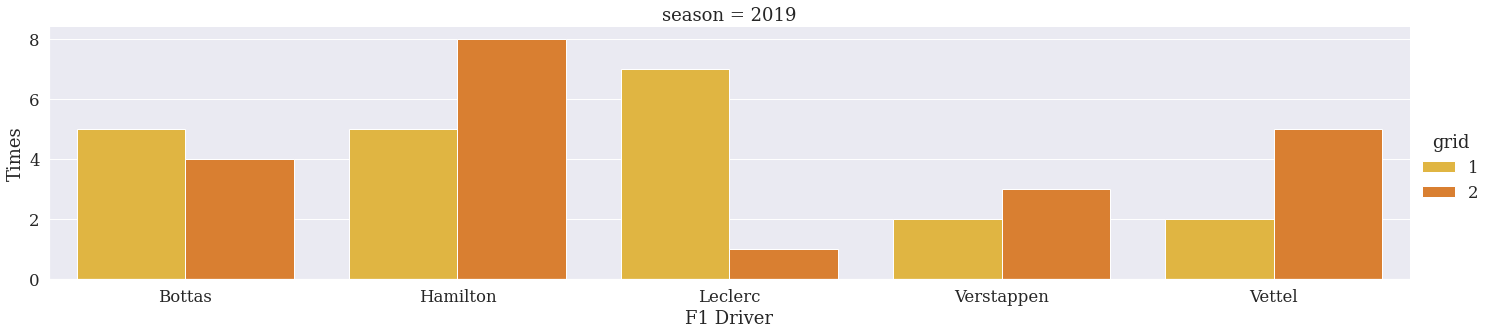

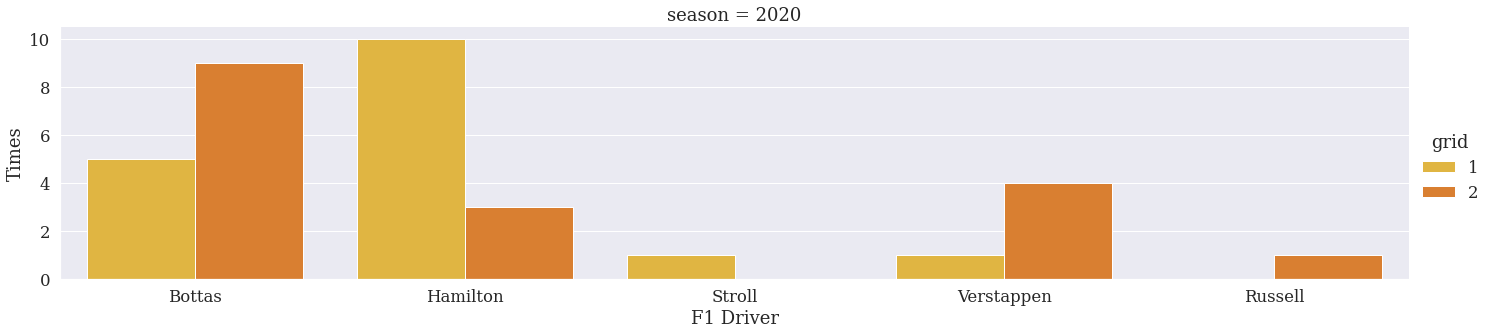

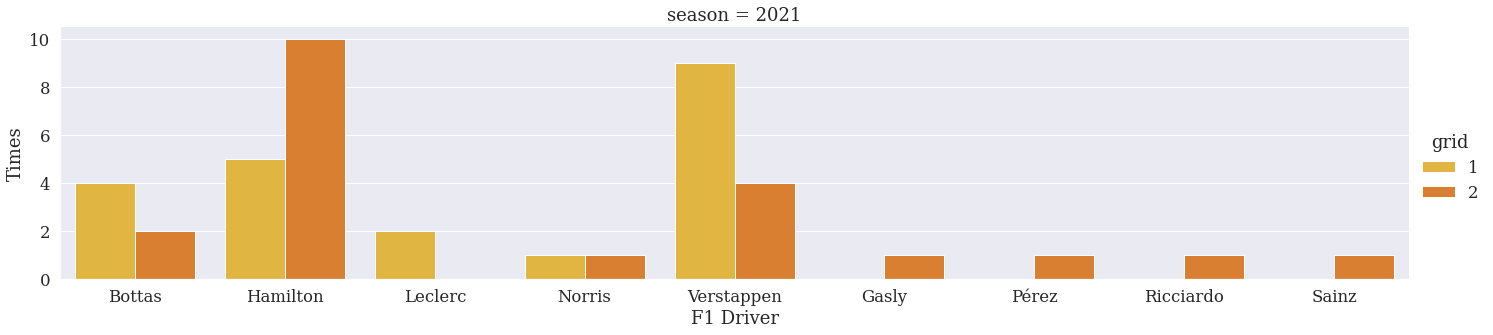

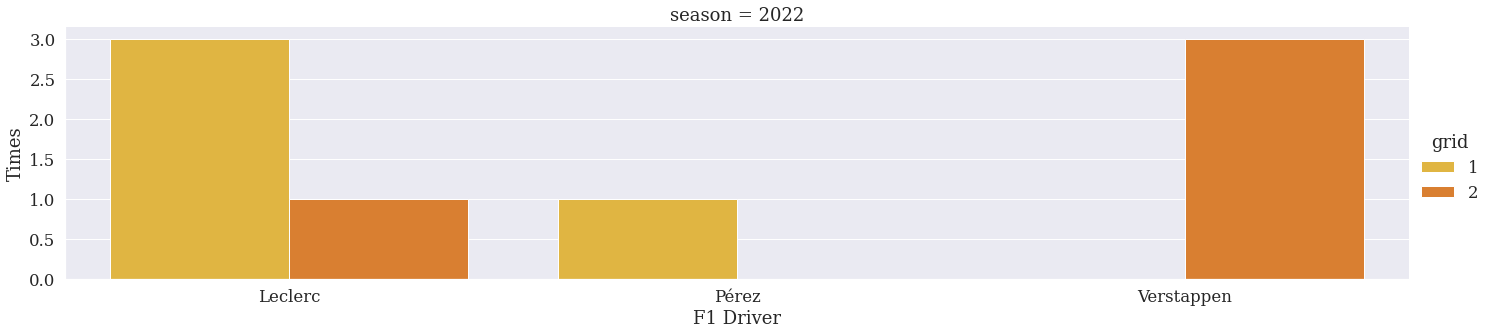

In [ ]:
#Front position per driver
sns.set_theme(style="darkgrid", palette="inferno_r",font_scale=1.5,font="serif")

#Plot
for i in Years:
    if i<=2016:
        continue
    else:
        g = sns.catplot(x='Driver.familyName',y="Times", col="season",kind="bar",height=5,aspect=4,hue="grid",
            data=GridPerDriver[GridPerDriver["season"]==i])
        plt.xlabel("F1 Driver")
        # plt.ylabel("Times")

plt.show()

##### Starting the race in front row per team (2017-2021)

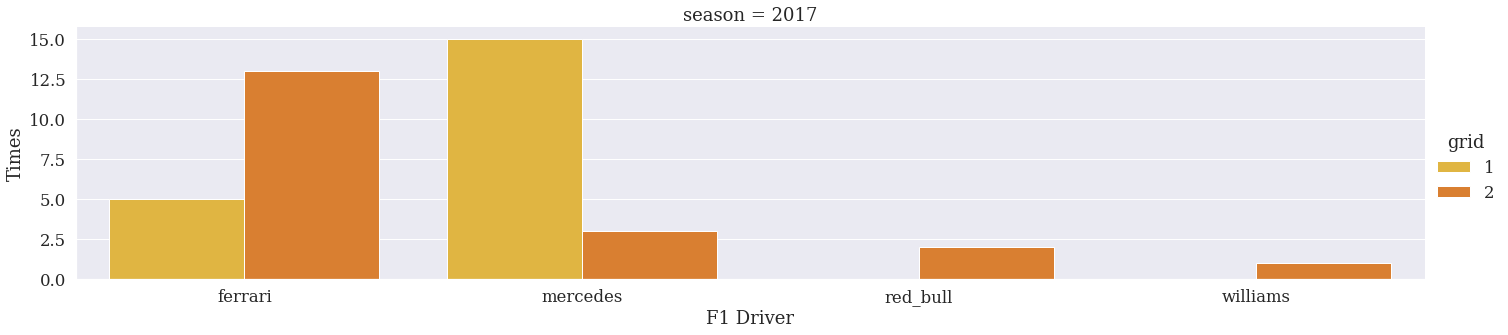

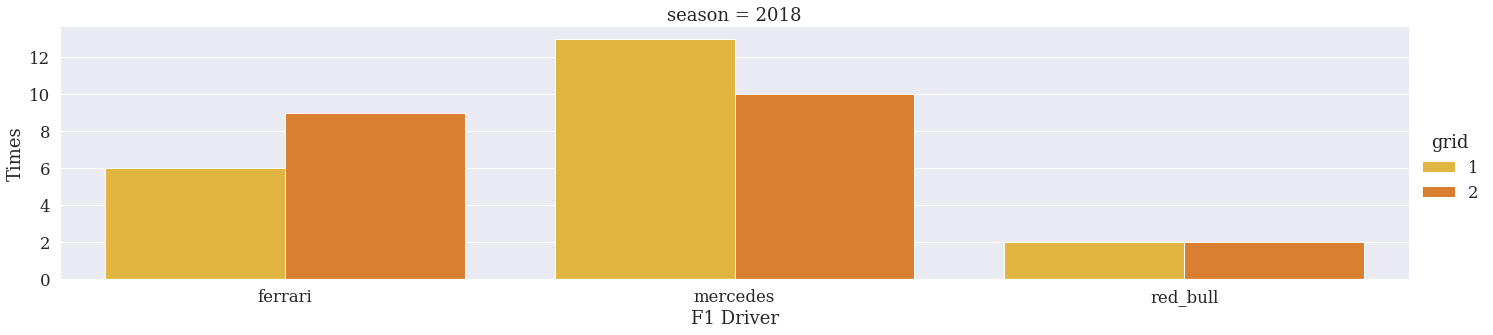

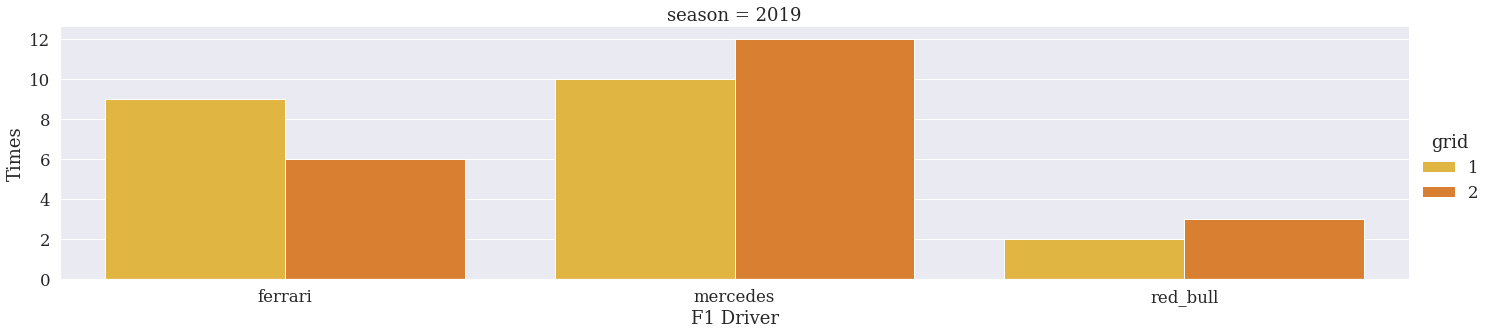

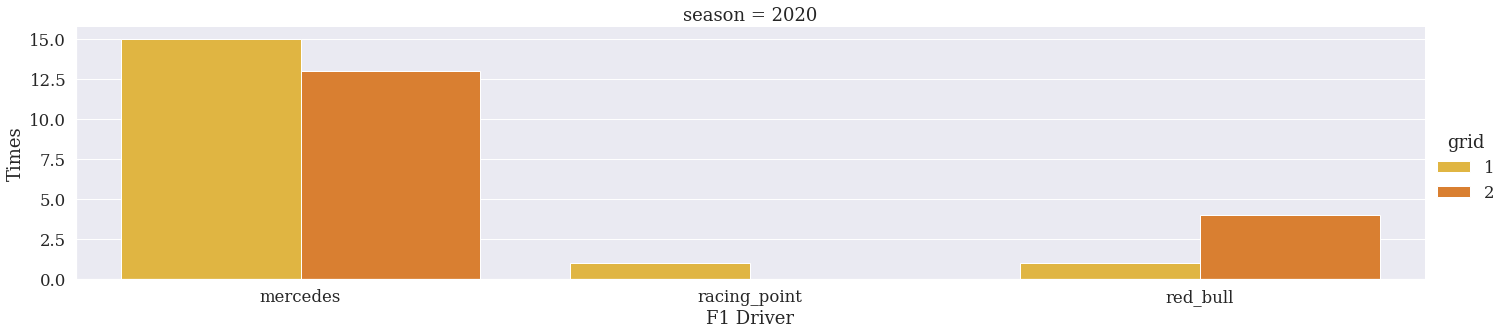

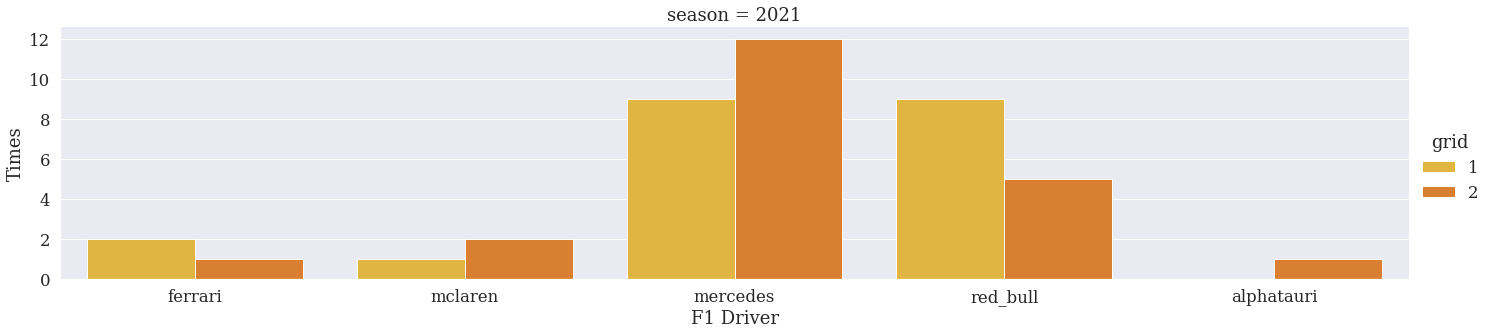

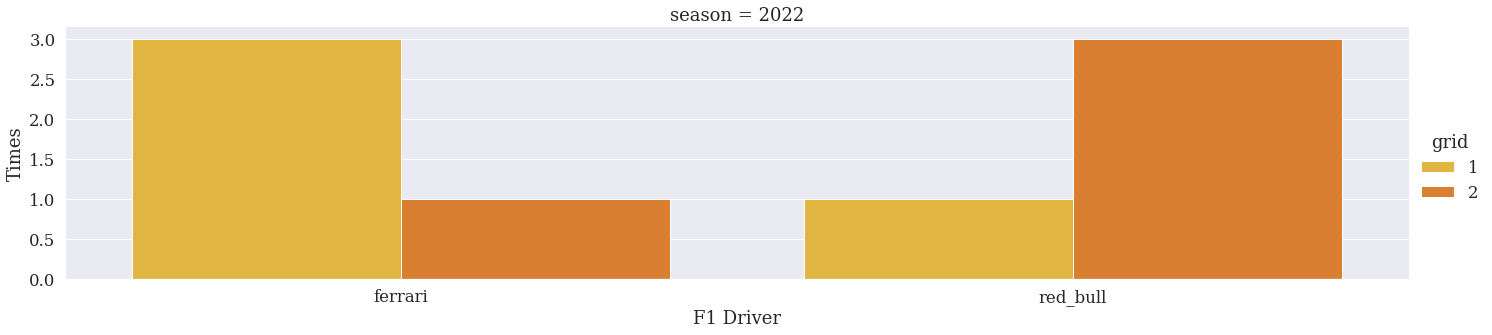

In [ ]:
#Front position per driver
sns.set_theme(style="darkgrid", palette="inferno_r",font_scale=1.5,font="serif")

#Plot
for i in Years:
    if i<=2016:
        continue
    else:
        g = sns.catplot(x='Constructor.constructorId',y="Times", col="season",kind="bar",height=5,aspect=4,hue="grid",
            data=GridPerTeam[GridPerTeam["season"]==i])
        plt.xlabel("F1 Driver")
        # plt.ylabel("Times")

plt.show()

#### C. Between this race and the last one

##### Final Position Vs Previous Final Position

Text(0.5, 1.0, 'Final Position: Actual Race vs. Previous Race (2017-2022)')

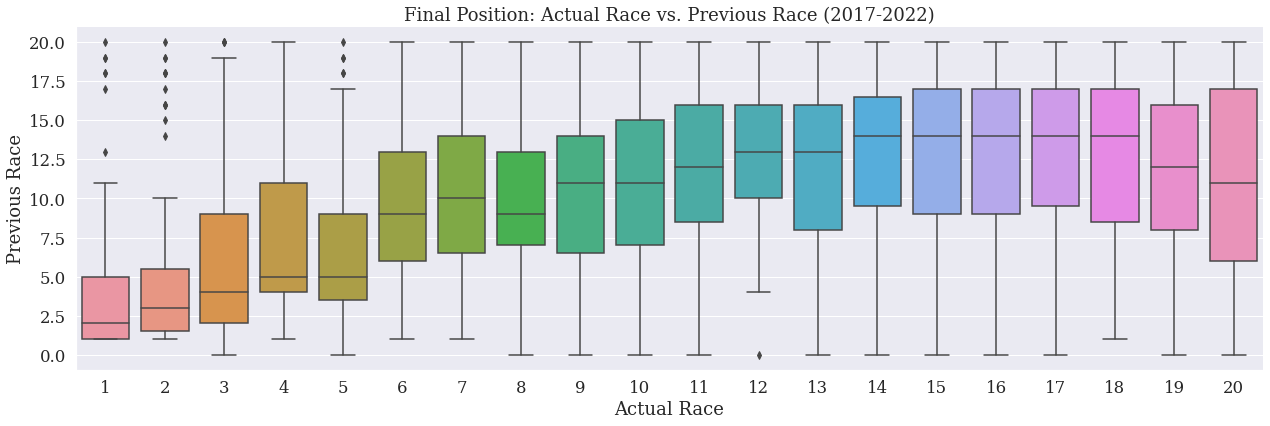

In [ ]:
g=sns.catplot(y="Prev_position_final_race",x='position_final_race', kind="box",data=SelectedResults[SelectedResults["season"]>2017],height=6,aspect=3)
g.set_axis_labels("Actual Race","Previous Race")
plt.title("Final Position: Actual Race vs. Previous Race (2017-2022)")

##### Grid vs Prev Grid

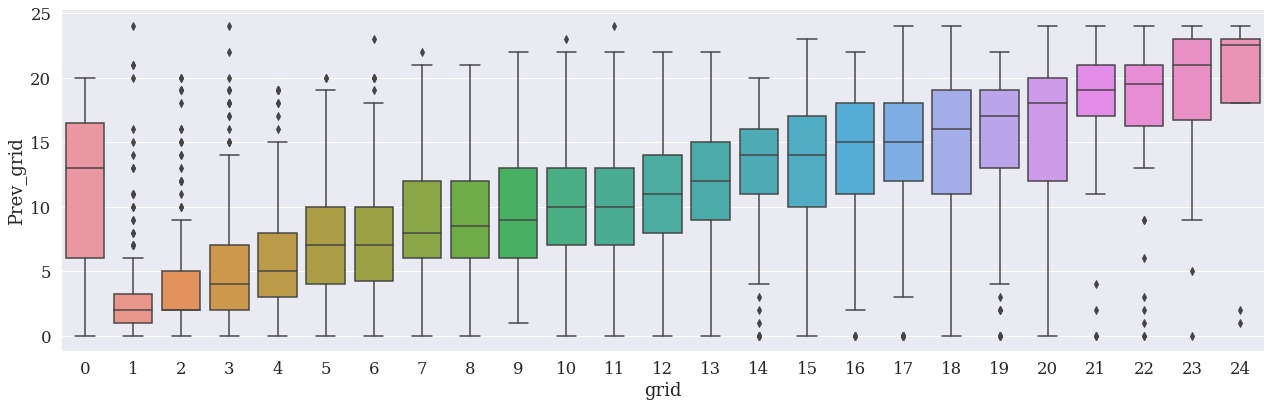

In [ ]:

sns.catplot(y="Prev_grid",x="grid", kind="box",data=SelectedResults[SelectedResults["Completed"]=="Completed"],height=6,aspect=3)

##### Final Position in the race vs Starting Grid

Text(0.5, 1.0, 'Starting Position vs. Final Position (2017-2022)')

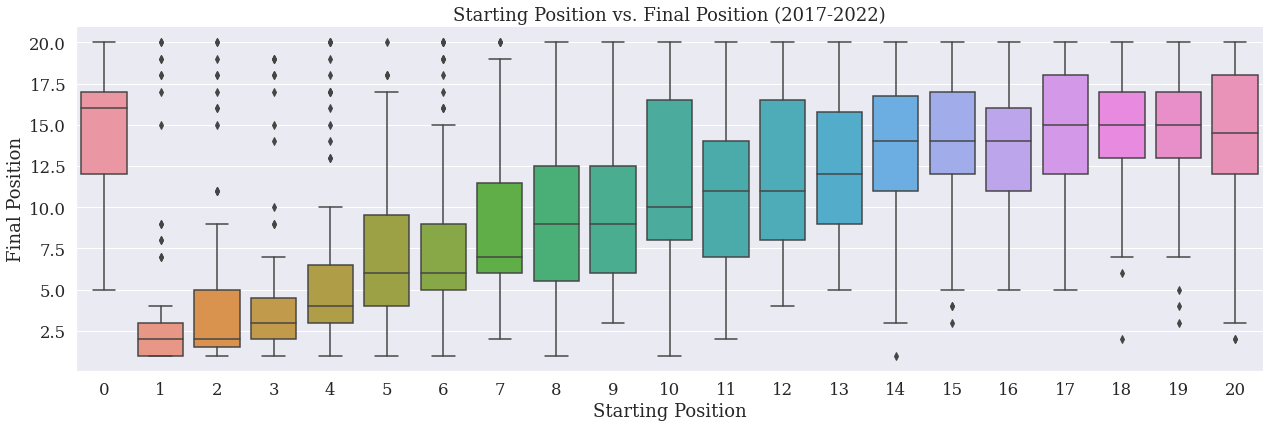

In [ ]:
g=sns.catplot(x='grid',y="position_final_race", kind="box",data=SelectedResults[SelectedResults["season"]>2017],height=6,aspect=3)
g.set_axis_labels("Starting Position","Final Position")
plt.title("Starting Position vs. Final Position (2017-2022)")

775

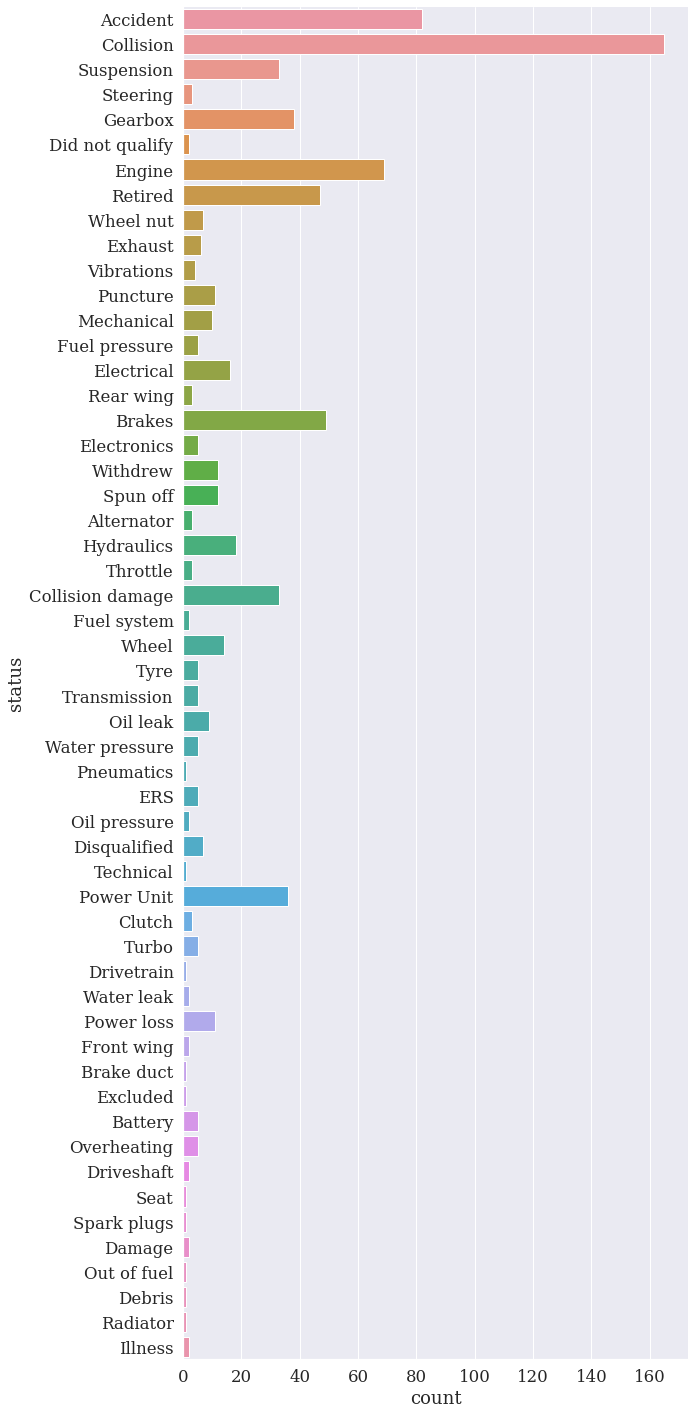

In [ ]:
g=sns.catplot(y="status", kind="count",data=SelectedResults[SelectedResults["Completed"]!="Completed"],height=20,aspect=0.5)
len(SelectedResults[SelectedResults["Completed"]!="Completed"]) #3430 out 775



## III. Random Forest Classifier

### Functions to test the scores:

In [ ]:
#Set scorers
f1_scorer=make_scorer(f1_score,average="weighted")
accuracy_scorer=make_scorer(accuracy_score)

### Function to test and evaluate the algorithms


def evaluating(y_train,y_train_predicted,y_test,y_test_predicted):
    y_true = y_train 
    y_pred = y_train_predicted 

    print("\n Training Scores:")
    print("Accuracy:",accuracy_score(y_true, y_pred))
    print("F1 Score:",f1_score(y_true, y_pred,average="weighted"))
    print("Recall:",recall_score(y_true,y_pred,average="weighted"))
    print("Precision:",precision_score(y_true,y_pred,average="weighted"))

    y_true = y_test 
    y_pred = y_test_predicted 
    
    print("\n Testing Scores:")
    print("Accuracy:",accuracy_score(y_true, y_pred))
    print("F1 Score:",f1_score(y_true, y_pred,average="weighted"))
    print("Recall:",recall_score(y_true,y_pred,average="weighted"))
    print("Precision:",precision_score(y_true,y_pred,average="weighted"))

In [ ]:
### Function to test and evaluate the algorithms
def testing_the_classifier(tickstrain,tickstest,thesize=(10,10),f=1):
    Train=pd.DataFrame()
    Train["Predicted"]=y_train_predicted
    Train["Real"]=y_train.tolist()

    Test=pd.DataFrame()
    Test["Predicted"]=y_test_predicted
    Test["Real"]=y_test.tolist()

    #Generate the confusion matrixes

    cf_matrixtrain = confusion_matrix(Train["Real"], Train["Predicted"])
    cf_matrixtest = confusion_matrix(Test["Real"], Test["Predicted"])

    print("\n Training Data:")
    sns.set_theme(style="whitegrid", palette="BuPu",font_scale=f,font="serif")
    plt.figure(figsize=thesize)
    ax = sns.heatmap(cf_matrixtrain, annot=True,cmap="BuPu",fmt='d')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    ax.xaxis.set_ticklabels(tickstrain)
    ax.yaxis.set_ticklabels(tickstrain)
    plt.show()

    print(classification_report(y_train, y_train_predicted))
    

    print("\n Testing Data:")
    sns.set_theme(style="whitegrid", palette="BuPu",font_scale=f,font="serif")
    plt.figure(figsize=thesize)
    ax = sns.heatmap(cf_matrixtest, annot=True,cmap="BuPu",fmt='d')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    ax.xaxis.set_ticklabels(tickstest)
    ax.yaxis.set_ticklabels(tickstest)
    plt.show()

    print(classification_report(y_test, y_test_predicted))


In [ ]:
# FUnction for pca

def pcacreation(features,n,labels):
  #The Selected features are standardized
  scaler = StandardScaler()
  scaler.fit(ResultsExpandedDF[features]) #Scaler is fitted
  F1_standardized = pd.DataFrame(scaler.transform(ResultsExpandedDF[features]), columns=features) 

  #PCA is defined
  pca = PCA(n_components=n) # n PCA's
  Components = pca.fit_transform(F1_standardized) 
  ComponentsDF=pd.DataFrame(data=Components, columns=labels)

  #Explained variances of each PC
  explained_variances = pca.explained_variance_ratio_
  explained_variances_cumulative=np.cumsum(pca.explained_variance_ratio_)
  explained_variancesDF=pd.DataFrame({"PC":labels,"Ex Var":explained_variances,"Ex Var Cumulative":explained_variances_cumulative})
  explained_variancesDF #Explained variances in dataframe form

  #Explained Variance plot
  sns.set_theme(style="whitegrid", palette="magma",font_scale=1.3,font="serif")
  fig, ax = plt.subplots(figsize=(10, 5))
  ax=sns.barplot(x="PC",y="Ex Var",data=explained_variancesDF)
  ax.set(ylabel="Explained Variance",
        xlabel="Principal Components")
  plt.show()

  return ComponentsDF,explained_variancesDF

### Creating the dataframes

In [ ]:
#Stracting the dataframe wanted according to the scenario analysed
ResultsExpandedDF=createResultsExpanded(0.5,20) #percentile of laps passed,#previous laps

#Filling the prev status with "not spcified"
ResultsExpandedDF['Prev_status']=ResultsExpandedDF['Prev_status'].replace(0,"Not Specified")

#Encoding the label
status_encoder = LabelEncoder()
status_encoder.fit(ResultsExpandedDF['Prev_status'])
status_values=status_encoder.transform(ResultsExpandedDF['Prev_status'])
ResultsExpandedDF['Prev_status_encoded']=status_values

### Principal Component Analysis

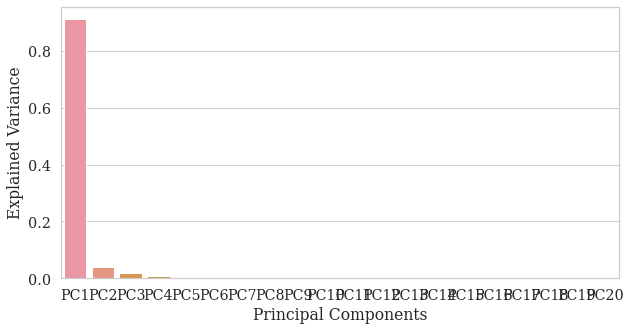

      PC    Ex Var  Ex Var Cumulative
0    PC1  0.911036           0.911036
1    PC2  0.038376           0.949412
2    PC3  0.018897           0.968309
3    PC4  0.009099           0.977408
4    PC5  0.005487           0.982894
5    PC6  0.003822           0.986716
6    PC7  0.002822           0.989538
7    PC8  0.001919           0.991457
8    PC9  0.001526           0.992983
9   PC10  0.001204           0.994187
10  PC11  0.001043           0.995230
11  PC12  0.000836           0.996066
12  PC13  0.000733           0.996799
13  PC14  0.000608           0.997407
14  PC15  0.000578           0.997986
15  PC16  0.000474           0.998460
16  PC17  0.000433           0.998894
17  PC18  0.000425           0.999319
18  PC19  0.000383           0.999702
19  PC20  0.000298           1.000000


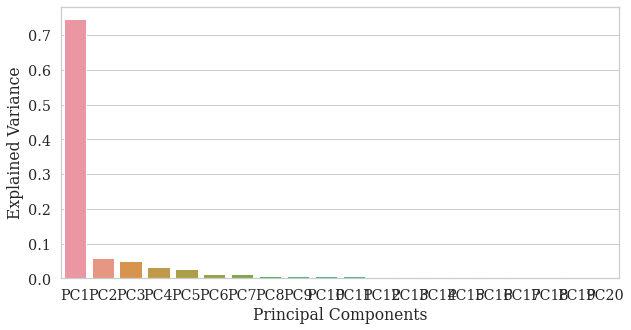

      PC    Ex Var  Ex Var Cumulative
0    PC1  0.745258           0.745258
1    PC2  0.059035           0.804293
2    PC3  0.051225           0.855519
3    PC4  0.032411           0.887929
4    PC5  0.026997           0.914926
5    PC6  0.013406           0.928332
6    PC7  0.011875           0.940207
7    PC8  0.007676           0.947883
8    PC9  0.007608           0.955491
9   PC10  0.006645           0.962135
10  PC11  0.005641           0.967776
11  PC12  0.004638           0.972414
12  PC13  0.004400           0.976814
13  PC14  0.004240           0.981054
14  PC15  0.003941           0.984995
15  PC16  0.003801           0.988796
16  PC17  0.003243           0.992039
17  PC18  0.002857           0.994896
18  PC19  0.002802           0.997697
19  PC20  0.002303           1.000000


In [ ]:
#Depending on the scenario chose comment one of the following two options

#start 50%
features1=['position_1', 'position_2', 'position_3', 'position_4', 'position_5',
       'position_6', 'position_7', 'position_8', 'position_9', 'position_10',
       'position_11', 'position_12', 'position_13', 'position_14', 'position_15',
       'position_16', 'position_17', 'position_18', 'position_19', 'position_20']
features2=['lap_1_duration_secs', 'lap_2_duration_secs', 'lap_3_duration_secs',
       'lap_4_duration_secs', 'lap_5_duration_secs','lap_6_duration_secs', 'lap_7_duration_secs', 'lap_8_duration_secs',
       'lap_9_duration_secs', 'lap_10_duration_secs','lap_11_duration_secs', 'lap_12_duration_secs', 'lap_13_duration_secs',
       'lap_14_duration_secs', 'lap_15_duration_secs','lap_16_duration_secs', 'lap_17_duration_secs', 'lap_18_duration_secs',
       'lap_19_duration_secs', 'lap_20_duration_secs']
n=20
labels=["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10","PC11","PC12","PC13","PC14","PC15","PC16","PC17","PC18","PC19","PC20"]
#end 50%

# #start 25%
# features1=['position_1', 'position_2', 'position_3', 'position_4', 'position_5','position_6', 'position_7', 'position_8', 'position_9', 'position_10']
# features2=['lap_1_duration_secs', 'lap_2_duration_secs', 'lap_3_duration_secs',
#        'lap_4_duration_secs', 'lap_5_duration_secs','lap_6_duration_secs', 'lap_7_duration_secs', 'lap_8_duration_secs',
#        'lap_9_duration_secs', 'lap_10_duration_secs']
# n=10
# labels=["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10"]
# ResultsExpandedDF=ResultsExpandedDF[ResultsExpandedDF["position_10"].isna()==False].reset_index()
# ResultsExpandedDF=ResultsExpandedDF.drop(columns=["index"])
# #end 25%

components_pos,pca_positions=pcacreation(features1,n,labels)
print(pca_positions)
components_laps,pca_laps=pcacreation(features2,n,labels)
print(pca_laps)


In [ ]:
# #Adding the PC to the dataframe (comment if the number of pc needed is less)
# ResultsExpandedDF["PC1_Position"]=components_pos["PC1"]
# ResultsExpandedDF["PC2_Position"]=components_pos["PC2"]
# ResultsExpandedDF["PC3_Position"]=components_pos["PC3"]
# ResultsExpandedDF["PC4_Position"]=components_pos["PC4"]
# ResultsExpandedDF["PC5_Position"]=components_pos["PC5"]
# ResultsExpandedDF["PC6_Position"]=components_pos["PC6"]
# ResultsExpandedDF["PC7_Position"]=components_pos["PC7"]
# ResultsExpandedDF["PC8_Position"]=components_pos["PC8"]

# ResultsExpandedDF["PC1_LD"]=components_laps["PC1"]
# ResultsExpandedDF["PC2_LD"]=components_laps["PC2"]
# ResultsExpandedDF["PC3_LD"]=components_laps["PC3"]
# ResultsExpandedDF["PC4_LD"]=components_laps["PC4"]
# ResultsExpandedDF["PC5_LD"]=components_laps["PC5"]
# ResultsExpandedDF["PC6_LD"]=components_laps["PC6"]
# ResultsExpandedDF["PC7_LD"]=components_laps["PC7"]
# ResultsExpandedDF["PC8_LD"]=components_laps["PC8"]
# ResultsExpandedDF["PC9_LD"]=components_laps["PC9"]
# ResultsExpandedDF["PC10_LD"]=components_laps["PC10"]
# ResultsExpandedDF["PC11_LD"]=components_laps["PC11"]
# ResultsExpandedDF["PC12_LD"]=components_laps["PC12"]
# ResultsExpandedDF["PC13_LD"]=components_laps["PC13"]
# ResultsExpandedDF["PC14_LD"]=components_laps["PC14"]
# ResultsExpandedDF["PC15_LD"]=components_laps["PC15"]
# ResultsExpandedDF["PC16_LD"]=components_laps["PC16"]
# ResultsExpandedDF["PC17_LD"]=components_laps["PC17"]



### Features Selected

In [ ]:
#Features not used for various reasons (explained in the names)
cannot_take_into_account=['status','Time.millis','FastestLap.rank','FastestLap.lap',"points",
                            'FastestLap.Time.time_in_seconds','FastestLap.AverageSpeed.speedKph'] #7

encodedfeatures=['driverId','Circuit.circuitId','Constructor.constructorId','Prev_status'] #4

not_useful=['Season-Round','Season-Round-DriverID','Driver.nationality','Constructor.nationality',"Completed"] #5

Comment or uncomment depending on the scenario analysed

In [ ]:
# SCENARIO 3: WHEN WE MAKE A PREDICTION BEFORE THE RACE STARTS
cont=['position_final_race','Prev_Time.millis','Prev_FastestLap.Time.time_in_seconds',
       "Q1_in_seconds","Q2_in_seconds","Q3_in_seconds",
       'Prev_FastestLap.AverageSpeed.speedKph',
       'Fastest_per_driver', 'Fastest_per_race']
cat=['position_final_race','grid', 'laps_total_race','season', 'round','driverId_encoded',
       'Constructor.constructorId_encoded', 'Circuit.circuitId_encoded',
       'Prev_position_final_race', 'Prev_grid',
       'Prev_FastestLap.rank', 'Prev_FastestLap.lap','laps_considered','Prev_status_encoded'] #,"Podium"

print(len(cannot_take_into_account)+len(encodedfeatures)+len(not_useful)+len(cat)+len(cont)-1)
print(len(ResultsExpandedDF.columns))

united=np.concatenate([cat,cont[1:]])



38
39


In [ ]:
# SCENARIO 2: WHEN WE PREDICT FROM THE 25% OF THE RACE WITH 10 PREV LAPS

cont=['position_final_race','Prev_Time.millis','Prev_FastestLap.Time.time_in_seconds',
       "Q1_in_seconds","Q2_in_seconds","Q3_in_seconds",
       'Prev_FastestLap.AverageSpeed.speedKph',
       'Fastest_per_driver', 'Fastest_per_race','lap_1_duration_secs', 'lap_2_duration_secs', 'lap_3_duration_secs',
       'lap_4_duration_secs', 'lap_5_duration_secs','lap_6_duration_secs', 'lap_7_duration_secs', 'lap_8_duration_secs',
       'lap_9_duration_secs', 'lap_10_duration_secs']
cat=['position_final_race','grid', 'laps_total_race','season', 'round','driverId_encoded',
       'Constructor.constructorId_encoded', 'Circuit.circuitId_encoded',
       'Prev_position_final_race', 'Prev_grid',
       'Prev_FastestLap.rank', 'Prev_FastestLap.lap','laps_considered', 'Prev_status_encoded',
       'position_1', 'position_2', 'position_3', 'position_4', 'position_5',
       'position_6', 'position_7', 'position_8', 'position_9', 'position_10'] #,"Podium"

pc=["PC1_Position","PC2_Position","PC3_Position", 'PC4_Position', 'PC5_Position','PC1_LD', 'PC2_LD',
       'PC3_LD', 'PC4_LD', 'PC5_LD', 'PC6_LD', 'PC7_LD', 'PC8_LD']

ResultsExpandedDF=ResultsExpandedDF[ResultsExpandedDF["position_10"].isna()==False].reset_index()
ResultsExpandedDF=ResultsExpandedDF.drop(columns=["index"])

cont_new=np.concatenate([cont[:-10],pc[5:]])
cat_new=np.concatenate([cat[:-10],pc[:-8]])

print(len(cannot_take_into_account)+len(encodedfeatures)+len(not_useful)+len(cat)+len(cont)-1+len(pc))
print(len(ResultsExpandedDF.columns))

united=np.concatenate([cat,cont[1:]])
unitedpca=np.concatenate([cat[:-10],cont[1:-10],pc])




71
59


In [ ]:
# SCENARIO 1: WHEN WE PREDICT FROM THE 50% OF THE RACE WITH 20 PREV LAPS

cont=['position_final_race','Prev_Time.millis','Prev_FastestLap.Time.time_in_seconds',
       "Q1_in_seconds","Q2_in_seconds","Q3_in_seconds",
       'Prev_FastestLap.AverageSpeed.speedKph',
       'Fastest_per_driver', 'Fastest_per_race','lap_1_duration_secs', 'lap_2_duration_secs', 'lap_3_duration_secs',
       'lap_4_duration_secs', 'lap_5_duration_secs','lap_6_duration_secs', 'lap_7_duration_secs', 'lap_8_duration_secs',
       'lap_9_duration_secs', 'lap_10_duration_secs','lap_11_duration_secs', 'lap_12_duration_secs', 'lap_13_duration_secs',
       'lap_14_duration_secs', 'lap_15_duration_secs','lap_16_duration_secs', 'lap_17_duration_secs', 'lap_18_duration_secs',
       'lap_19_duration_secs', 'lap_20_duration_secs']
cat=['position_final_race','grid', 'laps_total_race','season', 'round','driverId_encoded',
       'Constructor.constructorId_encoded', 'Circuit.circuitId_encoded',
       'Prev_position_final_race', 'Prev_grid',
       'Prev_FastestLap.rank', 'Prev_FastestLap.lap','laps_considered', 'Prev_status_encoded',
       'position_1', 'position_2', 'position_3', 'position_4', 'position_5',
       'position_6', 'position_7', 'position_8', 'position_9', 'position_10',
       'position_11', 'position_12', 'position_13', 'position_14', 'position_15',
       'position_16', 'position_17', 'position_18', 'position_19', 'position_20'] #,"Podium"

pc=["PC1_Position","PC2_Position","PC3_Position", 'PC4_Position', 'PC5_Position',"PC6_Position", 'PC7_Position', 'PC8_Position','PC1_LD', 'PC2_LD',
       'PC3_LD', 'PC4_LD', 'PC5_LD', 'PC6_LD', 'PC7_LD', 'PC8_LD',
        'PC9_LD', 'PC10_LD', 'PC11_LD', 'PC12_LD', 'PC13_LD',
       'PC14_LD', 'PC15_LD', 'PC16_LD', 'PC17_LD']

cont_new=np.concatenate([cont[:-20],pc[8:]])
cat_new=np.concatenate([cat[:-20],pc[:-17]])

print(len(cannot_take_into_account)+len(encodedfeatures)+len(not_useful)+len(cat)+len(cont)-1+len(pc))
print(len(ResultsExpandedDF.columns))

united=np.concatenate([cat,cont[1:]])
unitedpca=np.concatenate([cat[:-20],cont[1:-20],pc])




103
79


### Correlation between the features

In [ ]:
#ResultsExpandedDF[cont].corr(method='pearson')["position_final_race"]
ResultsExpandedDF[cat].corr(method='kendall')["position_final_race"]

position_final_race                  1.000000
grid                                 0.607952
laps_total_race                     -0.066634
season                              -0.041319
round                                0.016892
driverId_encoded                    -0.031394
Constructor.constructorId_encoded    0.028912
Circuit.circuitId_encoded            0.018672
Prev_position_final_race             0.399094
Prev_grid                            0.461716
Prev_FastestLap.rank                 0.383294
Prev_FastestLap.lap                 -0.062305
laps_considered                     -0.002147
Prev_status_encoded                 -0.233885
position_1                           0.753619
position_2                           0.746679
position_3                           0.741493
position_4                           0.737620
position_5                           0.730973
position_6                           0.727390
position_7                           0.722908
position_8                        

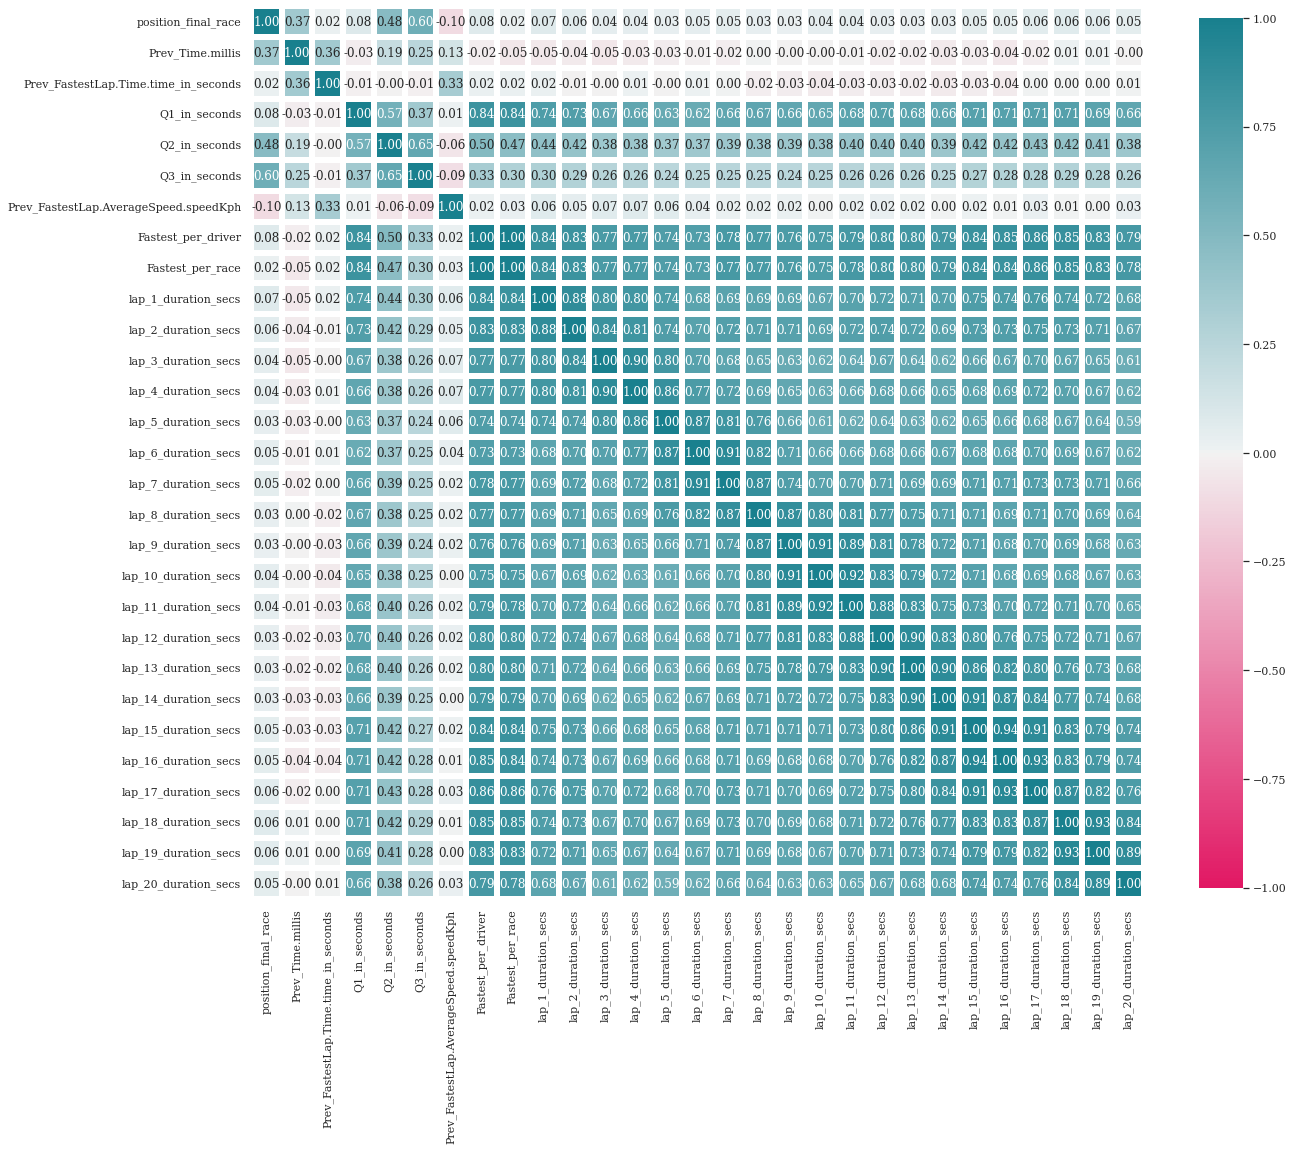

In [ ]:
#Calculating correlation: Heatmap
sns.set_theme(style="whitegrid", palette="magma",font_scale=1,font="serif")
fig, ax = plt.subplots(figsize=(20,20))
cmap = sns.diverging_palette(0, 210, 95, 49, as_cmap=True)
sns.heatmap(ResultsExpandedDF[cont].corr(method='pearson'), annot=True, fmt=".2f", 
           linewidths=5,cmap=cmap, vmin=-1, vmax=1, 
           cbar_kws={"shrink": .8}, square=True)

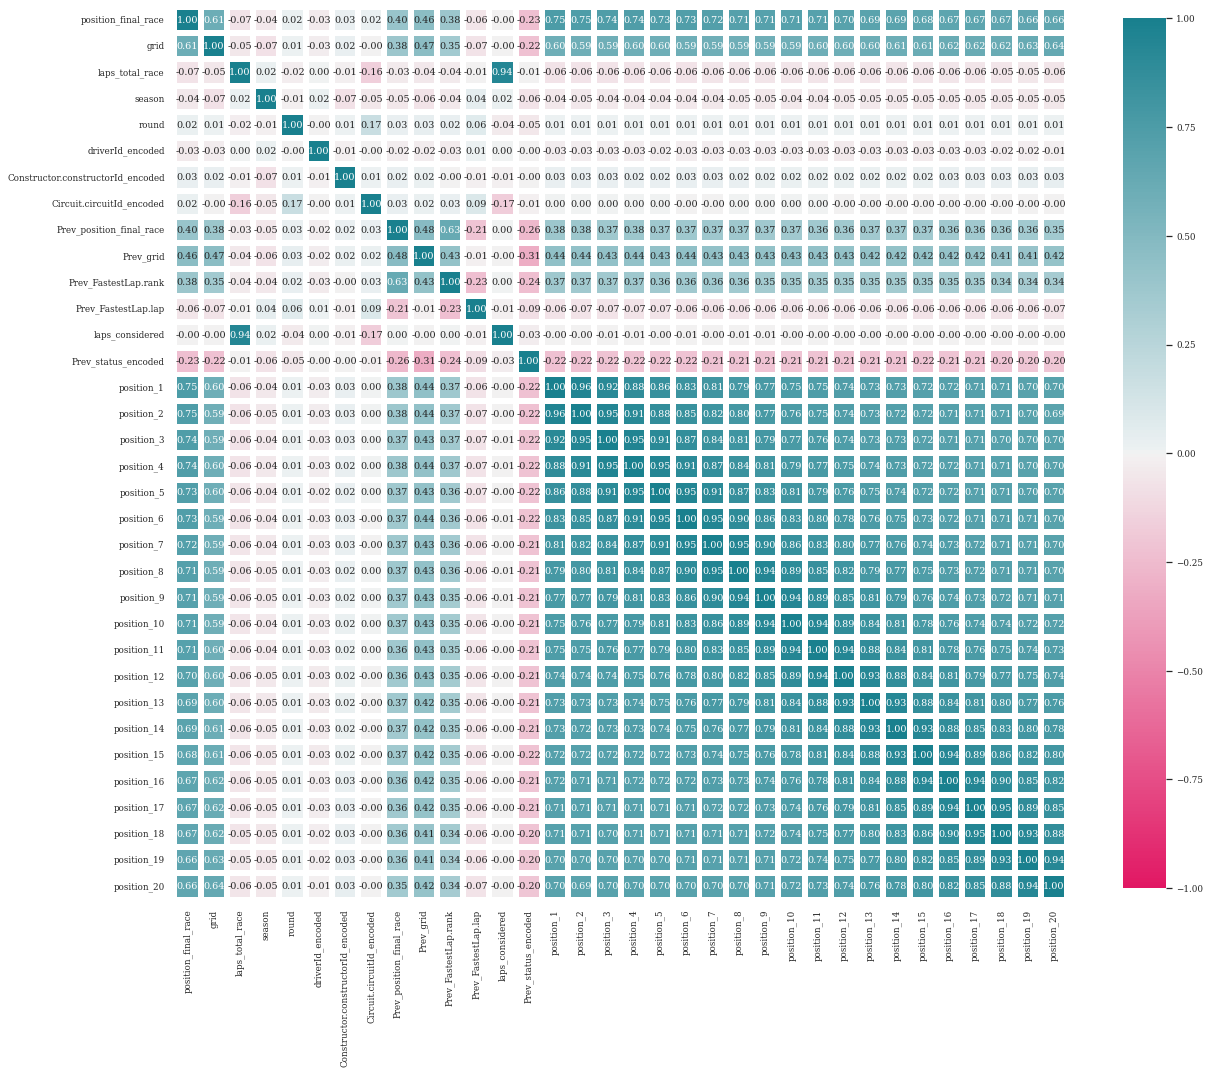

In [ ]:

#Calculating correlation: Heatmap
sns.set_theme(style="whitegrid", palette="magma",font_scale=0.8,font="serif")
fig, ax = plt.subplots(figsize=(20,20))
cmap = sns.diverging_palette(0, 210, 95, 49, as_cmap=True)
sns.heatmap(ResultsExpandedDF[cat].corr(method='kendall'), annot=True, fmt=".2f", 
           linewidths=5,cmap=cmap, vmin=-1, vmax=1, 
           cbar_kws={"shrink": .8}, square=True)

plt.show()

### Feature Selection Aid

In [ ]:
dependent='position_final_race'

X_train, X_test, y_train, y_test = train_test_split(ResultsExpandedDF[cont[1:]], ResultsExpandedDF[dependent], test_size=0.20,random_state=19933)

#apply SelectKBest class to extract top best features
bestfeatures = SelectKBest(score_func=f_classif, k="all")
fit = bestfeatures.fit(X_train,y_train)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(55,'Score'))  #print best features

                                    Specs      Score
4                           Q3_in_seconds  71.955025
3                           Q2_in_seconds  43.399266
0                        Prev_Time.millis  19.924064
5   Prev_FastestLap.AverageSpeed.speedKph   1.739547
2                           Q1_in_seconds   1.368028
1    Prev_FastestLap.Time.time_in_seconds   1.156610
6                      Fastest_per_driver   1.072622
18                   lap_11_duration_secs   0.875373
8                     lap_1_duration_secs   0.865793
26                   lap_19_duration_secs   0.848603
25                   lap_18_duration_secs   0.843263
24                   lap_17_duration_secs   0.801930
22                   lap_15_duration_secs   0.676701
23                   lap_16_duration_secs   0.655421
14                    lap_7_duration_secs   0.606661
9                     lap_2_duration_secs   0.604329
27                   lap_20_duration_secs   0.602022
19                   lap_12_duration_secs   0.

In [ ]:
dependent='position_final_race'

X_train, X_test, y_train, y_test = train_test_split(ResultsExpandedDF[cat[1:]], ResultsExpandedDF[dependent], test_size=0.20,random_state=1994)

#apply SelectKBest class to extract top  best features
bestfeatures = SelectKBest(score_func=chi2, k="all")
fit = bestfeatures.fit(X_train,y_train)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(38,'Score'))  #print best features

                                Specs        Score
13                         position_1  6907.096444
14                         position_2  6811.071691
15                         position_3  6791.477868
16                         position_4  6775.191830
17                         position_5  6695.123674
18                         position_6  6642.537141
19                         position_7  6626.398379
20                         position_8  6552.661072
21                         position_9  6511.466089
23                        position_11  6486.392796
22                        position_10  6474.136229
24                        position_12  6401.939920
25                        position_13  6297.509827
26                        position_14  6273.591426
27                        position_15  6181.547815
29                        position_17  6117.981651
28                        position_16  6113.999657
30                        position_18  6042.199978
31                        posit

### Hyperparameter optimization

In [ ]:
dependent='position_final_race'

#for stratified division
stratifiedclasses=pd.concat([ResultsExpandedDF["position_final_race"],ResultsExpandedDF["position_final_race"]]).reset_index()

#Divide data into training and testing - stratified
X_train, X_test, y_train, y_test = train_test_split(ResultsExpandedDF[united[1:]], ResultsExpandedDF[dependent], test_size=0.20,random_state=1994)
#X_train, X_test, y_train, y_test = train_test_split(ResultsExpandedDF[united[1:]], ResultsExpandedDF[dependent],stratify=ResultsExpandedDF[dependent], test_size=0.20,random_state=1994)



In [ ]:
#Cross Validation using Grid Search
RF=RandomForestClassifier(bootstrap=True,criterion="gini",n_estimators=200,max_features=None)
tuned_parameters = {
    # "n_estimators":[100,200,300],
    # 'criterion': ["gini","entropy"],
    'max_depth': [None,500]} 
    # 'min_samples_split': [2,3,4,5,6], #CHOSEN 3
    # 'min_samples_leaf': [1,2,3,4,5], #in tests before only 3 were selected
    #"max_features":["auto","sqrt","log2",None],
    # max_leaf_nodes":[None,50,70] #CHOSEN 70}
    # "class_weight":["balanced","balanced_subsample",None]}

for x in [5,7]:
    clf1 = GridSearchCV(RF, tuned_parameters, cv=KFold(n_splits=x), scoring=f1_scorer)
    clf1.fit(X_train, y_train)
    print("Folds: ",x,"- F1 Scorer: ",clf1.best_score_," ",clf1.best_params_)

for x in [5,7]:
    clf2 = GridSearchCV(RF, tuned_parameters, cv=KFold(n_splits=x), scoring=accuracy_scorer)
    clf2.fit(X_train, y_train)
    print("Folds: ",x,"- Accuracy: ",clf2.best_score_," ",clf2.best_params_)

THE_CHOSEN_ONE=RandomForestClassifier(bootstrap=True,class_weight="balanced",criterion="entropy",max_features=None,n_estimators=300,min_samples_leaf=3,max_depth=30,max_leaf_nodes=70,min_samples_split=3)

Folds:  5 - F1 Scorer:  0.23409573934257563   {'max_depth': None}
Folds:  7 - F1 Scorer:  0.2276394091925073   {'max_depth': 500}
Folds:  5 - Accuracy:  0.2357837076037387   {'max_depth': 500}
Folds:  7 - Accuracy:  0.23068513119533526   {'max_depth': 500}


In [ ]:
# Scores while training 50%
# Folds:  5 - F1 Scorer:  0.25938514348948205   {'criterion': 'gini', 'n_estimators': 200}
# Folds:  7 - F1 Scorer:  0.25243306144138916   {'criterion': 'gini', 'n_estimators': 200}
# Folds:  5 - Accuracy:  0.2598387246885512   {'criterion': 'entropy', 'n_estimators': 300}
# Folds:  7 - Accuracy:  0.25473760932944606   {'criterion': 'gini', 'n_estimators': 200}

# Folds:  5 - F1 Scorer:  0.2309643994112139   {'class_weight': 'balanced_subsample'}
# Folds:  7 - F1 Scorer:  0.22640000396263144   {'class_weight': 'balanced_subsample'}
# Folds:  5 - Accuracy:  0.2306841902330714   {'class_weight': 'balanced'}
# Folds:  7 - Accuracy:  0.22995626822157436   {'class_weight': 'balanced'}

# Folds:  5 - F1 Scorer:  0.23389545302784137   {'max_features': None}
# Folds:  7 - F1 Scorer:  0.23406002398806383   {'max_features': None}

#Folds:  5 - F1 Scorer:  0.22829252721514487   {'max_depth': 100}



### To test many times

In [ ]:
#Functions used to test the models during backwards elimination
np.random.seed(1994)

def back(measure):
    len_ind=len(independent_original)
    for i in range(len_ind):
       a=independent_original[:i]
       b=independent_original[i+1:]
       c=a+b
       X_train, X_test, y_train, y_test = train_test_split(ResultsExpandedDF[c], ResultsExpandedDF[dependent], test_size=0.20,random_state=1994)
       X_trainn, X_val, y_trainn, y_val = train_test_split(X_train, y_train, test_size=0.20,random_state=1994)
       measureslist=[]
       for r in range(100):
          RF=RandomForestClassifier(n_estimators=50)
          RF.fit(X_trainn,y_trainn)
          y_val_predicted=RF.predict(X_val)
          
          y_true = y_val 
          y_pred = y_val_predicted
          measureslist+=[measure(y_true, y_pred)]
          measures_array=np.array(measureslist)
          avgmeasures=np.mean(measures_array)
       print("erased: ",independent_original[i],' - ',str(avgmeasures))

def backf1():
    len_ind=len(independent_original)
    for i in range(len_ind):
       a=independent_original[:i]
       b=independent_original[i+1:]
       c=a+b
       X_train, X_test, y_train, y_test = train_test_split(ResultsExpandedDF[c], ResultsExpandedDF[dependent], test_size=0.20,random_state=1994)
       X_trainn, X_val, y_trainn, y_val = train_test_split(X_train, y_train, test_size=0.20)
       measureslist=[]
       for r in range(100):
          RF=RandomForestClassifier(n_estimators=50)
          RF.fit(X_trainn,y_trainn)
          y_val_predicted=RF.predict(X_val)
          
          y_true = y_val 
          y_pred = y_val_predicted
          measureslist+=[f1_score(y_true, y_pred,average="weighted")]
          measures_array=np.array(measureslist)
          avgmeasures=np.mean(measures_array)
       print("erased: ",independent_original[i],' - ',str(avgmeasures))



def backtotalf1():
   len_ind=len(independent_original)

   X_train, X_test, y_train, y_test = train_test_split(ResultsExpandedDF[independent_original], ResultsExpandedDF[dependent], test_size=0.20,random_state=1994)
   X_trainn, X_val, y_trainn, y_val = train_test_split(X_train, y_train, test_size=0.20)
   measureslist=[]
   for r in range(100):
      # RF=RandomForestClassifier(n_estimators=100)
      RF=RandomForestClassifier(n_estimators=100)
      RF.fit(X_trainn,y_trainn)
      y_val_predicted=RF.predict(X_val)
      
      y_true = y_val 
      y_pred = y_val_predicted
      measureslist+=[f1_score(y_true, y_pred,average="weighted")]
      measures_array=np.array(measureslist)
      avgmeasures=np.mean(measures_array)
   print(' - ',str(avgmeasures))

def backtotal(measure):
   len_ind=len(independent_original)

   X_train, X_test, y_train, y_test = train_test_split(ResultsExpandedDF[independent_original], ResultsExpandedDF[dependent], test_size=0.20,random_state=1994)
   X_trainn, X_val, y_trainn, y_val = train_test_split(X_train, y_train, test_size=0.20)
   measureslist=[]
   for r in range(100):
      RF=RandomForestClassifier(n_estimators=100)
      RF.fit(X_trainn,y_trainn)
      y_val_predicted=RF.predict(X_val)
      
      y_true = y_val 
      y_pred = y_val_predicted
      measureslist+=[measure(y_true, y_pred)]
      measures_array=np.array(measureslist)
      avgmeasures=np.mean(measures_array)
   print(' - ',str(avgmeasures))

In [ ]:
#features
dependent='position_final_race'

#With all the initial values
# independent_original=['Prev_Time.millis','Prev_FastestLap.Time.time_in_seconds',
#        "Q1_in_seconds","Q2_in_seconds","Q3_in_seconds",
#        'Prev_FastestLap.AverageSpeed.speedKph',
#        'Fastest_per_driver', 'Fastest_per_race','lap_1_duration_secs', 'lap_2_duration_secs', 'lap_3_duration_secs',
#        'lap_4_duration_secs', 'lap_5_duration_secs','grid', 'laps_total_race','season', 'round','driverId_encoded',
#        'Constructor.constructorId_encoded', 'Circuit.circuitId_encoded',
#        'Prev_position_final_race', 'Prev_grid',
#        'Prev_FastestLap.rank', 'Prev_FastestLap.lap','laps_considered',
#        'position_1', 'position_2', 'position_3', 'position_4', 'position_5', 'Prev_status_encoded']


#Taking 'laps_total_race' out
# independent_original=['Prev_Time.millis','Prev_FastestLap.Time.time_in_seconds',
#        "Q1_in_seconds","Q2_in_seconds","Q3_in_seconds",
#        'Prev_FastestLap.AverageSpeed.speedKph',
#        'Fastest_per_driver', 'Fastest_per_race','lap_1_duration_secs', 'lap_2_duration_secs', 'lap_3_duration_secs',
#        'lap_4_duration_secs', 'lap_5_duration_secs','grid','season', 'round','driverId_encoded',
#        'Constructor.constructorId_encoded', 'Circuit.circuitId_encoded',
#        'Prev_position_final_race', 'Prev_grid',
#        'Prev_FastestLap.rank', 'Prev_FastestLap.lap','laps_considered',
#        'position_1', 'position_2', 'position_3', 'position_4', 'position_5', 'Prev_status_encoded']

#Taking 'Fastest_per_race' out
# independent_original=['Prev_Time.millis','Prev_FastestLap.Time.time_in_seconds',
#        "Q1_in_seconds","Q2_in_seconds","Q3_in_seconds",
#        'Prev_FastestLap.AverageSpeed.speedKph',
#        'Fastest_per_driver','lap_1_duration_secs', 'lap_2_duration_secs', 'lap_3_duration_secs',
#        'lap_4_duration_secs', 'lap_5_duration_secs','grid','season', 'round','driverId_encoded',
#        'Constructor.constructorId_encoded', 'Circuit.circuitId_encoded',
#        'Prev_position_final_race', 'Prev_grid',
#        'Prev_FastestLap.rank', 'Prev_FastestLap.lap','laps_considered',
#        'position_1', 'position_2', 'position_3', 'position_4', 'position_5', 'Prev_status_encoded']

#taking "round" out
# independent_original=['Prev_Time.millis','Prev_FastestLap.Time.time_in_seconds',
#        "Q1_in_seconds","Q2_in_seconds","Q3_in_seconds",
#        'Prev_FastestLap.AverageSpeed.speedKph',
#        'Fastest_per_driver','lap_1_duration_secs', 'lap_2_duration_secs', 'lap_3_duration_secs',
#        'lap_4_duration_secs', 'lap_5_duration_secs','grid','season','driverId_encoded',
#        'Constructor.constructorId_encoded', 'Circuit.circuitId_encoded',
#        'Prev_position_final_race', 'Prev_grid',
#        'Prev_FastestLap.rank', 'Prev_FastestLap.lap','laps_considered',
#        'position_1', 'position_2', 'position_3', 'position_4', 'position_5', 'Prev_status_encoded']

# #taking 'Prev_FastestLap.Time.time_in_seconds' out
# independent_original=['Prev_Time.millis',
#        "Q1_in_seconds","Q2_in_seconds","Q3_in_seconds",
#        'Prev_FastestLap.AverageSpeed.speedKph',
#        'Fastest_per_driver','lap_1_duration_secs', 'lap_2_duration_secs', 'lap_3_duration_secs',
#        'lap_4_duration_secs', 'lap_5_duration_secs','grid','season','driverId_encoded',
#        'Constructor.constructorId_encoded', 'Circuit.circuitId_encoded',
#        'Prev_position_final_race', 'Prev_grid',
#        'Prev_FastestLap.rank', 'Prev_FastestLap.lap','laps_considered',
#        'position_1', 'position_2', 'position_3', 'position_4', 'position_5', 'Prev_status_encoded']

#taking laps considered
# independent_original=['Prev_Time.millis',
#        "Q1_in_seconds","Q2_in_seconds","Q3_in_seconds",
#        'Prev_FastestLap.AverageSpeed.speedKph',
#        'Fastest_per_driver','lap_1_duration_secs', 'lap_2_duration_secs', 'lap_3_duration_secs',
#        'lap_4_duration_secs', 'lap_5_duration_secs','grid','season','driverId_encoded',
#        'Constructor.constructorId_encoded', 'Circuit.circuitId_encoded',
#        'Prev_position_final_race', 'Prev_grid',
#        'Prev_FastestLap.rank', 'Prev_FastestLap.lap',
#        'position_1', 'position_2', 'position_3', 'position_4', 'position_5', 'Prev_status_encoded']

# #taking lap duration out and inserting pca
# independent_original=['Prev_Time.millis',
#        "Q1_in_seconds","Q2_in_seconds","Q3_in_seconds",
#        'Prev_FastestLap.AverageSpeed.speedKph',
#        'Fastest_per_driver','grid','season','driverId_encoded',
#        'Constructor.constructorId_encoded', 'Circuit.circuitId_encoded',
#        'Prev_position_final_race', 'Prev_grid',
#        'Prev_FastestLap.rank', 'Prev_FastestLap.lap',
#        'position_1', 'position_2', 'position_3', 'position_4', 'position_5', 'Prev_status_encoded',"PC_LapsDuration"]


### Backwards elimination changes end

### Changes about using or not PCA start

# ###50% 20 laps
# independent_original=['Prev_Time.millis',
#        "Q1_in_seconds","Q2_in_seconds","Q3_in_seconds",
#        'Prev_FastestLap.AverageSpeed.speedKph',
#        'Fastest_per_driver','grid','season','driverId_encoded',
#        'Constructor.constructorId_encoded', 'Circuit.circuitId_encoded',
#        'Prev_position_final_race', 'Prev_grid',
#        'Prev_FastestLap.rank', 'Prev_FastestLap.lap',
#        'position_1', 'position_2', 'position_3', 'position_4', 'position_5',
#        'position_6', 'position_7', 'position_8', 'position_9', 'position_10',
#        'position_11', 'position_12', 'position_13', 'position_14', 'position_15',
#        'position_16', 'position_17', 'position_18', 'position_19', 'position_20', 'Prev_status_encoded']


# ####50% 20 laps pca
# independent_original=['Prev_Time.millis',
#        "Q1_in_seconds","Q2_in_seconds","Q3_in_seconds",
#        'Prev_FastestLap.AverageSpeed.speedKph',
#        'Fastest_per_driver','grid','season','driverId_encoded',
#        'Constructor.constructorId_encoded', 'Circuit.circuitId_encoded',
#        'Prev_position_final_race', 'Prev_grid',
#        'Prev_FastestLap.rank', 'Prev_FastestLap.lap',
#        "PC1_LapsDuration","PC2_LapsDuration","PC3_LapsDuration","PC4_LapsDuration","PC5_LapsDuration", 'Prev_status_encoded']


###25% 10 laps
independent_original=['Prev_Time.millis',
       "Q1_in_seconds","Q2_in_seconds","Q3_in_seconds",
       'Prev_FastestLap.AverageSpeed.speedKph',
       'Fastest_per_driver','grid','season','driverId_encoded',
       'Constructor.constructorId_encoded', 'Circuit.circuitId_encoded',
       'Prev_position_final_race', 'Prev_grid',
       'Prev_FastestLap.rank', 'Prev_FastestLap.lap',
       'position_1', 'position_2', 'position_3', 'position_4', 'position_5',
       'position_6', 'position_7', 'position_8', 'position_9', 'position_10', 'Prev_status_encoded']



# ####25% 10 laps pca
# independent_original=['Prev_Time.millis',
#        "Q1_in_seconds","Q2_in_seconds","Q3_in_seconds",
#        'Prev_FastestLap.AverageSpeed.speedKph',
#        'Fastest_per_driver','grid','season','driverId_encoded',
#        'Constructor.constructorId_encoded', 'Circuit.circuitId_encoded',
#        'Prev_position_final_race', 'Prev_grid',
#        'Prev_FastestLap.rank', 'Prev_FastestLap.lap',
#        "PC1_LapsDuration","PC2_LapsDuration","PC3_LapsDuration", 'Prev_status_encoded']



### Podium predicted before the race starts
independent_original=['Prev_Time.millis',
       "Q1_in_seconds","Q2_in_seconds","Q3_in_seconds",
       'Prev_FastestLap.AverageSpeed.speedKph',
       'Fastest_per_driver','grid','season','driverId_encoded',
       'Constructor.constructorId_encoded', 'Circuit.circuitId_encoded',
       'Prev_position_final_race', 'Prev_grid',
       'Prev_FastestLap.rank', 'Prev_FastestLap.lap',
       'position_1', 'position_2', 'position_3', 'position_4', 'position_5',
       'position_6', 'position_7', 'position_8', 'position_9', 'position_10', 'Prev_status_encoded']

In [ ]:
# # Results when one feature is deleted from the model:
# print(backf1())
# print(back(accuracy_score))

In [ ]:
# Evaluating the model 100 times with a RF of 10 trees
print(backtotalf1(),backtotal(accuracy_score)

### Cross Validation feature selection

In [ ]:
len(united[1:])
#len(ResultsExpandedDF.columns)

61

In [ ]:
united

array(['position_final_race', 'grid', 'laps_total_race', 'season',
       'round', 'driverId_encoded', 'Constructor.constructorId_encoded',
       'Circuit.circuitId_encoded', 'Prev_position_final_race',
       'Prev_grid', 'Prev_FastestLap.rank', 'Prev_FastestLap.lap',
       'laps_considered', 'Prev_status_encoded', 'position_1',
       'position_2', 'position_3', 'position_4', 'position_5',
       'position_6', 'position_7', 'position_8', 'position_9',
       'position_10', 'position_11', 'position_12', 'position_13',
       'position_14', 'position_15', 'position_16', 'position_17',
       'position_18', 'position_19', 'position_20', 'Prev_Time.millis',
       'Prev_FastestLap.Time.time_in_seconds', 'Q1_in_seconds',
       'Q2_in_seconds', 'Q3_in_seconds',
       'Prev_FastestLap.AverageSpeed.speedKph', 'Fastest_per_driver',
       'Fastest_per_race', 'lap_1_duration_secs', 'lap_2_duration_secs',
       'lap_3_duration_secs', 'lap_4_duration_secs',
       'lap_5_duration_secs', 'la

In [ ]:
#Removing laps_considered

CH1=['grid', 'laps_total_race', 'season', 'driverId_encoded', 'Constructor.constructorId_encoded',
       'Circuit.circuitId_encoded', 'Prev_position_final_race',"round",
       'Prev_grid', 'Prev_FastestLap.rank', 'Prev_FastestLap.lap', 'Prev_status_encoded', 'position_1',
       'position_2', 'position_3', 'position_4', 'position_5',
       'position_6', 'position_7', 'position_8', 'position_9',
       'position_10', 'position_11', 'position_12', 'position_13',
       'position_14', 'position_15', 'position_16', 'position_17',
       'position_18', 'position_19', 'position_20', 'Prev_Time.millis',
       'Prev_FastestLap.Time.time_in_seconds', 'Q1_in_seconds',
       'Q2_in_seconds', 'Q3_in_seconds',
       'Prev_FastestLap.AverageSpeed.speedKph', 'Fastest_per_driver',
       'Fastest_per_race', 'lap_1_duration_secs', 'lap_2_duration_secs',
       'lap_3_duration_secs', 'lap_4_duration_secs',
       'lap_5_duration_secs', 'lap_6_duration_secs',
       'lap_7_duration_secs', 'lap_8_duration_secs',
       'lap_9_duration_secs', 'lap_10_duration_secs',
       'lap_11_duration_secs', 'lap_12_duration_secs',
       'lap_13_duration_secs', 'lap_14_duration_secs',
       'lap_15_duration_secs', 'lap_16_duration_secs',
       'lap_17_duration_secs', 'lap_18_duration_secs',
       'lap_19_duration_secs', 'lap_20_duration_secs']

RF=RandomForestClassifier(bootstrap=True,criterion="gini",n_estimators=200,max_features=None,max_depth=500,random_state=1994)

scores0=cross_val_score(RF,ResultsExpandedDF[united[1:]],ResultsExpandedDF[dependent],cv=5,scoring=f1_scorer)
scores1=cross_val_score(RF,ResultsExpandedDF[CH1],ResultsExpandedDF[dependent],cv=5,scoring=f1_scorer)
print("Prev: ",np.mean(scores0),"   Post: ",np.mean(scores1))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


KeyboardInterrupt: ignored

In [ ]:
CH2=['grid', 'season', 'driverId_encoded', 'Constructor.constructorId_encoded',
       'Circuit.circuitId_encoded', 'Prev_position_final_race',"round",
       'Prev_grid', 'Prev_FastestLap.rank', 'Prev_FastestLap.lap', 'Prev_status_encoded', 'position_1',
       'position_2', 'position_3', 'position_4', 'position_5',
       'position_6', 'position_7', 'position_8', 'position_9',
       'position_10', 'position_11', 'position_12', 'position_13',
       'position_14', 'position_15', 'position_16', 'position_17',
       'position_18', 'position_19', 'position_20', 'Prev_Time.millis',
       'Prev_FastestLap.Time.time_in_seconds', 'Q1_in_seconds',
       'Q2_in_seconds', 'Q3_in_seconds',
       'Prev_FastestLap.AverageSpeed.speedKph', 'Fastest_per_driver',
       'Fastest_per_race', 'lap_1_duration_secs', 'lap_2_duration_secs',
       'lap_3_duration_secs', 'lap_4_duration_secs',
       'lap_5_duration_secs', 'lap_6_duration_secs',
       'lap_7_duration_secs', 'lap_8_duration_secs',
       'lap_9_duration_secs', 'lap_10_duration_secs',
       'lap_11_duration_secs', 'lap_12_duration_secs',
       'lap_13_duration_secs', 'lap_14_duration_secs',
       'lap_15_duration_secs', 'lap_16_duration_secs',
       'lap_17_duration_secs', 'lap_18_duration_secs',
       'lap_19_duration_secs', 'lap_20_duration_secs']

      
RF=RandomForestClassifier(bootstrap=True,criterion="gini",n_estimators=200,max_features=None,max_depth=500,random_state=1994)

scores2=cross_val_score(RF,ResultsExpandedDF[CH2],ResultsExpandedDF[dependent],cv=5,scoring=f1_scorer)
print("Prev: ",np.mean(scores0),"   Post: ",np.mean(scores2))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


Prev:  0.25762370835168946    Post:  0.25266168875383516


### Individual Training and testing

In [ ]:
len(united[1:])

21

In [ ]:
len(Selected0)

16

In [ ]:
#In order to make stratified splitting we need more than one class
# ResultsExpandedDF[ResultsExpandedDF["position_final_race"]==24]=23

In [ ]:
Selected50=['grid', 'season', 'driverId_encoded',
       'Constructor.constructorId_encoded', 'Circuit.circuitId_encoded',
       'Prev_position_final_race', 'Prev_grid', 'Prev_FastestLap.rank',
       'Prev_FastestLap.lap', 'Prev_status_encoded',
       'position_1', 'position_2', 'position_3', 'position_4',
       'position_5', 'position_6', 'position_7', 'position_8',
       'position_9', 'position_10', 'position_11', 'position_12',
       'position_13', 'position_14', 'position_15', 'position_16',
       'position_17', 'position_18', 'position_19', 'position_20',
       'Prev_Time.millis',
       'Q1_in_seconds', 'Q2_in_seconds', 'Q3_in_seconds',
       'Prev_FastestLap.AverageSpeed.speedKph', 'Fastest_per_driver', 'lap_1_duration_secs', 'lap_2_duration_secs',
       'lap_3_duration_secs', 'lap_4_duration_secs',
       'lap_5_duration_secs', 'lap_6_duration_secs',
       'lap_7_duration_secs', 'lap_8_duration_secs',
       'lap_9_duration_secs', 'lap_10_duration_secs',
       'lap_11_duration_secs', 'lap_12_duration_secs',
       'lap_13_duration_secs', 'lap_14_duration_secs',
       'lap_15_duration_secs', 'lap_16_duration_secs',
       'lap_17_duration_secs', 'lap_18_duration_secs',
       'lap_19_duration_secs', 'lap_20_duration_secs'] #56

In [547]:
dependent='position_final_race'

Selected50=['grid', 'season', 'driverId_encoded',
       'Constructor.constructorId_encoded', 'Circuit.circuitId_encoded',
       'Prev_position_final_race', 'Prev_grid', 'Prev_FastestLap.rank',
       'Prev_FastestLap.lap', 'Prev_status_encoded',
       'position_1', 'position_2', 'position_3', 'position_4',
       'position_5', 'position_6', 'position_7', 'position_8',
       'position_9', 'position_10',
       'Prev_Time.millis',
       'Q1_in_seconds', 'Q2_in_seconds', 'Q3_in_seconds',
       'Prev_FastestLap.AverageSpeed.speedKph', 'Fastest_per_driver', 'lap_1_duration_secs', 'lap_2_duration_secs',
       'lap_3_duration_secs', 'lap_4_duration_secs',
       'lap_5_duration_secs', 'lap_6_duration_secs',
       'lap_7_duration_secs', 'lap_8_duration_secs',
       'lap_9_duration_secs', 'lap_10_duration_secs'] #56

Selected25=['grid', 'season', 'driverId_encoded',
       'Constructor.constructorId_encoded', 'Circuit.circuitId_encoded',
       'Prev_position_final_race', 'Prev_grid', 'Prev_FastestLap.rank',
       'Prev_FastestLap.lap', 'Prev_status_encoded',
       'position_1', 'position_2', 'position_3', 'position_4',
       'position_5', 'position_6', 'position_7', 'position_8',
       'position_9', 'position_10',
       'Prev_Time.millis',
       'Q1_in_seconds', 'Q2_in_seconds', 'Q3_in_seconds',
       'Prev_FastestLap.AverageSpeed.speedKph', 'Fastest_per_driver', 'lap_1_duration_secs', 'lap_2_duration_secs',
       'lap_3_duration_secs', 'lap_4_duration_secs',
       'lap_5_duration_secs', 'lap_6_duration_secs',
       'lap_7_duration_secs', 'lap_8_duration_secs',
       'lap_9_duration_secs', 'lap_10_duration_secs']

Selected0=['grid', 'season', 'driverId_encoded',
       'Constructor.constructorId_encoded', 'Circuit.circuitId_encoded',
       'Prev_position_final_race', 'Prev_grid', 'Prev_FastestLap.rank',
       'Prev_FastestLap.lap', 'Prev_status_encoded',
       'Prev_Time.millis',
       'Q1_in_seconds', 'Q2_in_seconds', 'Q3_in_seconds',
       'Prev_FastestLap.AverageSpeed.speedKph', 'Fastest_per_driver']

#for stratified division
stratifiedclasses=pd.concat([ResultsExpandedDF["position_final_race"],ResultsExpandedDF["position_final_race"]]).reset_index()

#Divide data into training and testing - stratified
X_train, X_test, y_train, y_test = train_test_split(ResultsExpandedDF[Selected50], ResultsExpandedDF[dependent], test_size=0.20,random_state=1994)

#united[1:]

In [556]:
X_train

grid  season  driverId_encoded  Constructor.constructorId_encoded  \
1325     2    2015                16                                 13   
2782     0    2020                14                                  7   
1143     1    2015                16                                 13   
595     13    2013                14                                  9   
275      8    2012                 7                                 12   
...    ...     ...               ...                                ...   
336      3    2012                30                                 19   
203     13    2012                48                                 13   
2082    13    2018                 2                                 12   
3427    13    2022                56                                  1   
2486     9    2019                32                                 15   

      Circuit.circuitId_encoded  Prev_position_final_race  Prev_grid  \
1325                          9                         2          2   
2782                          7                        13          0   
1143                         14                         2          2   
595                          15                         8          7   
275                          27                         2          4   
...                         ...                       ...        ...   
336                          30                        16          9   
203                           7                        10         21   
2082                         23                         7         13   
3427                          1                        19         19   
2486                         29                         4          3   

      Prev_FastestLap.rank  Prev_FastestLap.lap  Prev_status_encoded  ...  \
1325                     2                   67                   25  ...   
2782                    12                   69                    0  ...   
1143                     1                   54                   25  ...   
595                     11                   34                   25  ...   
275                      4                   47                   25  ...   
...                    ...                  ...                  ...  ...   
336                     16                   50                    0  ...   
203                      3                   59                   25  ...   
2082                     4                   47                    0  ...   
3427                    24                    0                   37  ...   
2486                     7                    9                   25  ...   

      lap_1_duration_secs  lap_2_duration_secs  lap_3_duration_secs  \
1325               81.551               77.051               76.643   
2782               91.657               86.100               84.025   
1143               96.182               80.379               80.391   
595                88.810               88.593               88.927   
275                99.734               99.484               99.504   
...                   ...                  ...                  ...   
336               108.397              108.277              109.643   
203                87.801               87.532               87.948   
2082               99.939               99.722               99.938   
3427               86.404               87.282              143.361   
2486               76.948               76.568               77.188   

      lap_4_duration_secs  lap_5_duration_secs  lap_6_duration_secs  \
1325               76.787               76.713               76.934   
2782               85.150               84.377               85.805   
1143               80.224               81.254               81.076   
595                89.247              111.967               93.436   
275                99.488               99.672               99.736   
...                   ...           

In [ ]:

RF=RandomForestClassifier(bootstrap=True,criterion="gini",n_estimators=200,max_features=None,max_depth=500,random_state=1994)

RF.fit(X_train,y_train)
y_train_predicted=RF.predict(X_train)
y_test_predicted=RF.predict(X_test)



In [ ]:
#Number of labels used in the confusion matrix
TRAINN=list(range(1,(y_train_predicted.max()+1)))
TESTT=list(range(1,(y_test_predicted.max()+1)))

In [ ]:
evaluating(y_train,y_train_predicted,y_test,y_test_predicted)


 Training Scores:
Accuracy: 1.0
F1 Score: 1.0
Recall: 1.0
Precision: 1.0

 Testing Scores:
Accuracy: 0.23177842565597667
F1 Score: 0.23340976895869572
Recall: 0.23177842565597667
Precision: 0.24597260267031582


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Training Data:


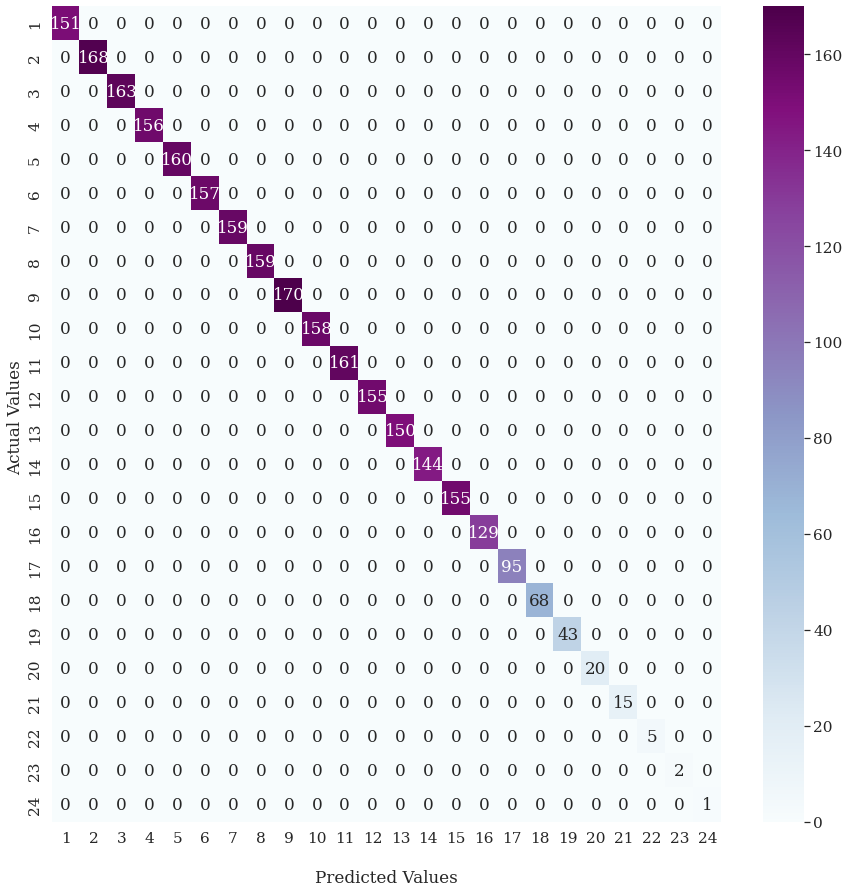

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       151
           2       1.00      1.00      1.00       168
           3       1.00      1.00      1.00       163
           4       1.00      1.00      1.00       156
           5       1.00      1.00      1.00       160
           6       1.00      1.00      1.00       157
           7       1.00      1.00      1.00       159
           8       1.00      1.00      1.00       159
           9       1.00      1.00      1.00       170
          10       1.00      1.00      1.00       158
          11       1.00      1.00      1.00       161
          12       1.00      1.00      1.00       155
          13       1.00      1.00      1.00       150
          14       1.00      1.00      1.00       144
          15       1.00      1.00      1.00       155
          16       1.00      1.00      1.00       129
          17       1.00      1.00      1.00        95
          18       1.00    

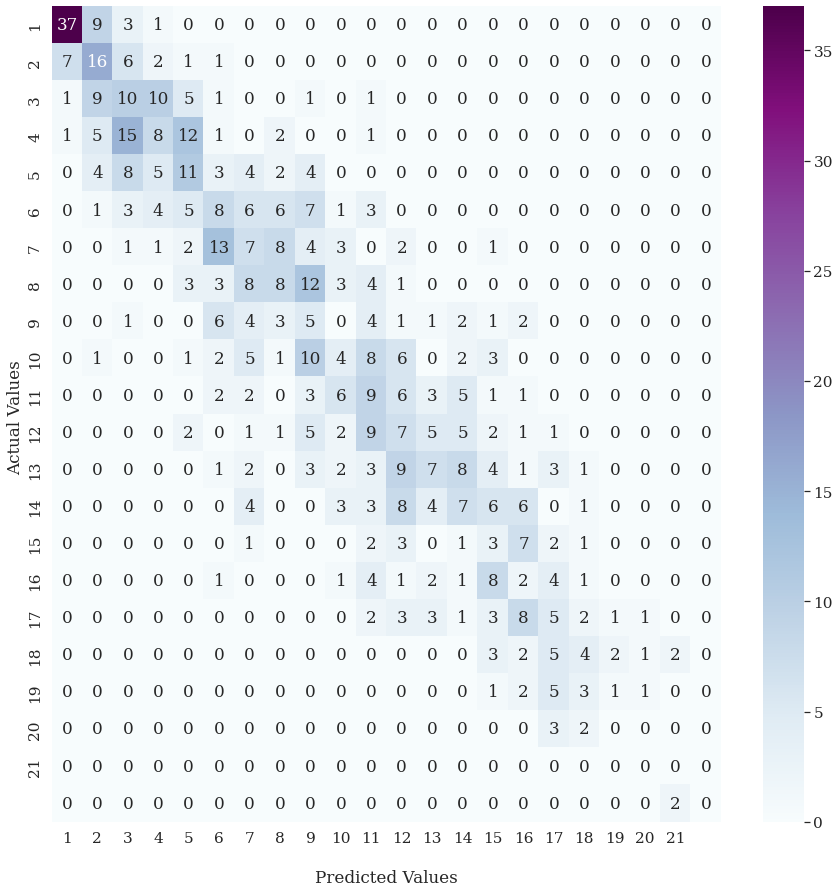

              precision    recall  f1-score   support

           1       0.80      0.74      0.77        50
           2       0.36      0.48      0.41        33
           3       0.21      0.26      0.24        38
           4       0.26      0.18      0.21        45
           5       0.26      0.27      0.27        41
           6       0.19      0.18      0.19        44
           7       0.16      0.17      0.16        42
           8       0.26      0.19      0.22        42
           9       0.09      0.17      0.12        30
          10       0.16      0.09      0.12        43
          11       0.17      0.24      0.20        38
          12       0.15      0.17      0.16        41
          13       0.28      0.16      0.20        44
          14       0.22      0.17      0.19        42
          15       0.08      0.15      0.11        20
          16       0.06      0.08      0.07        25
          17       0.18      0.17      0.18        29
          18       0.27    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

In [ ]:
testing_the_classifier(TRAINN,TESTT,thesize=(15,15),f=1.4)


 Training Data:


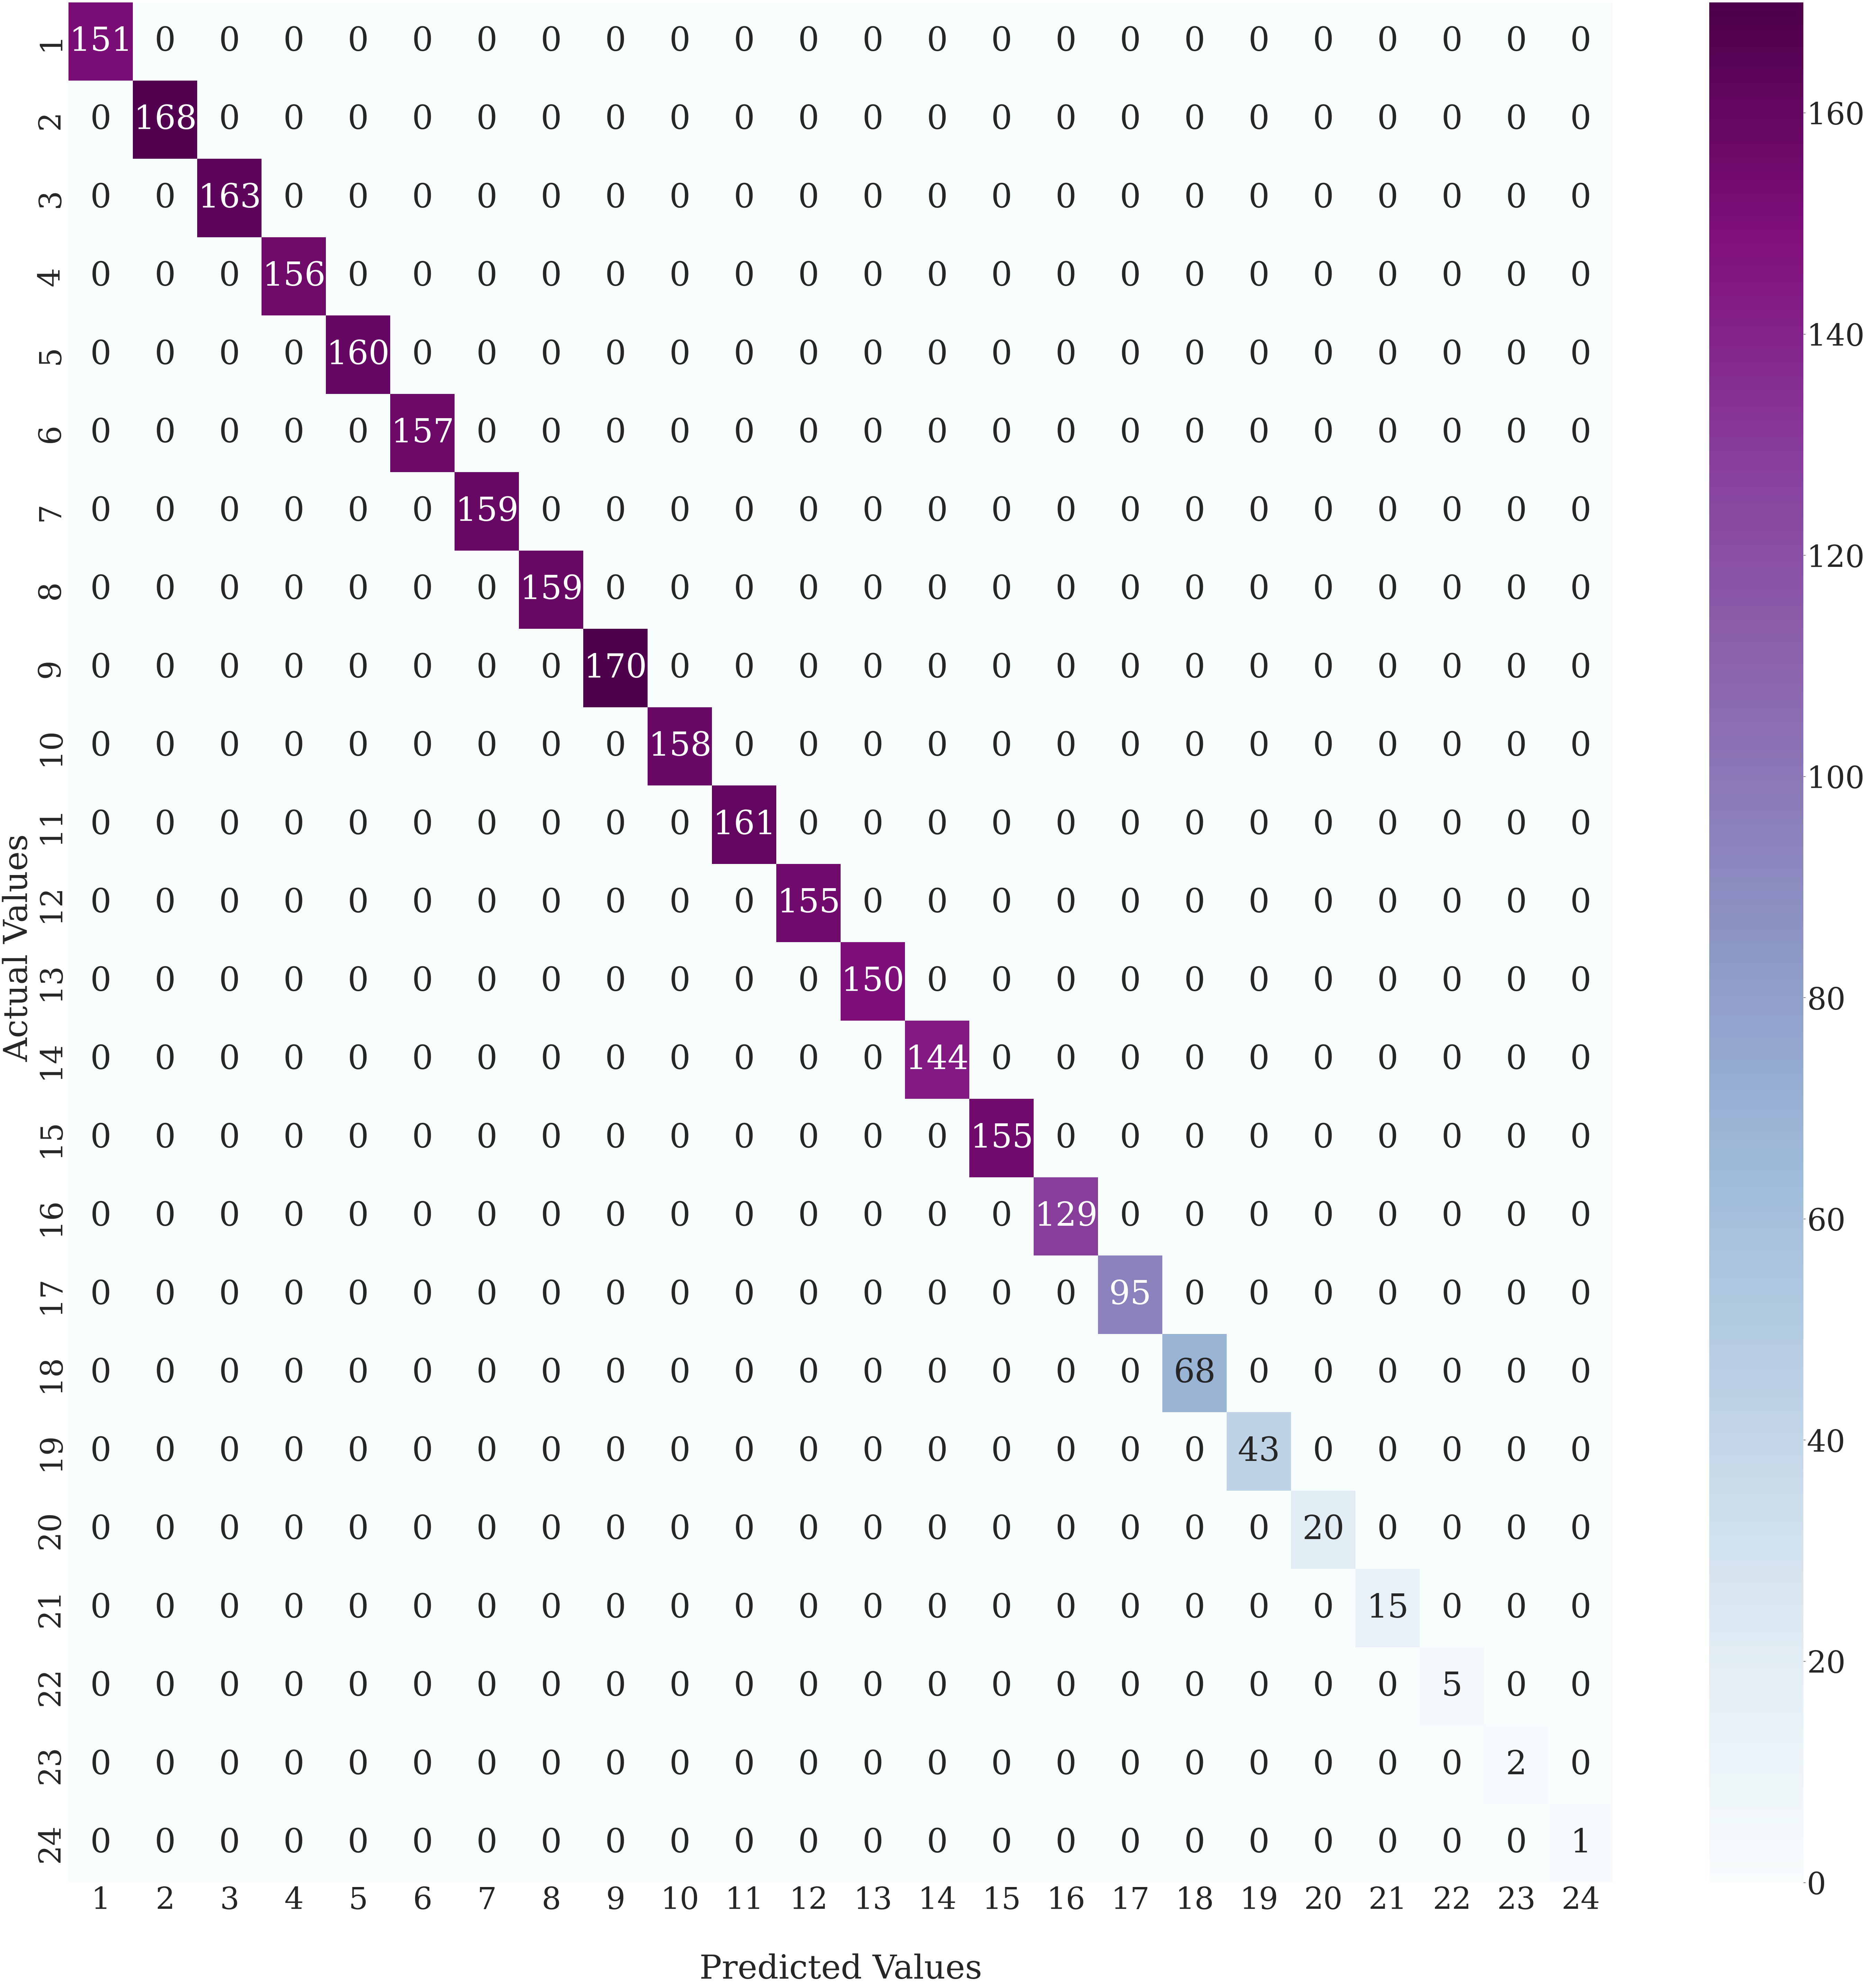

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       151
           2       1.00      1.00      1.00       168
           3       1.00      1.00      1.00       163
           4       1.00      1.00      1.00       156
           5       1.00      1.00      1.00       160
           6       1.00      1.00      1.00       157
           7       1.00      1.00      1.00       159
           8       1.00      1.00      1.00       159
           9       1.00      1.00      1.00       170
          10       1.00      1.00      1.00       158
          11       1.00      1.00      1.00       161
          12       1.00      1.00      1.00       155
          13       1.00      1.00      1.00       150
          14       1.00      1.00      1.00       144
          15       1.00      1.00      1.00       155
          16       1.00      1.00      1.00       129
          17       1.00      1.00      1.00        95
          18       1.00    

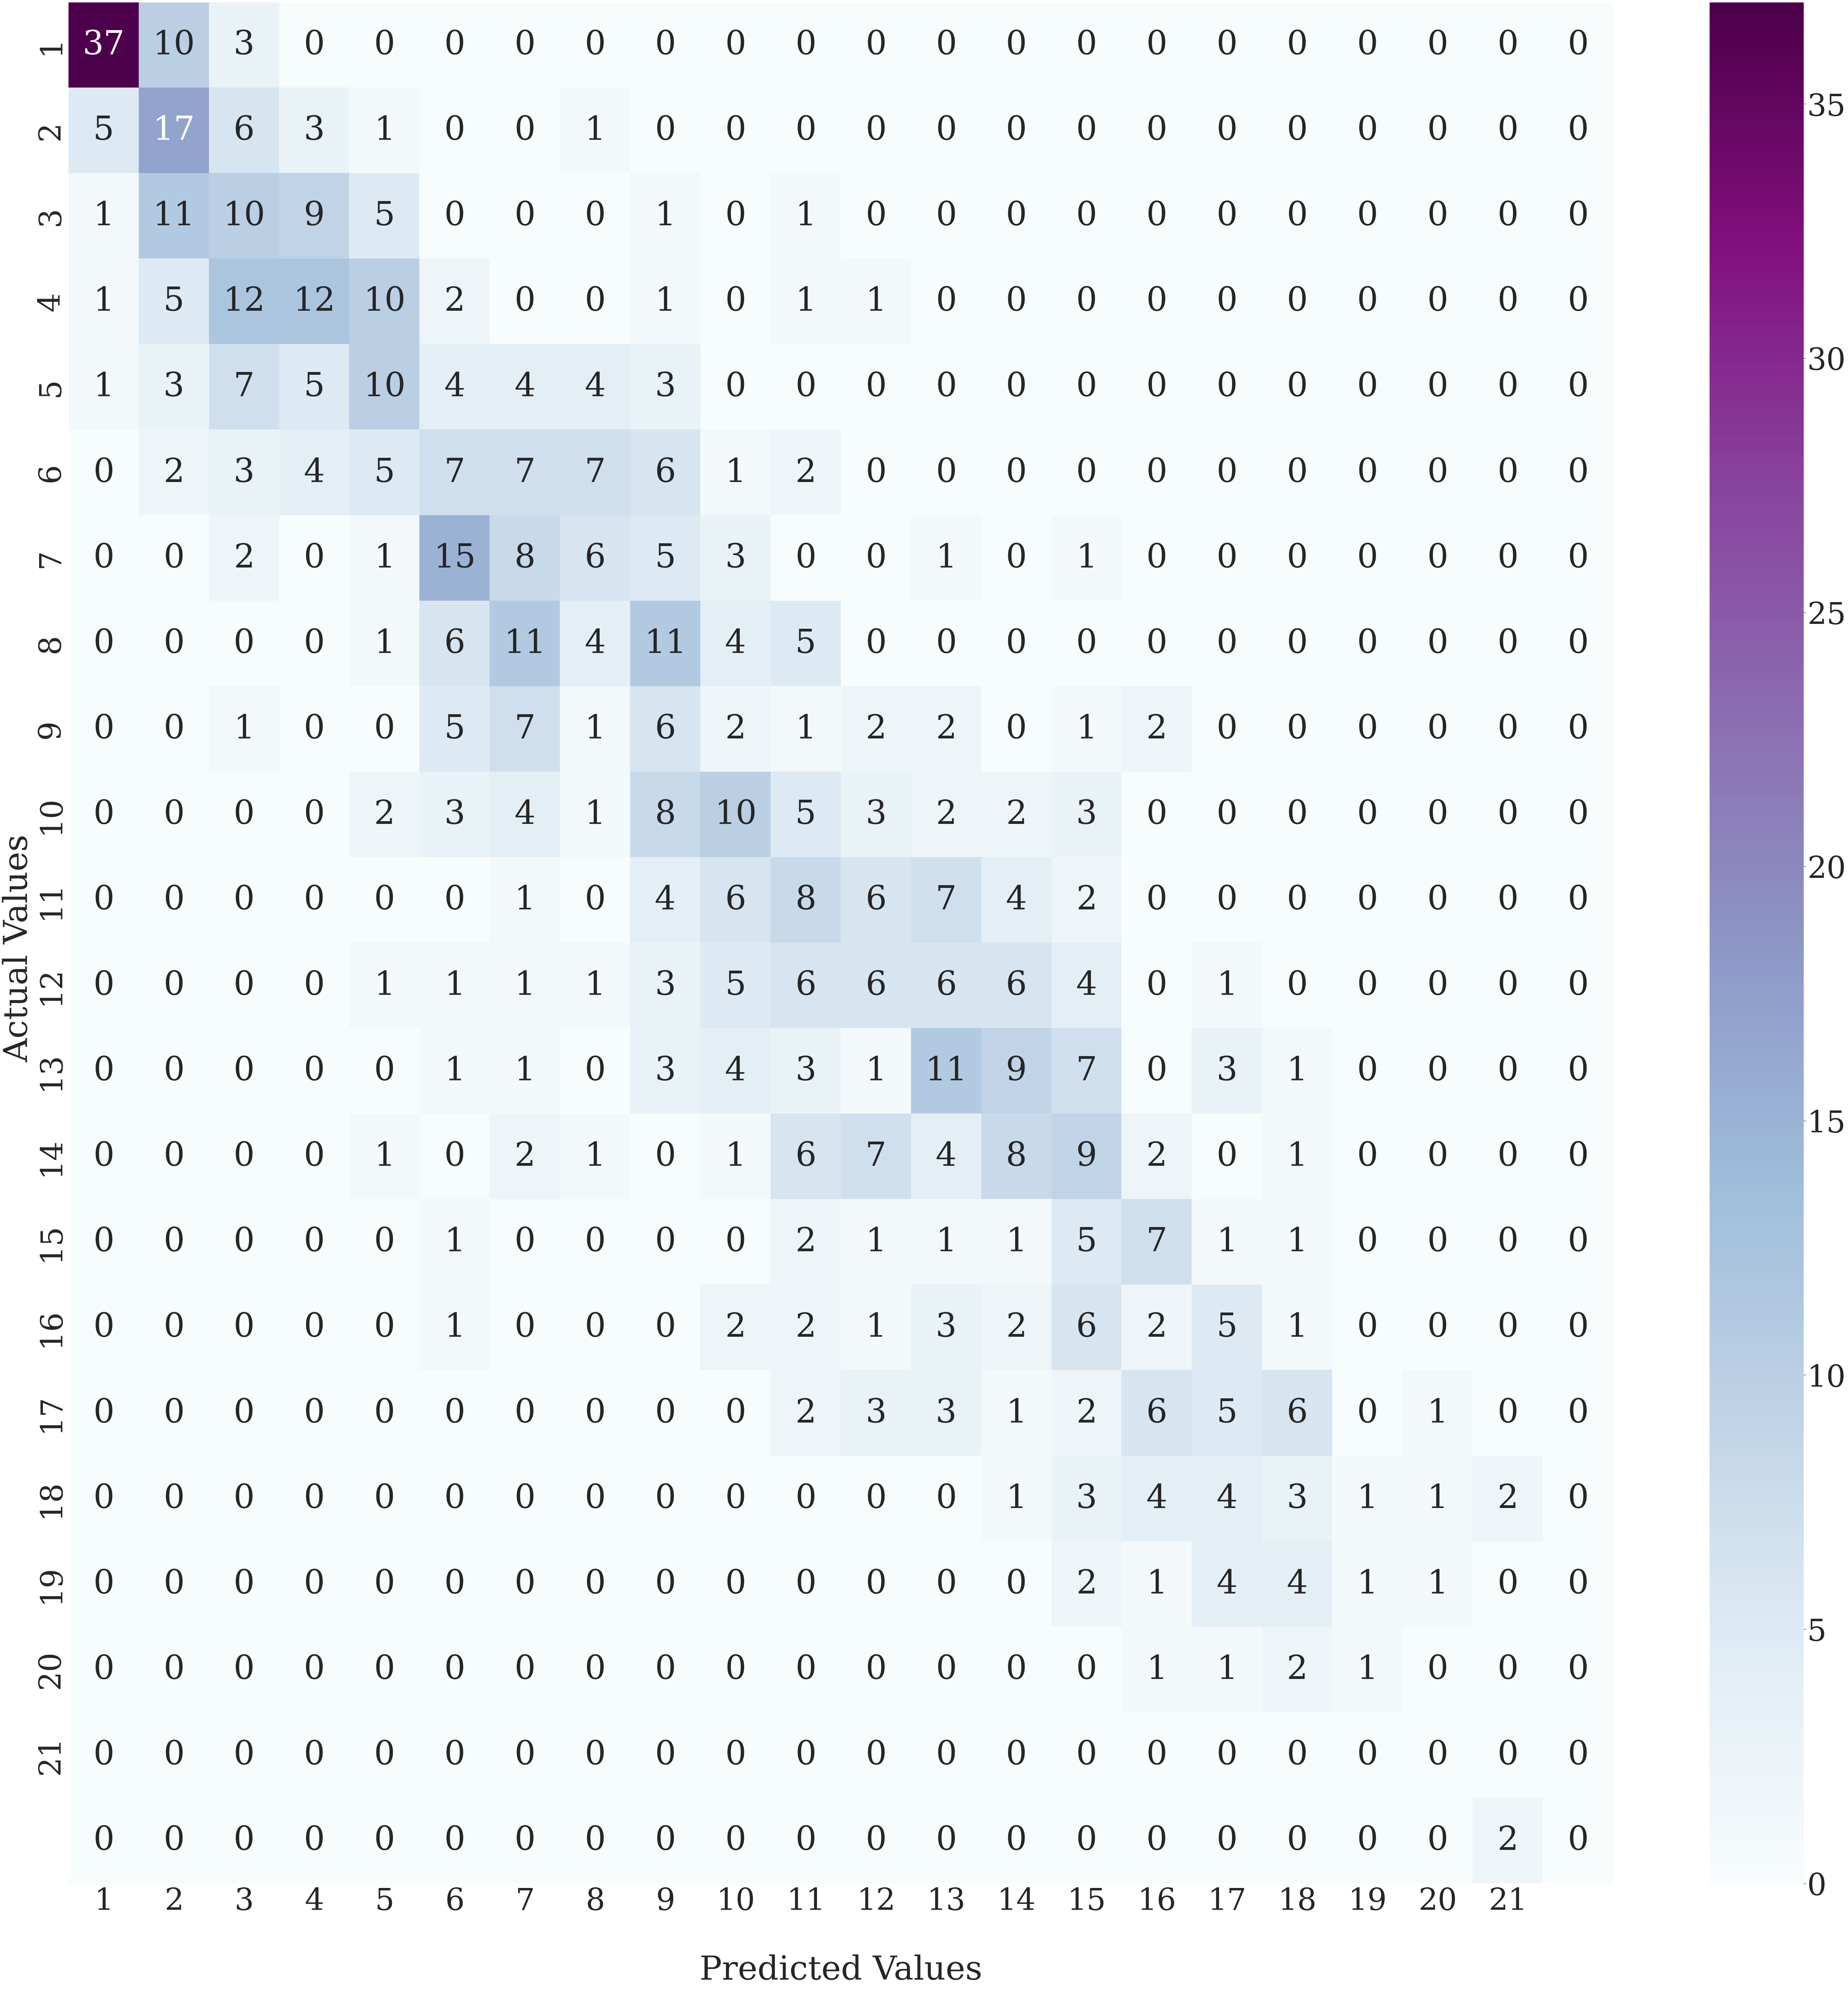

              precision    recall  f1-score   support

           1       0.82      0.74      0.78        50
           2       0.35      0.52      0.42        33
           3       0.23      0.26      0.24        38
           4       0.36      0.27      0.31        45
           5       0.27      0.24      0.26        41
           6       0.15      0.16      0.16        44
           7       0.17      0.19      0.18        42
           8       0.15      0.10      0.12        42
           9       0.12      0.20      0.15        30
          10       0.26      0.23      0.25        43
          11       0.18      0.21      0.20        38
          12       0.19      0.15      0.17        41
          13       0.28      0.25      0.26        44
          14       0.24      0.19      0.21        42
          15       0.11      0.25      0.15        20
          16       0.08      0.08      0.08        25
          17       0.21      0.17      0.19        29
          18       0.16    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

In [ ]:
testing_the_classifier(TRAINN,TESTT,thesize=(100,100),f=8)

Text(3.1999999999999886, 0.5, 'Mean decrease in impurity')

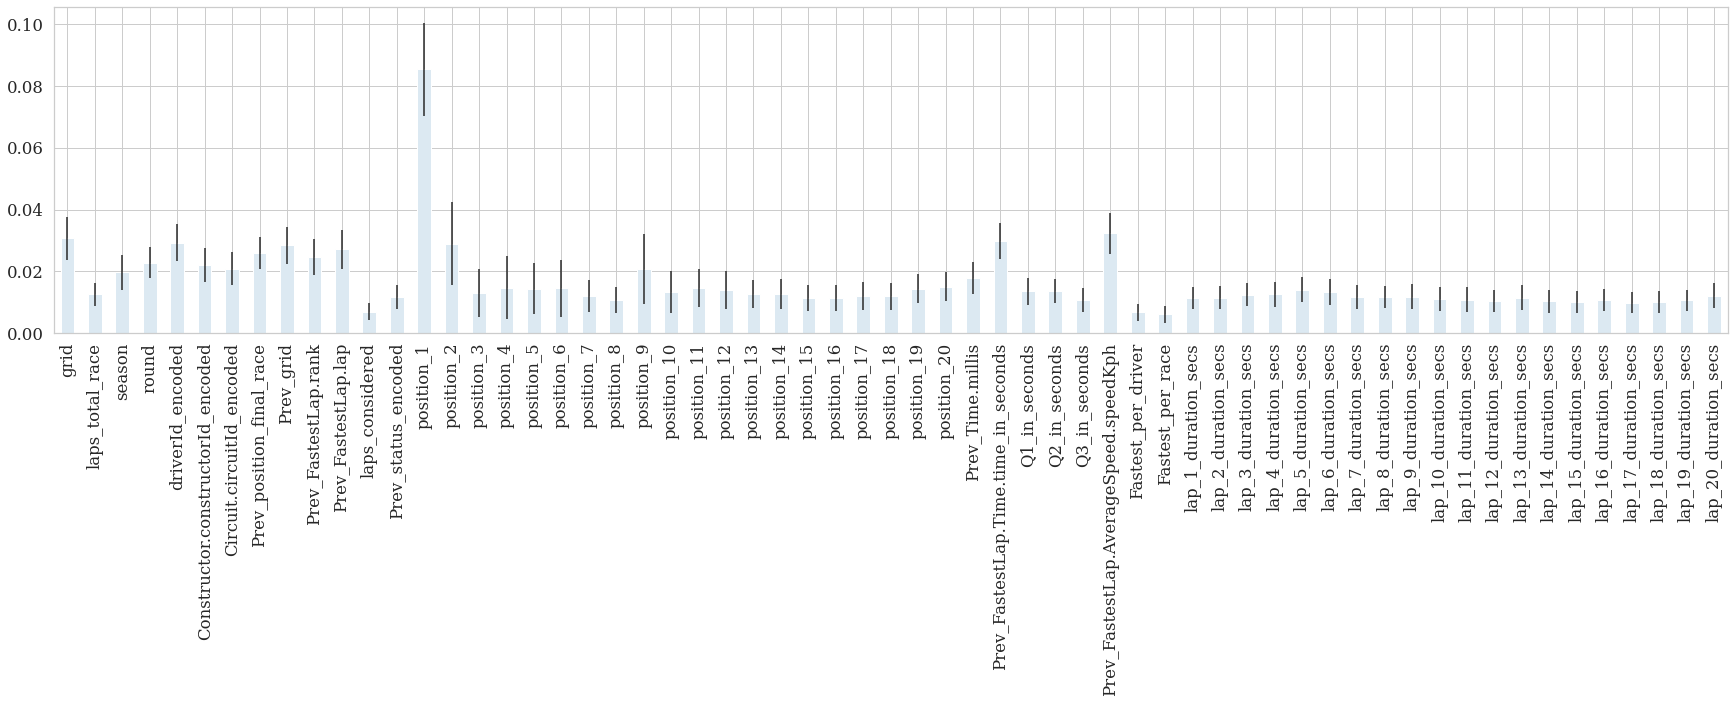

In [ ]:
from IPython.core.pylabtools import figsize
#Importances

importances = RF.feature_importances_
feature_names = [f"feature {i}" for i in range(X_train.shape[1])]
std = np.std([tree.feature_importances_ for tree in RF.estimators_], axis=0)

sns.set_theme(style="whitegrid", palette="BuPu",font_scale=1.5,font="serif")

forest_importances = pd.Series(importances, index=united[1:])

plt.figure(figsize=(30, 6))
forest_importances.plot.bar(yerr=std)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

#### Individual Metrics (do not use)

In [ ]:
def classification_g_report(clase):

    CONF=confusion_matrix(y_test_predicted,y_test)
    ii=clase-1
    All=CONF.sum()

    TP=CONF[ii,ii]

    FP1=CONF[:][ii][:ii]
    FP2=CONF[:][ii][clase:]
    FP=np.concatenate((FP1,FP2))
    sumFP=FP.sum()

    FN1=CONF[:,ii][:ii]
    FN2=CONF[:,ii][clase:]
    FN=np.concatenate((FN1,FN2))
    sumFN=FN.sum()

    sumTN=All-TP-sumFN-sumFP

    RecallL=round(TP/(sumFN+TP),3)
    PrecisionN=round(TP/(sumFP+TP),3)
    AccuracyY=round((TP+sumTN)/All,3)
    F1ScoreE=round(2*((RecallL*PrecisionN)/(RecallL+PrecisionN)),3)

    print("Podium position ",clase," - Accuracy:",AccuracyY," F1 Score:",F1ScoreE," Pres: ",PrecisionN," Recall:",RecallL)

# for i in TESTT:
#     classification_g_report(i)
